In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.metrics import mean_absolute_error

In [2]:
train=pd.read_csv("./train.csv", parse_dates=[0]) # 日付をdatetime型で取得
test=pd.read_csv("./test.csv", parse_dates=[0])
submit_sample=pd.read_csv("./sample_submit.csv", header=None)

df = pd.concat([train, test], sort=False)
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2466 entries, 0 to 364
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  2466 non-null   datetime64[ns]
 1   y         2101 non-null   float64       
 2   client    2466 non-null   int64         
 3   close     2466 non-null   int64         
 4   price_am  2466 non-null   int64         
 5   price_pm  2466 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 134.9 KB


,datetime,y,client,close,price_am,price_pm
0,2010-07-01,17.0,0,0,-1,-1
1,2010-07-02,18.0,0,0,-1,-1
2,2010-07-03,20.0,0,0,-1,-1
3,2010-07-04,20.0,0,0,-1,-1
4,2010-07-05,14.0,0,0,-1,-1
5,2010-07-06,14.0,0,0,-1,-1
6,2010-07-07,4.0,0,0,-1,-1
7,2010-07-08,10.0,0,0,-1,-1
8,2010-07-09,12.0,0,0,-1,-1
9,2010-07-10,21.0,0,0,-1,-1


In [3]:
df.loc[df['price_am'] == -1, 'price_am'] = np.nan
df.loc[df['price_pm'] == -1, 'price_pm'] = np.nan
df.head()

,datetime,y,client,close,price_am,price_pm
0,2010-07-01,17.0,0,0,NaN,NaN
1,2010-07-02,18.0,0,0,NaN,NaN
2,2010-07-03,20.0,0,0,NaN,NaN
3,2010-07-04,20.0,0,0,NaN,NaN
4,2010-07-05,14.0,0,0,NaN,NaN


In [4]:
### datimeをdatetime64[ns]型に変更。

In [5]:
#df['datetime'] = df.datetime.map(dt.datetime.timestamp)
#df['datetime'] = df['datetime'].dt.to_pydatetime()
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['weekday'] = df['datetime'].dt.weekday

In [6]:
#df=df.drop(['datetime','year'], axis=1)
df=df.drop(['datetime'], axis=1)

### Fill na

In [7]:
df['price_am'] = df.groupby(['month', 'weekday'])['price_am'].transform(lambda x: x.fillna(x.mean()))
df['price_pm'] = df.groupby(['month', 'weekday'])['price_pm'].transform(lambda x: x.fillna(x.mean()))

### New features

In [8]:
df['price'] = (df['price_am'] + df['price_pm'])/2

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2466 entries, 0 to 364
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   y         2101 non-null   float64
 1   client    2466 non-null   int64  
 2   close     2466 non-null   int64  
 3   price_am  2466 non-null   float64
 4   price_pm  2466 non-null   float64
 5   year      2466 non-null   int64  
 6   month     2466 non-null   int64  
 7   day       2466 non-null   int64  
 8   weekday   2466 non-null   int64  
 9   price     2466 non-null   float64
dtypes: float64(4), int64(6)
memory usage: 211.9 KB


In [10]:
df['client'] = df['client'].astype(str)
df['close'] = df['close'].astype(str)
df['month'] = df['month'].astype(str)
df['weekday'] = df['weekday'].astype(str)

In [11]:
pd.set_option('display.max_rows', None)
print(df.groupby(['month', 'weekday'])['price_am','price_pm','y'].mean())
print(df.groupby(['year'])['price_am','price_pm','y'].mean())

               price_am  price_pm          y
month weekday                               
1     0        0.142857  0.000000  23.423077
      1        0.107143  0.071429  21.846154
      2        0.035714  0.000000  22.692308
      3        0.178571  0.107143  21.296296
      4        0.285714  0.178571  27.444444
      5        0.892857  0.464286  36.296296
      6        0.428571  0.250000  32.666667
10    0        0.518519  0.192308  28.538462
      1        0.192308  0.076923  25.769231
      2        0.185185  0.074074  28.148148
      3        0.222222  0.148148  29.481481
      4        0.500000  0.269231  32.222222
      5        1.629630  1.111111  39.000000
      6        1.346154  0.730769  35.269231
11    0        0.120000  0.040000  28.576923
      1        0.153846  0.076923  24.000000
      2        0.153846  0.076923  24.280000
      3        0.160000  0.080000  26.120000
      4        0.423077  0.269231  32.269231
      5        1.423077  1.000000  38.884615
      6   

<ipython-input-11-ab1e28b0b82f>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  print(df.groupby(['month', 'weekday'])['price_am','price_pm','y'].mean())
<ipython-input-11-ab1e28b0b82f>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  print(df.groupby(['year'])['price_am','price_pm','y'].mean())


In [12]:
#divide dataset into two parts(categorical, contineous)
categorical, numerical = [],[]
for z in df.columns:
    t = df.dtypes[z]
    if t=='object':
        categorical.append(z)
    else:
        numerical.append(z)
print("CategoricaL:\n{}".format(categorical))
print("\nNumericaL:\n{}".format(numerical))

CategoricaL:
['client', 'close', 'month', 'weekday']

NumericaL:
['y', 'price_am', 'price_pm', 'year', 'day', 'price']


### Pandas Profining

In [13]:
#import pandas_profiling

#df.profile_report()

### Heat map for Correlation coefficient

<AxesSubplot:>

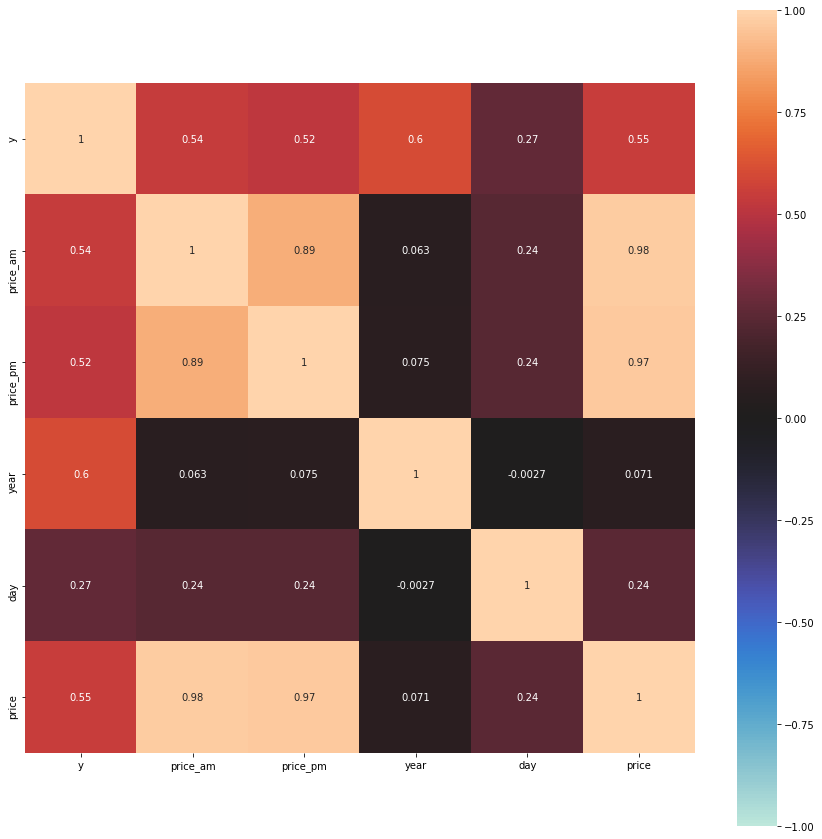

In [14]:
df_corr = df.corr()
plt.figure(figsize=(15, 15)) 
sns.heatmap(df_corr, vmax=1, vmin=-1, center=0, square=True, annot=True)

### Histogram

C:\anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No handles with labels found to put in legend.


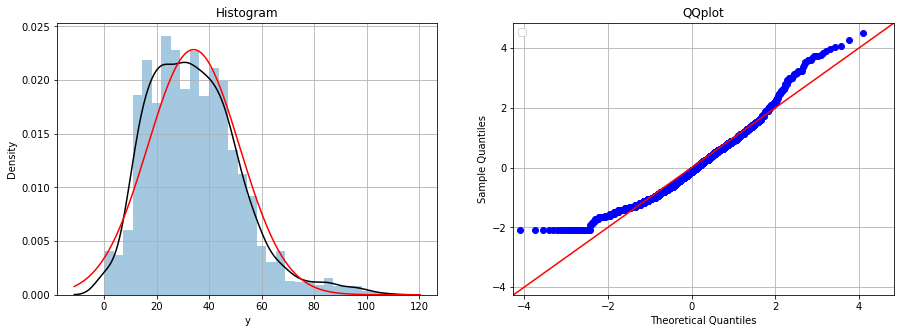

In [15]:
fig, ax = plt.subplots(1,2, figsize= (15,5))
# Histogram
sns.distplot(
    train['y'], label='y',
    kde_kws={'label': 'kde','color':'k'},
    fit=norm,fit_kws={'label': 'norm','color':'red'},
    ax = ax[0]
)
ax[0].set_title("Histogram")
ax[0].grid(True)

# QQplot
sm.qqplot(train['y'], stats.t, distargs=(4,),fit=True, line="45", ax = ax[1])
ax[1].set_title("QQplot")
ax[1].grid(True)

plt.legend() # 凡例を表示
plt.show() #グラフ表示

### Dummy

In [16]:
df =pd.get_dummies(df, columns=categorical, drop_first=True)

In [17]:
df.head(10)

,y,price_am,price_pm,year,day,price,client_1,close_1,month_10,month_11,...,month_6,month_7,month_8,month_9,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,17.0,0.192308,0.076923,2010,1,0.134615,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,18.0,0.692308,0.423077,2010,2,0.557692,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,20.0,1.807692,1.192308,2010,3,1.500000,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
3,20.0,1.407407,0.925926,2010,4,1.166667,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,14.0,0.346154,0.192308,2010,5,0.269231,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5,14.0,0.333333,0.148148,2010,6,0.240741,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
6,4.0,0.259259,0.111111,2010,7,0.185185,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
7,10.0,0.192308,0.076923,2010,8,0.134615,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
8,12.0,0.692308,0.423077,2010,9,0.557692,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
9,21.0,1.807692,1.192308,2010,10,1.500000,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


### Separate Data

In [18]:
train = df[:len(train)]
test = df[len(train):]

In [19]:
y_train = train['y']
X_train = train.drop(['y'], axis=1)
X_test = test.drop(['y'], axis=1)

In [20]:
### 線形回帰

In [21]:
from sklearn.linear_model import Lasso, Ridge, LassoCV, RidgeCV
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

In [22]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2466 entries, 0 to 364
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   y          2101 non-null   float64
 1   price_am   2466 non-null   float64
 2   price_pm   2466 non-null   float64
 3   year       2466 non-null   int64  
 4   day        2466 non-null   int64  
 5   price      2466 non-null   float64
 6   client_1   2466 non-null   uint8  
 7   close_1    2466 non-null   uint8  
 8   month_10   2466 non-null   uint8  
 9   month_11   2466 non-null   uint8  
 10  month_12   2466 non-null   uint8  
 11  month_2    2466 non-null   uint8  
 12  month_3    2466 non-null   uint8  
 13  month_4    2466 non-null   uint8  
 14  month_5    2466 non-null   uint8  
 15  month_6    2466 non-null   uint8  
 16  month_7    2466 non-null   uint8  
 17  month_8    2466 non-null   uint8  
 18  month_9    2466 non-null   uint8  
 19  weekday_1  2466 non-null   uint8  
 20  weekday_2

,y,price_am,price_pm,year,day,price,client_1,close_1,month_10,month_11,...,month_6,month_7,month_8,month_9,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,17.0,0.192308,0.076923,2010,1,0.134615,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,18.0,0.692308,0.423077,2010,2,0.557692,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,20.0,1.807692,1.192308,2010,3,1.500000,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
3,20.0,1.407407,0.925926,2010,4,1.166667,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,14.0,0.346154,0.192308,2010,5,0.269231,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [23]:
# データセットの標準化準備
scaler= StandardScaler()
# データセットの標準化
scaler.fit(X_train)
scaler.fit(X_test)
X_train_scaler = scaler.transform(X_train)
X_test_scaler  = scaler.transform(X_test)


In [24]:
# Lasso 交差検証準備
# clf = LassoCV(alphas=10 ** np.arange(-6, 1, 0.1), cv = 5)

params_grid = {
    'alpha': 10 ** np.arange(-6, 1, 0.1)
}
# パラメータチューニング
clf = GridSearchCV(
    estimator = Lasso(),
    param_grid = params_grid,
    cv = 5,
    scoring='r2',
    n_jobs = -1
    )
# 線形モデルの重みを学習
clf.fit(X_train_scaler, y_train) 

# チューニングしたモデル
best_param = clf.best_params_
lasso_tuned = clf.best_estimator_

# 予測値を反映
y_lasso_pred = lasso_tuned.predict(X_train_scaler) # Trainデータに対して予測
y_lasso_test_pred = lasso_tuned.predict(X_test_scaler) # Testデータに対して予測

#print("α = {}".format(clf.alpha_))
#print("ω = {}".format(clf.coef_))
#print("b = {}".format(clf.intercept_))
print(best_param)
print("R^2 = {}".format(clf.score(X_train_scaler, y_train)))
print("MAE = {}".format(mean_absolute_error(y_train, y_lasso_pred)))
#print(cross_val_score(clf, X_train_scaler, y_train, cv=5))

{'alpha': 0.025118864315094896}
R^2 = 0.7392186103726259
MAE = 6.871768390587337


In [25]:
import optuna.integration.lightgbm as lgb # Optuna 
#import lightgbm as lgb 
from sklearn.model_selection import KFold

In [26]:
y_lgb_preds = []
models = []
y_lgb_oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=5, shuffle=True, random_state=0)

params = {
    'task' : 'train',
    'boosting_type' : 'gbdt',
    'objective': 'regression',
    'metric' : 'rmse',
    'max_bin' : 255,
    'num_leaves' : 31,
    'learning_rate' : 0.05,
    'feature_fraction' : 0.9,
    'bagging_fraction' : 0.8,
    'bagging_freq': 5,
    'verbose' : -1
}

# Cross Validation
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.iloc[train_index, :]
    X_val = X_train.iloc[valid_index, :]
    y_tr = y_train.iloc[train_index]
    y_val = y_train.iloc[valid_index]
    
    # Train Dataset
    lgb_train = lgb.Dataset(X_tr, y_tr)

    # Evaluation Dataset (early_stopping_rounds)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    
    evals_result = {} #結果を格納するための辞書
    # train
    gbm = lgb.train(params,
                    lgb_train,
                    valid_sets=[lgb_train, lgb_eval],
                    valid_names=['train','eval'],
                    num_boost_round=1000,
                    early_stopping_rounds=100,
                    verbose_eval=100,
                    evals_result=evals_result
                   )
    # Out-of-hold of train data
    y_lgb_oof_train[valid_index] = \
        gbm.predict(X_val, num_iteration=gbm.best_iteration)

    
    # Prediction for X_test data
    y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
    
    # Append Prediction data 
    y_lgb_preds.append(y_pred)
    models.append(gbm)

print(mean_absolute_error(y_train, y_lgb_oof_train))


[I 2021-06-20 17:25:03,993] A new study created in memory with name: no-name-f7a2e33f-f043-40be-82d1-a077dadf1a57
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.43174	eval's rmse: 7.81325
[200]	train's rmse: 5.40341	eval's rmse: 7.28161
[300]	train's rmse: 4.925	eval's rmse: 7.18169
[400]	train's rmse: 4.59197	eval's rmse: 7.1431
[500]	train's rmse: 4.31827	eval's rmse: 7.11517
[600]	train's rmse: 4.11199	eval's rmse: 7.11287
Early stopping, best iteration is:
[545]	train's rmse: 4.21467	eval's rmse: 7.08435


feature_fraction, val_score: 7.084349:  14%|######4                                      | 1/7 [00:01<00:07,  1.20s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.88447	eval's rmse: 7.89485
[200]	train's rmse: 4.80825	eval's rmse: 7.28989
[300]	train's rmse: 4.27413	eval's rmse: 7.18736
[400]	train's rmse: 3.90658	eval's rmse: 7.14151
Early stopping, best iteration is:
[391]	train's rmse: 3.92875	eval's rmse: 7.11942


feature_fraction, val_score: 7.084349:  29%|############8                                | 2/7 [00:02<00:06,  1.27s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.12105	eval's rmse: 7.70016
[200]	train's rmse: 5.0541	eval's rmse: 7.16529
[300]	train's rmse: 4.52435	eval's rmse: 7.10305
[400]	train's rmse: 4.16314	eval's rmse: 7.06131


feature_fraction, val_score: 7.058624:  43%|###################2                         | 3/7 [00:03<00:05,  1.36s/it]

Early stopping, best iteration is:
[396]	train's rmse: 4.17537	eval's rmse: 7.05862
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.93456	eval's rmse: 7.8809
[200]	train's rmse: 4.84296	eval's rmse: 7.32166
[300]	train's rmse: 4.29081	eval's rmse: 7.23366
[400]	train's rmse: 3.92812	eval's rmse: 7.16653
Early stopping, best iteration is:
[390]	train's rmse: 3.95972	eval's rmse: 7.16074


feature_fraction, val_score: 7.058624:  57%|#########################7                   | 4/7 [00:04<00:03,  1.17s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.80849	eval's rmse: 7.91683
[200]	train's rmse: 5.75734	eval's rmse: 7.34923
[300]	train's rmse: 5.24572	eval's rmse: 7.21596
[400]	train's rmse: 4.88844	eval's rmse: 7.13829
[500]	train's rmse: 4.60883	eval's rmse: 7.11737
[600]	train's rmse: 4.40455	eval's rmse: 7.09493
[700]	train's rmse: 4.2445	eval's rmse: 7.07937
Early stopping, best iteration is:
[654]	train's rmse: 4.30483	eval's rmse: 7.06907


feature_fraction, val_score: 7.058624:  71%|################################1            | 5/7 [00:05<00:02,  1.14s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.281	eval's rmse: 7.80012
[200]	train's rmse: 5.24686	eval's rmse: 7.2858
[300]	train's rmse: 4.75101	eval's rmse: 7.20582
[400]	train's rmse: 4.40044	eval's rmse: 7.16122
[500]	train's rmse: 4.11732	eval's rmse: 7.13721
[600]	train's rmse: 3.90058	eval's rmse: 7.15015
Early stopping, best iteration is:
[545]	train's rmse: 4.01623	eval's rmse: 7.11072


feature_fraction, val_score: 7.058624:  86%|######################################5      | 6/7 [00:06<00:01,  1.10s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.99678	eval's rmse: 7.80944
[200]	train's rmse: 4.93402	eval's rmse: 7.28409
[300]	train's rmse: 4.39025	eval's rmse: 7.18154
[400]	train's rmse: 4.02915	eval's rmse: 7.14782
[500]	train's rmse: 3.74439	eval's rmse: 7.15917
Early stopping, best iteration is:
[425]	train's rmse: 3.94944	eval's rmse: 7.12954


num_leaves, val_score: 7.058624:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.95657	eval's rmse: 7.69256
[200]	train's rmse: 4.82448	eval's rmse: 7.23373
[300]	train's rmse: 4.2251	eval's rmse: 7.17878
[400]	train's rmse: 3.83499	eval's rmse: 7.14212
[500]	train's rmse: 3.5246	eval's rmse: 7.15621
Early stopping, best iteration is:
[431]	train's rmse: 3.72977	eval's rmse: 7.1219


num_leaves, val_score: 7.058624:   5%|##5                                               | 1/20 [00:01<00:23,  1.21s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 8.17949	eval's rmse: 8.61366
[200]	train's rmse: 7.43635	eval's rmse: 7.8732
[300]	train's rmse: 7.10799	eval's rmse: 7.69378
[400]	train's rmse: 6.79249	eval's rmse: 7.43968
[500]	train's rmse: 6.57678	eval's rmse: 7.36618
[600]	train's rmse: 6.42317	eval's rmse: 7.30013
[700]	train's rmse: 6.22216	eval's rmse: 7.14609
[800]	train's rmse: 6.06829	eval's rmse: 7.01855


num_leaves, val_score: 6.947516:  10%|#####                                             | 2/20 [00:01<00:14,  1.21it/s]

[900]	train's rmse: 5.9762	eval's rmse: 7.01131
[1000]	train's rmse: 5.87439	eval's rmse: 6.94752
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.87439	eval's rmse: 6.94752
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.95657	eval's rmse: 7.69256
[200]	train's rmse: 4.82448	eval's rmse: 7.23373
[300]	train's rmse: 4.2251	eval's rmse: 7.17878
[400]	train's rmse: 3.83499	eval's rmse: 7.14212
[500]	train's rmse: 3.5246	eval's rmse: 7.15621
Early stopping, best iteration is:
[431]	train's rmse: 3.72977	eval's rmse: 7.1219


num_leaves, val_score: 6.947516:  15%|#######5                                          | 3/20 [00:02<00:16,  1.03it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.95657	eval's rmse: 7.69256
[200]	train's rmse: 4.82448	eval's rmse: 7.23373
[300]	train's rmse: 4.2251	eval's rmse: 7.17878
[400]	train's rmse: 3.83499	eval's rmse: 7.14212
[500]	train's rmse: 3.5246	eval's rmse: 7.15621


num_leaves, val_score: 6.947516:  20%|##########                                        | 4/20 [00:03<00:16,  1.01s/it][I 2021-06-20 17:25:16,022] Trial 10 finished with value: 7.121898521344351 and parameters: {'num_leaves': 123}. Best is trial 8 with value: 6.947515656865834.


Early stopping, best iteration is:
[431]	train's rmse: 3.72977	eval's rmse: 7.1219


num_leaves, val_score: 6.947516:  20%|##########                                        | 4/20 [00:03<00:16,  1.01s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.65315	eval's rmse: 7.94085
[200]	train's rmse: 5.68291	eval's rmse: 7.30762
[300]	train's rmse: 5.23785	eval's rmse: 7.14714
[400]	train's rmse: 4.93163	eval's rmse: 7.04159
[500]	train's rmse: 4.70168	eval's rmse: 7.0252


num_leaves, val_score: 6.947516:  20%|##########                                        | 4/20 [00:04<00:16,  1.01s/it]

[600]	train's rmse: 4.52705	eval's rmse: 7.01891
[700]	train's rmse: 4.3719	eval's rmse: 7.02249
Early stopping, best iteration is:
[649]	train's rmse: 4.44616	eval's rmse: 6.98414


num_leaves, val_score: 6.947516:  25%|############5                                     | 5/20 [00:04<00:13,  1.09it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.95657	eval's rmse: 7.69256
[200]	train's rmse: 4.82448	eval's rmse: 7.23373
[300]	train's rmse: 4.2251	eval's rmse: 7.17878
[400]	train's rmse: 3.83499	eval's rmse: 7.14212
[500]	train's rmse: 3.5246	eval's rmse: 7.15621


num_leaves, val_score: 6.947516:  30%|###############                                   | 6/20 [00:05<00:13,  1.02it/s]

Early stopping, best iteration is:
[431]	train's rmse: 3.72977	eval's rmse: 7.1219


[I 2021-06-20 17:25:17,861] Trial 12 finished with value: 7.121898521344351 and parameters: {'num_leaves': 156}. Best is trial 8 with value: 6.947515656865834.
num_leaves, val_score: 6.947516:  30%|###############                                   | 6/20 [00:05<00:13,  1.02it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.95657	eval's rmse: 7.69256
[200]	train's rmse: 4.82448	eval's rmse: 7.23373
[300]	train's rmse: 4.2251	eval's rmse: 7.17878
[400]	train's rmse: 3.83499	eval's rmse: 7.14212
[500]	train's rmse: 3.5246	eval's rmse: 7.15621
Early stopping, best iteration is:
[431]	train's rmse: 3.72977	eval's rmse: 7.1219


num_leaves, val_score: 6.947516:  35%|#################5                                | 7/20 [00:07<00:15,  1.21s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.95657	eval's rmse: 7.69256
[200]	train's rmse: 4.82448	eval's rmse: 7.23373
[300]	train's rmse: 4.2251	eval's rmse: 7.17878
[400]	train's rmse: 3.83499	eval's rmse: 7.14212
[500]	train's rmse: 3.5246	eval's rmse: 7.15621
Early stopping, best iteration is:
[431]	train's rmse: 3.72977	eval's rmse: 7.1219


num_leaves, val_score: 6.947516:  40%|####################                              | 8/20 [00:08<00:15,  1.28s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.95657	eval's rmse: 7.69256
[200]	train's rmse: 4.82448	eval's rmse: 7.23373
[300]	train's rmse: 4.2251	eval's rmse: 7.17878
[400]	train's rmse: 3.83499	eval's rmse: 7.14212
[500]	train's rmse: 3.5246	eval's rmse: 7.15621
Early stopping, best iteration is:
[431]	train's rmse: 3.72977	eval's rmse: 7.1219


num_leaves, val_score: 6.947516:  45%|######################5                           | 9/20 [00:10<00:13,  1.26s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.95657	eval's rmse: 7.69256
[200]	train's rmse: 4.82448	eval's rmse: 7.23373
[300]	train's rmse: 4.2251	eval's rmse: 7.17878
[400]	train's rmse: 3.83499	eval's rmse: 7.14212
[500]	train's rmse: 3.5246	eval's rmse: 7.15621
Early stopping, best iteration is:
[431]	train's rmse: 3.72977	eval's rmse: 7.1219


num_leaves, val_score: 6.947516:  50%|########################5                        | 10/20 [00:12<00:14,  1.47s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.93595	eval's rmse: 8.03498
[200]	train's rmse: 6.00227	eval's rmse: 7.33769
[300]	train's rmse: 5.57871	eval's rmse: 7.15342
[400]	train's rmse: 5.27055	eval's rmse: 7.04619
[500]	train's rmse: 5.04948	eval's rmse: 7.0045


num_leaves, val_score: 6.947516:  55%|##########################9                      | 11/20 [00:12<00:11,  1.26s/it]

[600]	train's rmse: 4.88665	eval's rmse: 7.01422
[700]	train's rmse: 4.73581	eval's rmse: 6.99835
Early stopping, best iteration is:
[649]	train's rmse: 4.80651	eval's rmse: 6.96931
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 8.55138	eval's rmse: 8.90587
[200]	train's rmse: 7.7809	eval's rmse: 8.1028
[300]	train's rmse: 7.53517	eval's rmse: 7.95753
[400]	train's rmse: 7.26241	eval's rmse: 7.72532
[500]	train's rmse: 7.08209	eval's rmse: 7.6249


num_leaves, val_score: 6.947516:  55%|##########################9                      | 11/20 [00:13<00:11,  1.26s/it]

[600]	train's rmse: 6.95073	eval's rmse: 7.53234
[700]	train's rmse: 6.76679	eval's rmse: 7.33629
[800]	train's rmse: 6.6296	eval's rmse: 7.1959
[900]	train's rmse: 6.5371	eval's rmse: 7.17373
[1000]	train's rmse: 6.45359	eval's rmse: 7.10845
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.45359	eval's rmse: 7.10845


num_leaves, val_score: 6.947516:  60%|#############################4                   | 12/20 [00:13<00:08,  1.02s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.95657	eval's rmse: 7.69256
[200]	train's rmse: 4.82448	eval's rmse: 7.23373
[300]	train's rmse: 4.2251	eval's rmse: 7.17878
[400]	train's rmse: 3.83499	eval's rmse: 7.14212
[500]	train's rmse: 3.5246	eval's rmse: 7.15621


num_leaves, val_score: 6.947516:  65%|###############################8                 | 13/20 [00:14<00:07,  1.03s/it][I 2021-06-20 17:25:26,437] Trial 19 finished with value: 7.121898521344351 and parameters: {'num_leaves': 60}. Best is trial 8 with value: 6.947515656865834.


Early stopping, best iteration is:
[431]	train's rmse: 3.72977	eval's rmse: 7.1219


num_leaves, val_score: 6.947516:  65%|###############################8                 | 13/20 [00:14<00:07,  1.03s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.94016	eval's rmse: 7.6689
[200]	train's rmse: 4.80415	eval's rmse: 7.18624
[300]	train's rmse: 4.22372	eval's rmse: 7.10417


num_leaves, val_score: 6.947516:  65%|###############################8                 | 13/20 [00:15<00:07,  1.03s/it]

[400]	train's rmse: 3.83825	eval's rmse: 7.11149
Early stopping, best iteration is:
[335]	train's rmse: 4.06512	eval's rmse: 7.08208


num_leaves, val_score: 6.947516:  70%|##################################3              | 14/20 [00:15<00:05,  1.02it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.95657	eval's rmse: 7.69256
[200]	train's rmse: 4.82448	eval's rmse: 7.23373
[300]	train's rmse: 4.2251	eval's rmse: 7.17878
[400]	train's rmse: 3.83499	eval's rmse: 7.14212
[500]	train's rmse: 3.5246	eval's rmse: 7.15621


num_leaves, val_score: 6.947516:  75%|####################################7            | 15/20 [00:16<00:05,  1.00s/it][I 2021-06-20 17:25:28,368] Trial 21 finished with value: 7.121898521344351 and parameters: {'num_leaves': 78}. Best is trial 8 with value: 6.947515656865834.


Early stopping, best iteration is:
[431]	train's rmse: 3.72977	eval's rmse: 7.1219


num_leaves, val_score: 6.947516:  75%|####################################7            | 15/20 [00:16<00:05,  1.00s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.95657	eval's rmse: 7.69256
[200]	train's rmse: 4.82448	eval's rmse: 7.23373
[300]	train's rmse: 4.2251	eval's rmse: 7.17878
[400]	train's rmse: 3.83499	eval's rmse: 7.14212
[500]	train's rmse: 3.5246	eval's rmse: 7.15621


num_leaves, val_score: 6.947516:  75%|####################################7            | 15/20 [00:17<00:05,  1.00s/it]

Early stopping, best iteration is:
[431]	train's rmse: 3.72977	eval's rmse: 7.1219


num_leaves, val_score: 6.947516:  80%|#######################################2         | 16/20 [00:17<00:04,  1.05s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.1996	eval's rmse: 7.69041
[200]	train's rmse: 5.16177	eval's rmse: 7.18877
[300]	train's rmse: 4.65775	eval's rmse: 7.0692
[400]	train's rmse: 4.31031	eval's rmse: 7.01589
[500]	train's rmse: 4.04117	eval's rmse: 7.01749
Early stopping, best iteration is:
[450]	train's rmse: 4.16361	eval's rmse: 6.9935


num_leaves, val_score: 6.947516:  85%|#########################################6       | 17/20 [00:18<00:02,  1.02it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.95657	eval's rmse: 7.69256
[200]	train's rmse: 4.82448	eval's rmse: 7.23373
[300]	train's rmse: 4.2251	eval's rmse: 7.17878
[400]	train's rmse: 3.83499	eval's rmse: 7.14212
[500]	train's rmse: 3.5246	eval's rmse: 7.15621
Early stopping, best iteration is:
[431]	train's rmse: 3.72977	eval's rmse: 7.1219


num_leaves, val_score: 6.947516:  90%|############################################1    | 18/20 [00:19<00:02,  1.09s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 8.55138	eval's rmse: 8.90587
[200]	train's rmse: 7.7809	eval's rmse: 8.1028
[300]	train's rmse: 7.53517	eval's rmse: 7.95753
[400]	train's rmse: 7.26241	eval's rmse: 7.72532
[500]	train's rmse: 7.08209	eval's rmse: 7.6249
[600]	train's rmse: 6.95073	eval's rmse: 7.53234
[700]	train's rmse: 6.76679	eval's rmse: 7.33629
[800]	train's rmse: 6.6296	eval's rmse: 7.1959
[900]	train's rmse: 6.5371	eval's rmse: 7.17373


num_leaves, val_score: 6.947516:  95%|##############################################5  | 19/20 [00:20<00:01,  1.02s/it]

[1000]	train's rmse: 6.45359	eval's rmse: 7.10845
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.45359	eval's rmse: 7.10845
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.03529	eval's rmse: 7.70703
[200]	train's rmse: 4.93888	eval's rmse: 7.23078
[300]	train's rmse: 4.39432	eval's rmse: 7.16989
[400]	train's rmse: 4.02054	eval's rmse: 7.13222


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Early stopping, best iteration is:
[391]	train's rmse: 4.0472	eval's rmse: 7.12357


bagging, val_score: 6.947516:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 8.23507	eval's rmse: 8.60969
[200]	train's rmse: 7.71477	eval's rmse: 8.30201
[300]	train's rmse: 7.36865	eval's rmse: 8.03943
[400]	train's rmse: 7.10358	eval's rmse: 7.85665
[500]	train's rmse: 6.90243	eval's rmse: 7.71223
[600]	train's rmse: 6.72766	eval's rmse: 7.59788
[700]	train's rmse: 6.56683	eval's rmse: 7.5151
[800]	train's rmse: 6.42393	eval's rmse: 7.44203
[900]	train's rmse: 6.29851	eval's rmse: 7.30123


bagging, val_score: 6.947516:  10%|#####3                                               | 1/10 [00:00<00:05,  1.72it/s]

[1000]	train's rmse: 6.19282	eval's rmse: 7.30569
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.19282	eval's rmse: 7.30569
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.91291	eval's rmse: 7.95957
[200]	train's rmse: 7.31973	eval's rmse: 7.45797
[300]	train's rmse: 6.98559	eval's rmse: 7.24983
[400]	train's rmse: 6.74359	eval's rmse: 7.0927
[500]	train's rmse: 6.53357	eval's rmse: 7.04401
[600]	train's rmse: 6.36203	eval's rmse: 6.96092
[700]	train's rmse: 6.21669	eval's rmse: 6.9197
[800]	train's rmse: 6.09926	eval's rmse: 6.87115


bagging, val_score: 6.815372:  20%|##########6                                          | 2/10 [00:01<00:05,  1.37it/s]

[900]	train's rmse: 5.97427	eval's rmse: 6.81422
[1000]	train's rmse: 5.87288	eval's rmse: 6.81537
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.87288	eval's rmse: 6.81537
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.88417	eval's rmse: 7.98544
[200]	train's rmse: 7.30819	eval's rmse: 7.4815
[300]	train's rmse: 6.99233	eval's rmse: 7.28889
[400]	train's rmse: 6.75812	eval's rmse: 7.1708
[500]	train's rmse: 6.54516	eval's rmse: 7.07533
[600]	train's rmse: 6.36692	eval's rmse: 7.01404
[700]	train's rmse: 6.22713	eval's rmse: 6.97628
[800]	train's rmse: 6.09315	eval's rmse: 6.93822
[900]	train's rmse: 5.98191	eval's rmse: 6.9144
[1000]	train's rmse: 5.89067	eval's rmse: 6.89013
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.89067	eval's rmse: 6.89013


bagging, val_score: 6.815372:  30%|###############9                                     | 3/10 [00:02<00:05,  1.19it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.8732	eval's rmse: 7.96861
[200]	train's rmse: 7.30245	eval's rmse: 7.45918
[300]	train's rmse: 6.96849	eval's rmse: 7.27845
[400]	train's rmse: 6.71975	eval's rmse: 7.13549
[500]	train's rmse: 6.51763	eval's rmse: 7.08233
[600]	train's rmse: 6.3501	eval's rmse: 7.02783
[700]	train's rmse: 6.20897	eval's rmse: 6.9858
[800]	train's rmse: 6.07989	eval's rmse: 6.92633
[900]	train's rmse: 5.96555	eval's rmse: 6.90124
[1000]	train's rmse: 5.85311	eval's rmse: 6.84955
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.85311	eval's rmse: 6.84955


bagging, val_score: 6.815372:  40%|#####################2                               | 4/10 [00:03<00:04,  1.22it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 8.23976	eval's rmse: 8.67429
[200]	train's rmse: 7.74972	eval's rmse: 8.31921
[300]	train's rmse: 7.41742	eval's rmse: 8.11335
[400]	train's rmse: 7.18003	eval's rmse: 7.92011
[500]	train's rmse: 6.9897	eval's rmse: 7.79911
[600]	train's rmse: 6.79453	eval's rmse: 7.6946
[700]	train's rmse: 6.65846	eval's rmse: 7.60818
[800]	train's rmse: 6.53337	eval's rmse: 7.50361
[900]	train's rmse: 6.41819	eval's rmse: 7.42207


bagging, val_score: 6.815372:  50%|##########################5                          | 5/10 [00:04<00:04,  1.17it/s]

[1000]	train's rmse: 6.32132	eval's rmse: 7.36864
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.32132	eval's rmse: 7.36864
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 8.20892	eval's rmse: 8.61981
[200]	train's rmse: 7.69882	eval's rmse: 8.27611
[300]	train's rmse: 7.34034	eval's rmse: 8.03824
[400]	train's rmse: 7.07382	eval's rmse: 7.81485
[500]	train's rmse: 6.77056	eval's rmse: 7.5749
[600]	train's rmse: 6.60264	eval's rmse: 7.47598
[700]	train's rmse: 6.45346	eval's rmse: 7.4162
[800]	train's rmse: 6.315	eval's rmse: 7.3112
[900]	train's rmse: 6.19901	eval's rmse: 7.24357
[1000]	train's rmse: 6.10756	eval's rmse: 7.23148
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.10756	eval's rmse: 7.23148


bagging, val_score: 6.815372:  60%|###############################8                     | 6/10 [00:05<00:03,  1.08it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 8.17887	eval's rmse: 8.58937
[200]	train's rmse: 7.54716	eval's rmse: 8.074
[300]	train's rmse: 7.22404	eval's rmse: 7.83551
[400]	train's rmse: 6.94754	eval's rmse: 7.64998
[500]	train's rmse: 6.71094	eval's rmse: 7.49404
[600]	train's rmse: 6.48267	eval's rmse: 7.31306
[700]	train's rmse: 6.30411	eval's rmse: 7.21387
[800]	train's rmse: 6.13259	eval's rmse: 7.07842
[900]	train's rmse: 6.0155	eval's rmse: 7.01311

bagging, val_score: 6.815372:  70%|#####################################                | 7/10 [00:06<00:02,  1.08it/s]


[1000]	train's rmse: 5.92342	eval's rmse: 6.99938
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.92342	eval's rmse: 6.99938
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 8.22846	eval's rmse: 8.61608
[200]	train's rmse: 7.7261	eval's rmse: 8.30529
[300]	train's rmse: 7.3835	eval's rmse: 8.05949
[400]	train's rmse: 7.12913	eval's rmse: 7.84014
[500]	train's rmse: 6.91782	eval's rmse: 7.7447
[600]	train's rmse: 6.74268	eval's rmse: 7.6281
[700]	train's rmse: 6.58605	eval's rmse: 7.55155
[800]	train's rmse: 6.45015	eval's rmse: 7.49724
[900]	train's rmse: 6.32937	eval's rmse: 7.39927
[1000]	train's rmse: 6.22668	eval's rmse: 7.36783
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.22668	eval's rmse: 7.36783


bagging, val_score: 6.815372:  80%|##########################################4          | 8/10 [00:06<00:01,  1.23it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 8.18548	eval's rmse: 8.59783
[200]	train's rmse: 7.45371	eval's rmse: 7.89666
[300]	train's rmse: 7.04003	eval's rmse: 7.56968
[400]	train's rmse: 6.75881	eval's rmse: 7.40219
[500]	train's rmse: 6.52596	eval's rmse: 7.1995
[600]	train's rmse: 6.33812	eval's rmse: 7.11625
[700]	train's rmse: 6.19208	eval's rmse: 7.03884
[800]	train's rmse: 6.04565	eval's rmse: 6.93636
[900]	train's rmse: 5.93821	eval's rmse: 6.90379
[1000]	train's rmse: 5.85417	eval's rmse: 6.87933
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.85417	eval's rmse: 6.87933


bagging, val_score: 6.815372:  90%|###############################################7     | 9/10 [00:07<00:00,  1.24it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 8.23849	eval's rmse: 8.6642
[200]	train's rmse: 7.75573	eval's rmse: 8.31065
[300]	train's rmse: 7.42523	eval's rmse: 8.08052
[400]	train's rmse: 7.17679	eval's rmse: 7.92577
[500]	train's rmse: 6.98563	eval's rmse: 7.80607
[600]	train's rmse: 6.80456	eval's rmse: 7.70656
[700]	train's rmse: 6.66811	eval's rmse: 7.62844
[800]	train's rmse: 6.54243	eval's rmse: 7.52258


feature_fraction_stage2, val_score: 6.815372:   0%|                                              | 0/6 [00:00<?, ?it/s]

[900]	train's rmse: 6.42327	eval's rmse: 7.44003
[1000]	train's rmse: 6.31976	eval's rmse: 7.37401
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.31976	eval's rmse: 7.37401
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.92663	eval's rmse: 7.98477
[200]	train's rmse: 7.3505	eval's rmse: 7.48462
[300]	train's rmse: 7.02104	eval's rmse: 7.29988
[400]	train's rmse: 6.76793	eval's rmse: 7.14051
[500]	train's rmse: 6.54571	eval's rmse: 7.0486
[600]	train's rmse: 6.37038	eval's rmse: 6.96062
[700]	train's rmse: 6.22486	eval's rmse: 6.89746
[800]	train's rmse: 6.09746	eval's rmse: 6.85958


feature_fraction_stage2, val_score: 6.815372:  17%|######3                               | 1/6 [00:00<00:04,  1.12it/s]

[900]	train's rmse: 5.97919	eval's rmse: 6.83148
[1000]	train's rmse: 5.87899	eval's rmse: 6.83027
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.87899	eval's rmse: 6.83027
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.92663	eval's rmse: 7.98477
[200]	train's rmse: 7.3505	eval's rmse: 7.48462
[300]	train's rmse: 7.02104	eval's rmse: 7.29988
[400]	train's rmse: 6.76793	eval's rmse: 7.14051
[500]	train's rmse: 6.54571	eval's rmse: 7.0486
[600]	train's rmse: 6.37038	eval's rmse: 6.96062
[700]	train's rmse: 6.22486	eval's rmse: 6.89746
[800]	train's rmse: 6.09746	eval's rmse: 6.85958
[900]	train's rmse: 5.97919	eval's rmse: 6.83148
[1000]	train's rmse: 5.87899	eval's rmse: 6.83027
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.87899	eval's rmse: 6.83027


feature_fraction_stage2, val_score: 6.815372:  33%|############6                         | 2/6 [00:01<00:03,  1.19it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.90479	eval's rmse: 7.96748
[200]	train's rmse: 7.3351	eval's rmse: 7.48894
[300]	train's rmse: 7.01778	eval's rmse: 7.27783
[400]	train's rmse: 6.77019	eval's rmse: 7.12219
[500]	train's rmse: 6.54806	eval's rmse: 7.03567
[600]	train's rmse: 6.3724	eval's rmse: 6.94496
[700]	train's rmse: 6.21954	eval's rmse: 6.88813
[800]	train's rmse: 6.10278	eval's rmse: 6.84725


feature_fraction_stage2, val_score: 6.812435:  33%|############6                         | 2/6 [00:02<00:03,  1.19it/s]

[900]	train's rmse: 5.98668	eval's rmse: 6.8169
[1000]	train's rmse: 5.88441	eval's rmse: 6.81243
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.88441	eval's rmse: 6.81243


feature_fraction_stage2, val_score: 6.812435:  50%|###################                   | 3/6 [00:02<00:02,  1.24it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.87456	eval's rmse: 7.928
[200]	train's rmse: 7.29084	eval's rmse: 7.43619
[300]	train's rmse: 6.96181	eval's rmse: 7.23448
[400]	train's rmse: 6.69898	eval's rmse: 7.04292
[500]	train's rmse: 6.47501	eval's rmse: 6.96199
[600]	train's rmse: 6.31182	eval's rmse: 6.89633
[700]	train's rmse: 6.16883	eval's rmse: 6.84165


feature_fraction_stage2, val_score: 6.760605:  67%|#########################3            | 4/6 [00:03<00:01,  1.28it/s]

[800]	train's rmse: 6.04268	eval's rmse: 6.8006
[900]	train's rmse: 5.91614	eval's rmse: 6.75241
[1000]	train's rmse: 5.82087	eval's rmse: 6.7606
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.82087	eval's rmse: 6.7606
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.91291	eval's rmse: 7.95957
[200]	train's rmse: 7.31973	eval's rmse: 7.45797
[300]	train's rmse: 6.98559	eval's rmse: 7.24983
[400]	train's rmse: 6.74359	eval's rmse: 7.0927
[500]	train's rmse: 6.53357	eval's rmse: 7.04401
[600]	train's rmse: 6.36203	eval's rmse: 6.96092
[700]	train's rmse: 6.21669	eval's rmse: 6.9197
[800]	train's rmse: 6.09926	eval's rmse: 6.87115
[900]	train's rmse: 5.97427	eval's rmse: 6.81422
[1000]	train's rmse: 5.87288	eval's rmse: 6.81537
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.87288	eval's rmse: 6.81537


feature_fraction_stage2, val_score: 6.760605:  83%|###############################6      | 5/6 [00:03<00:00,  1.43it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.84499	eval's rmse: 7.89856
[200]	train's rmse: 7.29559	eval's rmse: 7.44657
[300]	train's rmse: 6.9268	eval's rmse: 7.20747
[400]	train's rmse: 6.68385	eval's rmse: 7.06407
[500]	train's rmse: 6.4754	eval's rmse: 6.99044
[600]	train's rmse: 6.30056	eval's rmse: 6.92374
[700]	train's rmse: 6.15325	eval's rmse: 6.87429
[800]	train's rmse: 6.03591	eval's rmse: 6.82999
[900]	train's rmse: 5.92509	eval's rmse: 6.80485


regularization_factors, val_score: 6.760605:   0%|                                              | 0/20 [00:00<?, ?it/s]

[1000]	train's rmse: 5.82901	eval's rmse: 6.79755
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.82901	eval's rmse: 6.79755
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.90914	eval's rmse: 7.98903
[200]	train's rmse: 7.32169	eval's rmse: 7.47562
[300]	train's rmse: 6.98992	eval's rmse: 7.2713
[400]	train's rmse: 6.75089	eval's rmse: 7.12252
[500]	train's rmse: 6.52415	eval's rmse: 7.03481
[600]	train's rmse: 6.35761	eval's rmse: 6.97155


regularization_factors, val_score: 6.760605:   0%|                                              | 0/20 [00:00<?, ?it/s]

[700]	train's rmse: 6.206	eval's rmse: 6.89625
[800]	train's rmse: 6.08098	eval's rmse: 6.83866
[900]	train's rmse: 5.96063	eval's rmse: 6.7829
[1000]	train's rmse: 5.86331	eval's rmse: 6.80648
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.86331	eval's rmse: 6.80648


regularization_factors, val_score: 6.760605:   5%|#9                                    | 1/20 [00:00<00:11,  1.61it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.8706	eval's rmse: 7.92554
[200]	train's rmse: 7.28054	eval's rmse: 7.44346
[300]	train's rmse: 6.96173	eval's rmse: 7.22857
[400]	train's rmse: 6.70868	eval's rmse: 7.05313
[500]	train's rmse: 6.48358	eval's rmse: 6.94888
[600]	train's rmse: 6.30554	eval's rmse: 6.88553
[700]	train's rmse: 6.16712	eval's rmse: 6.83513
[800]	train's rmse: 6.04791	eval's rmse: 6.79815
[900]	train's rmse: 5.92952	eval's rmse: 6.74692
[1000]	train's rmse: 5.82786	eval's rmse: 6.74004


regularization_factors, val_score: 6.740037:  10%|###8                                  | 2/20 [00:01<00:13,  1.29it/s]

Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.82786	eval's rmse: 6.74004
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.87379	eval's rmse: 7.9394
[200]	train's rmse: 7.28311	eval's rmse: 7.44022
[300]	train's rmse: 6.95437	eval's rmse: 7.24078
[400]	train's rmse: 6.70237	eval's rmse: 7.06922
[500]	train's rmse: 6.48836	eval's rmse: 6.98439
[600]	train's rmse: 6.30955	eval's rmse: 6.9165
[700]	train's rmse: 6.16852	eval's rmse: 6.86105
[800]	train's rmse: 6.04824	eval's rmse: 6.8083
[900]	train's rmse: 5.92614	eval's rmse: 6.75605


regularization_factors, val_score: 6.740037:  15%|#####7                                | 3/20 [00:02<00:13,  1.27it/s]

[1000]	train's rmse: 5.82945	eval's rmse: 6.76035
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.82945	eval's rmse: 6.76035
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.86954	eval's rmse: 7.92546
[200]	train's rmse: 7.28761	eval's rmse: 7.41572
[300]	train's rmse: 6.95798	eval's rmse: 7.21355
[400]	train's rmse: 6.71115	eval's rmse: 7.05365
[500]	train's rmse: 6.4916	eval's rmse: 6.96394
[600]	train's rmse: 6.32341	eval's rmse: 6.91256
[700]	train's rmse: 6.18218	eval's rmse: 6.85407
[800]	train's rmse: 6.05825	eval's rmse: 6.81096
[900]	train's rmse: 5.93714	eval's rmse: 6.75872
[1000]	train's rmse: 5.83653	eval's rmse: 6.76257
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.83653	eval's rmse: 6.76257


regularization_factors, val_score: 6.740037:  20%|#######6                              | 4/20 [00:03<00:13,  1.23it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.87461	eval's rmse: 7.92809
[200]	train's rmse: 7.29089	eval's rmse: 7.43624
[300]	train's rmse: 6.96188	eval's rmse: 7.23453
[400]	train's rmse: 6.70424	eval's rmse: 7.04946
[500]	train's rmse: 6.47937	eval's rmse: 6.94148
[600]	train's rmse: 6.3066	eval's rmse: 6.89151
[700]	train's rmse: 6.16124	eval's rmse: 6.83718
[800]	train's rmse: 6.0401	eval's rmse: 6.79127


regularization_factors, val_score: 6.740037:  25%|#########5                            | 5/20 [00:04<00:12,  1.18it/s]

[900]	train's rmse: 5.92201	eval's rmse: 6.74477
[1000]	train's rmse: 5.8279	eval's rmse: 6.75456
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.8279	eval's rmse: 6.75456
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.87463	eval's rmse: 7.92809
[200]	train's rmse: 7.29096	eval's rmse: 7.43629
[300]	train's rmse: 6.96199	eval's rmse: 7.23459
[400]	train's rmse: 6.70374	eval's rmse: 7.04816
[500]	train's rmse: 6.4853	eval's rmse: 6.96086
[600]	train's rmse: 6.3109	eval's rmse: 6.90215
[700]	train's rmse: 6.17047	eval's rmse: 6.84897
[800]	train's rmse: 6.04112	eval's rmse: 6.80326
[900]	train's rmse: 5.91851	eval's rmse: 6.77697


regularization_factors, val_score: 6.740037:  30%|###########4                          | 6/20 [00:04<00:10,  1.32it/s]

[1000]	train's rmse: 5.82872	eval's rmse: 6.78826
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.82872	eval's rmse: 6.78826
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.87456	eval's rmse: 7.928
[200]	train's rmse: 7.29084	eval's rmse: 7.43619
[300]	train's rmse: 6.96181	eval's rmse: 7.23448
[400]	train's rmse: 6.69898	eval's rmse: 7.04292
[500]	train's rmse: 6.47501	eval's rmse: 6.96199
[600]	train's rmse: 6.31182	eval's rmse: 6.89633
[700]	train's rmse: 6.16883	eval's rmse: 6.84166
[800]	train's rmse: 6.04268	eval's rmse: 6.8006
[900]	train's rmse: 5.91614	eval's rmse: 6.75241
[1000]	train's rmse: 5.82087	eval's rmse: 6.7606
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.82087	eval's rmse: 6.7606


regularization_factors, val_score: 6.740037:  35%|#############3                        | 7/20 [00:05<00:10,  1.28it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.96322	eval's rmse: 8.03711
[200]	train's rmse: 7.36834	eval's rmse: 7.51909
[300]	train's rmse: 7.05377	eval's rmse: 7.30267
[400]	train's rmse: 6.81892	eval's rmse: 7.15646
[500]	train's rmse: 6.60926	eval's rmse: 7.04219
[600]	train's rmse: 6.44402	eval's rmse: 6.97101
[700]	train's rmse: 6.30449	eval's rmse: 6.90658
[800]	train's rmse: 6.17785	eval's rmse: 6.85808
[900]	train's rmse: 6.06169	eval's rmse: 6.81518
[1000]	train's rmse: 5.97007	eval's rmse: 6.82622

regularization_factors, val_score: 6.740037:  40%|###############2                      | 8/20 [00:06<00:08,  1.39it/s]


Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.97007	eval's rmse: 6.82622
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.9036	eval's rmse: 7.97808
[200]	train's rmse: 7.33441	eval's rmse: 7.4909
[300]	train's rmse: 6.98443	eval's rmse: 7.26252
[400]	train's rmse: 6.74295	eval's rmse: 7.10271
[500]	train's rmse: 6.52451	eval's rmse: 7.01895
[600]	train's rmse: 6.35707	eval's rmse: 6.93805
[700]	train's rmse: 6.2145	eval's rmse: 6.88032
[800]	train's rmse: 6.08474	eval's rmse: 6.83102
[900]	train's rmse: 5.96318	eval's rmse: 6.78269


regularization_factors, val_score: 6.740037:  45%|#################1                    | 9/20 [00:06<00:07,  1.45it/s]

[1000]	train's rmse: 5.86683	eval's rmse: 6.78326
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.86683	eval's rmse: 6.78326
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.86948	eval's rmse: 7.92536
[200]	train's rmse: 7.28755	eval's rmse: 7.41565
[300]	train's rmse: 6.9579	eval's rmse: 7.2135
[400]	train's rmse: 6.71106	eval's rmse: 7.0536
[500]	train's rmse: 6.4915	eval's rmse: 6.9639
[600]	train's rmse: 6.32331	eval's rmse: 6.91253
[700]	train's rmse: 6.18207	eval's rmse: 6.85404


regularization_factors, val_score: 6.740037:  50%|##################5                  | 10/20 [00:07<00:06,  1.56it/s]

[800]	train's rmse: 6.05814	eval's rmse: 6.81095
[900]	train's rmse: 5.93703	eval's rmse: 6.7587
[1000]	train's rmse: 5.83641	eval's rmse: 6.76256
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.83641	eval's rmse: 6.76256
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.87554	eval's rmse: 7.90412
[200]	train's rmse: 7.32014	eval's rmse: 7.42689
[300]	train's rmse: 6.99413	eval's rmse: 7.23271
[400]	train's rmse: 6.74282	eval's rmse: 7.07067
[500]	train's rmse: 6.52188	eval's rmse: 6.97539
[600]	train's rmse: 6.35515	eval's rmse: 6.90501
[700]	train's rmse: 6.21437	eval's rmse: 6.85242
[800]	train's rmse: 6.08821	eval's rmse: 6.80056
[900]	train's rmse: 5.97806	eval's rmse: 6.75714
[1000]	train's rmse: 5.88737	eval's rmse: 6.77765

regularization_factors, val_score: 6.740037:  55%|####################3                | 11/20 [00:07<00:05,  1.64it/s]


Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.88737	eval's rmse: 6.77765
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.87457	eval's rmse: 7.92801
[200]	train's rmse: 7.29085	eval's rmse: 7.4362
[300]	train's rmse: 6.96182	eval's rmse: 7.23449
[400]	train's rmse: 6.70379	eval's rmse: 7.04954
[500]	train's rmse: 6.48392	eval's rmse: 6.96325
[600]	train's rmse: 6.31127	eval's rmse: 6.89142


regularization_factors, val_score: 6.740037:  60%|######################2              | 12/20 [00:08<00:04,  1.69it/s][I 2021-06-20 17:25:55,391] Trial 54 finished with value: 6.75664558304026 and parameters: {'lambda_l1': 0.00014509039836189917, 'lambda_l2': 0.0010223091469416332}. Best is trial 44 with value: 6.740037072733227.


[700]	train's rmse: 6.16268	eval's rmse: 6.83819
[800]	train's rmse: 6.04123	eval's rmse: 6.79199
[900]	train's rmse: 5.91861	eval's rmse: 6.74606
[1000]	train's rmse: 5.82605	eval's rmse: 6.75665
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.82605	eval's rmse: 6.75665


regularization_factors, val_score: 6.740037:  60%|######################2              | 12/20 [00:08<00:04,  1.69it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.87459	eval's rmse: 7.92805
[200]	train's rmse: 7.29087	eval's rmse: 7.43622
[300]	train's rmse: 6.96185	eval's rmse: 7.23451
[400]	train's rmse: 6.70382	eval's rmse: 7.04956
[500]	train's rmse: 6.48396	eval's rmse: 6.96326
[600]	train's rmse: 6.3113	eval's rmse: 6.89143
[700]	train's rmse: 6.16272	eval's rmse: 6.8382
[800]	train's rmse: 6.04082	eval's rmse: 6.79016
[900]	train's rmse: 5.91973	eval's rmse: 6.75014
[1000]	train's rmse: 5.82463	eval's rmse: 6.75564
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.82463	eval's rmse: 6.75564


regularization_factors, val_score: 6.740037:  65%|########################             | 13/20 [00:08<00:04,  1.71it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.87464	eval's rmse: 7.92813
[200]	train's rmse: 7.29091	eval's rmse: 7.43626
[300]	train's rmse: 6.96191	eval's rmse: 7.23455
[400]	train's rmse: 6.70428	eval's rmse: 7.04948
[500]	train's rmse: 6.47942	eval's rmse: 6.9415
[600]	train's rmse: 6.30664	eval's rmse: 6.89153
[700]	train's rmse: 6.16129	eval's rmse: 6.8372
[800]	train's rmse: 6.04015	eval's rmse: 6.79128
[900]	train's rmse: 5.92206	eval's rmse: 6.74477


regularization_factors, val_score: 6.740037:  70%|#########################9           | 14/20 [00:09<00:03,  1.75it/s]

[1000]	train's rmse: 5.82736	eval's rmse: 6.75166
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.82736	eval's rmse: 6.75166
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.87457	eval's rmse: 7.928
[200]	train's rmse: 7.29085	eval's rmse: 7.43619
[300]	train's rmse: 6.96182	eval's rmse: 7.23449
[400]	train's rmse: 6.70353	eval's rmse: 7.04805
[500]	train's rmse: 6.48506	eval's rmse: 6.96075
[600]	train's rmse: 6.31063	eval's rmse: 6.90206


regularization_factors, val_score: 6.740037:  70%|#########################9           | 14/20 [00:09<00:03,  1.75it/s]

[700]	train's rmse: 6.17018	eval's rmse: 6.84888
[800]	train's rmse: 6.04086	eval's rmse: 6.80825
[900]	train's rmse: 5.91791	eval's rmse: 6.78757
[1000]	train's rmse: 5.82679	eval's rmse: 6.79916
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.82679	eval's rmse: 6.79916


regularization_factors, val_score: 6.740037:  75%|###########################7         | 15/20 [00:09<00:02,  1.75it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.87249	eval's rmse: 7.92213
[200]	train's rmse: 7.29384	eval's rmse: 7.42792
[300]	train's rmse: 6.95643	eval's rmse: 7.22681
[400]	train's rmse: 6.71132	eval's rmse: 7.06418
[500]	train's rmse: 6.49716	eval's rmse: 6.96343
[600]	train's rmse: 6.32476	eval's rmse: 6.91051
[700]	train's rmse: 6.17966	eval's rmse: 6.8528
[800]	train's rmse: 6.05758	eval's rmse: 6.80343
[900]	train's rmse: 5.93306	eval's rmse: 6.75715


regularization_factors, val_score: 6.740037:  80%|#############################6       | 16/20 [00:10<00:02,  1.73it/s]

[1000]	train's rmse: 5.84133	eval's rmse: 6.76533
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.84133	eval's rmse: 6.76533
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.87456	eval's rmse: 7.928
[200]	train's rmse: 7.29084	eval's rmse: 7.43619
[300]	train's rmse: 6.96181	eval's rmse: 7.23448
[400]	train's rmse: 6.69898	eval's rmse: 7.04292
[500]	train's rmse: 6.47501	eval's rmse: 6.96199
[600]	train's rmse: 6.31182	eval's rmse: 6.89633


regularization_factors, val_score: 6.740037:  80%|#############################6       | 16/20 [00:11<00:02,  1.73it/s]

[700]	train's rmse: 6.16883	eval's rmse: 6.84166
[800]	train's rmse: 6.04269	eval's rmse: 6.8006
[900]	train's rmse: 5.91614	eval's rmse: 6.75241
[1000]	train's rmse: 5.82087	eval's rmse: 6.76061
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.82087	eval's rmse: 6.76061


regularization_factors, val_score: 6.740037:  85%|###############################4     | 17/20 [00:11<00:01,  1.76it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.87472	eval's rmse: 7.92826
[200]	train's rmse: 7.29099	eval's rmse: 7.43635
[300]	train's rmse: 6.96202	eval's rmse: 7.23462
[400]	train's rmse: 6.70375	eval's rmse: 7.04817
[500]	train's rmse: 6.48532	eval's rmse: 6.96086
[600]	train's rmse: 6.31069	eval's rmse: 6.90069
[700]	train's rmse: 6.16676	eval's rmse: 6.85149
[800]	train's rmse: 6.04083	eval's rmse: 6.80254
[900]	train's rmse: 5.92463	eval's rmse: 6.76868
[1000]	train's rmse: 5.82698	eval's rmse: 6.76718
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.82698	eval's rmse: 6.76718


regularization_factors, val_score: 6.740037:  90%|#################################3   | 18/20 [00:12<00:01,  1.50it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.8747	eval's rmse: 7.92818
[200]	train's rmse: 7.29107	eval's rmse: 7.43639
[300]	train's rmse: 6.95306	eval's rmse: 7.23427
[400]	train's rmse: 6.71244	eval's rmse: 7.08257
[500]	train's rmse: 6.49317	eval's rmse: 6.98135
[600]	train's rmse: 6.32569	eval's rmse: 6.91559
[700]	train's rmse: 6.18163	eval's rmse: 6.85463
[800]	train's rmse: 6.05421	eval's rmse: 6.80583
[900]	train's rmse: 5.93059	eval's rmse: 6.76062


regularization_factors, val_score: 6.740037:  95%|###################################1 | 19/20 [00:12<00:00,  1.34it/s]

[1000]	train's rmse: 5.83072	eval's rmse: 6.75914
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.83072	eval's rmse: 6.75914
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.87456	eval's rmse: 7.928
[200]	train's rmse: 7.29084	eval's rmse: 7.43619
[300]	train's rmse: 6.96181	eval's rmse: 7.23448
[400]	train's rmse: 6.69898	eval's rmse: 7.04292
[500]	train's rmse: 6.47501	eval's rmse: 6.96199
[600]	train's rmse: 6.31182	eval's rmse: 6.89633
[700]	train's rmse: 6.16883	eval's rmse: 6.84166
[800]	train's rmse: 6.04268	eval's rmse: 6.8006
[900]	train's rmse: 5.91614	eval's rmse: 6.75241


min_data_in_leaf, val_score: 6.740037:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[1000]	train's rmse: 5.82087	eval's rmse: 6.7606
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.82087	eval's rmse: 6.7606
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 8.22427	eval's rmse: 8.61953
[200]	train's rmse: 7.71578	eval's rmse: 8.26252
[300]	train's rmse: 7.36622	eval's rmse: 8.07349
[400]	train's rmse: 7.11663	eval's rmse: 7.91434
[500]	train's rmse: 6.88388	eval's rmse: 7.75654
[600]	train's rmse: 6.72148	eval's rmse: 7.67461
[700]	train's rmse: 6.56012	eval's rmse: 7.61786
[800]	train's rmse: 6.42809	eval's rmse: 7.53373


min_data_in_leaf, val_score: 6.740037:  20%|#########                                    | 1/5 [00:00<00:02,  1.37it/s]

[900]	train's rmse: 6.31648	eval's rmse: 7.46393
[1000]	train's rmse: 6.21003	eval's rmse: 7.44337
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.21003	eval's rmse: 7.44337
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.8641	eval's rmse: 7.94729
[200]	train's rmse: 7.25025	eval's rmse: 7.44114
[300]	train's rmse: 6.87565	eval's rmse: 7.22996
[400]	train's rmse: 6.61469	eval's rmse: 7.08584
[500]	train's rmse: 6.37989	eval's rmse: 6.97557
[600]	train's rmse: 6.16942	eval's rmse: 6.90286


min_data_in_leaf, val_score: 6.740037:  40%|##################                           | 2/5 [00:01<00:01,  1.64it/s][I 2021-06-20 17:26:02,163] Trial 64 finished with value: 6.7484576407292876 and parameters: {'min_child_samples': 10}. Best is trial 64 with value: 6.7484576407292876.


[700]	train's rmse: 6.00051	eval's rmse: 6.84789
[800]	train's rmse: 5.85305	eval's rmse: 6.77846
[900]	train's rmse: 5.72809	eval's rmse: 6.75205
Early stopping, best iteration is:
[890]	train's rmse: 5.74396	eval's rmse: 6.74846


min_data_in_leaf, val_score: 6.740037:  40%|##################                           | 2/5 [00:01<00:01,  1.64it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.86498	eval's rmse: 7.95091
[200]	train's rmse: 7.24188	eval's rmse: 7.45334
[300]	train's rmse: 6.81936	eval's rmse: 7.17207
[400]	train's rmse: 6.55566	eval's rmse: 7.07921
[500]	train's rmse: 6.30812	eval's rmse: 6.95842
[600]	train's rmse: 6.09853	eval's rmse: 6.89014
[700]	train's rmse: 5.9326	eval's rmse: 6.81467
[800]	train's rmse: 5.78259	eval's rmse: 6.76628


min_data_in_leaf, val_score: 6.727314:  60%|###########################                  | 3/5 [00:02<00:01,  1.43it/s]

[900]	train's rmse: 5.65152	eval's rmse: 6.73609
Early stopping, best iteration is:
[890]	train's rmse: 5.66737	eval's rmse: 6.72731
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 8.63636	eval's rmse: 9.05239
[200]	train's rmse: 8.27081	eval's rmse: 8.7509
[300]	train's rmse: 8.06053	eval's rmse: 8.57748
[400]	train's rmse: 7.89872	eval's rmse: 8.42268
[500]	train's rmse: 7.7608	eval's rmse: 8.28191
[600]	train's rmse: 7.64899	eval's rmse: 8.18566
[700]	train's rmse: 7.54691	eval's rmse: 8.10634
[800]	train's rmse: 7.4558	eval's rmse: 8.04819
[900]	train's rmse: 7.37339	eval's rmse: 7.9723


min_data_in_leaf, val_score: 6.727314:  80%|####################################         | 4/5 [00:02<00:00,  1.29it/s]

[1000]	train's rmse: 7.28571	eval's rmse: 7.89584
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 7.28571	eval's rmse: 7.89584
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 8.2893	eval's rmse: 8.60062
[200]	train's rmse: 7.83912	eval's rmse: 8.29274
[300]	train's rmse: 7.56176	eval's rmse: 8.09962
[400]	train's rmse: 7.35364	eval's rmse: 7.92421
[500]	train's rmse: 7.17534	eval's rmse: 7.74991
[600]	train's rmse: 7.03125	eval's rmse: 7.64623
[700]	train's rmse: 6.8979	eval's rmse: 7.5622
[800]	train's rmse: 6.79394	eval's rmse: 7.49251
[900]	train's rmse: 6.6946	eval's rmse: 7.41831
[1000]	train's rmse: 6.59907	eval's rmse: 7.37416
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.59907	eval's rmse: 7.37416

min_data_in_leaf, val_score: 6.727314: 100%|#############################################| 5/5 [00:03<00:00,  1.31it/s]
[I 2021-06-20 17:26:04,788] A new study created in memory with name: no-name-8afcb87d-df5a-4d86-91ee-a126e30e0705
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.7766	eval's rmse: 7.29451
[200]	train's rmse: 4.84611	eval's rmse: 6.99057
[300]	train's rmse: 4.31085	eval's rmse: 6.81792
[400]	train's rmse: 3.95328	eval's rmse: 6.76965
[500]	train's rmse: 3.67641	eval's rmse: 6.73031
[600]	train's rmse: 3.45294	eval's rmse: 6.71862
[700]	train's rmse: 3.25125	eval's rmse: 6.72973
Early stopping, best iteration is:
[665]	train's rmse: 3.31619	eval's rmse: 6.71006


feature_fraction, val_score: 6.710062:  14%|######4                                      | 1/7 [00:01<00:09,  1.62s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.28859	eval's rmse: 7.5361
[200]	train's rmse: 5.36488	eval's rmse: 7.11626
[300]	train's rmse: 4.89864	eval's rmse: 6.91885
[400]	train's rmse: 4.57667	eval's rmse: 6.85225
[500]	train's rmse: 4.31031	eval's rmse: 6.81545
[600]	train's rmse: 4.10374	eval's rmse: 6.75996
[700]	train's rmse: 3.94516	eval's rmse: 6.75484
[800]	train's rmse: 3.78499	eval's rmse: 6.73656


feature_fraction, val_score: 6.710062:  14%|######4                                      | 1/7 [00:03<00:09,  1.62s/it]

Early stopping, best iteration is:
[751]	train's rmse: 3.86373	eval's rmse: 6.7301


feature_fraction, val_score: 6.710062:  29%|############8                                | 2/7 [00:03<00:08,  1.68s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.10585	eval's rmse: 7.47514
[200]	train's rmse: 5.22398	eval's rmse: 7.10832
[300]	train's rmse: 4.71672	eval's rmse: 6.89657
[400]	train's rmse: 4.38022	eval's rmse: 6.82102
[500]	train's rmse: 4.1079	eval's rmse: 6.76551
[600]	train's rmse: 3.89724	eval's rmse: 6.7403
[700]	train's rmse: 3.71927	eval's rmse: 6.73002
[800]	train's rmse: 3.56364	eval's rmse: 6.73493
Early stopping, best iteration is:
[721]	train's rmse: 3.67947	eval's rmse: 6.72369


feature_fraction, val_score: 6.710062:  43%|###################2                         | 3/7 [00:05<00:06,  1.71s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.93473	eval's rmse: 7.32758
[200]	train's rmse: 5.00878	eval's rmse: 7.05742
[300]	train's rmse: 4.49273	eval's rmse: 6.88328
[400]	train's rmse: 4.14033	eval's rmse: 6.82461
[500]	train's rmse: 3.8697	eval's rmse: 6.76165
[600]	train's rmse: 3.66467	eval's rmse: 6.74217
Early stopping, best iteration is:
[588]	train's rmse: 3.68956	eval's rmse: 6.73661


feature_fraction, val_score: 6.710062:  57%|#########################7                   | 4/7 [00:06<00:04,  1.47s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.71124	eval's rmse: 7.28098
[200]	train's rmse: 4.79239	eval's rmse: 6.95882
[300]	train's rmse: 4.2662	eval's rmse: 6.84087
[400]	train's rmse: 3.88944	eval's rmse: 6.79982
[500]	train's rmse: 3.60041	eval's rmse: 6.78547
[600]	train's rmse: 3.37173	eval's rmse: 6.76605
[700]	train's rmse: 3.15627	eval's rmse: 6.79524
Early stopping, best iteration is:
[608]	train's rmse: 3.35656	eval's rmse: 6.76353


feature_fraction, val_score: 6.710062:  71%|################################1            | 5/7 [00:07<00:02,  1.39s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.68158	eval's rmse: 7.68348
[200]	train's rmse: 5.69125	eval's rmse: 7.20079
[300]	train's rmse: 5.19317	eval's rmse: 7.006
[400]	train's rmse: 4.85145	eval's rmse: 6.91048
[500]	train's rmse: 4.57982	eval's rmse: 6.81776
[600]	train's rmse: 4.37866	eval's rmse: 6.7876
[700]	train's rmse: 4.22897	eval's rmse: 6.76435
[800]	train's rmse: 4.07303	eval's rmse: 6.75426
[900]	train's rmse: 3.94845	eval's rmse: 6.73984
[1000]	train's rmse: 3.84286	eval's rmse: 6.73725
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 3.84286	eval's rmse: 6.73725


feature_fraction, val_score: 6.710062:  86%|######################################5      | 6/7 [00:09<00:01,  1.49s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.84602	eval's rmse: 7.33202
[200]	train's rmse: 4.93991	eval's rmse: 7.01834
[300]	train's rmse: 4.42119	eval's rmse: 6.81104
[400]	train's rmse: 4.06074	eval's rmse: 6.76509
[500]	train's rmse: 3.78587	eval's rmse: 6.73068
[600]	train's rmse: 3.56761	eval's rmse: 6.7208
[700]	train's rmse: 3.37943	eval's rmse: 6.72356
Early stopping, best iteration is:
[614]	train's rmse: 3.54074	eval's rmse: 6.7135


num_leaves, val_score: 6.710062:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.53274	eval's rmse: 7.29332
[200]	train's rmse: 4.53069	eval's rmse: 6.95313
[300]	train's rmse: 3.95878	eval's rmse: 6.81799
[400]	train's rmse: 3.5421	eval's rmse: 6.76424
[500]	train's rmse: 3.22905	eval's rmse: 6.72425
[600]	train's rmse: 2.98453	eval's rmse: 6.71946
[700]	train's rmse: 2.7673	eval's rmse: 6.71554
Early stopping, best iteration is:
[630]	train's rmse: 2.90909	eval's rmse: 6.7021


num_leaves, val_score: 6.702100:   5%|##5                                               | 1/20 [00:02<00:45,  2.37s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.53274	eval's rmse: 7.29332
[200]	train's rmse: 4.53069	eval's rmse: 6.95313
[300]	train's rmse: 3.95878	eval's rmse: 6.81799
[400]	train's rmse: 3.5421	eval's rmse: 6.76424
[500]	train's rmse: 3.22905	eval's rmse: 6.72425
[600]	train's rmse: 2.98453	eval's rmse: 6.71946
[700]	train's rmse: 2.7673	eval's rmse: 6.71554
Early stopping, best iteration is:
[630]	train's rmse: 2.90909	eval's rmse: 6.7021


num_leaves, val_score: 6.702100:  10%|#####                                             | 2/20 [00:04<00:35,  1.96s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.53274	eval's rmse: 7.29332
[200]	train's rmse: 4.53069	eval's rmse: 6.95313
[300]	train's rmse: 3.95878	eval's rmse: 6.81799
[400]	train's rmse: 3.5421	eval's rmse: 6.76424
[500]	train's rmse: 3.22905	eval's rmse: 6.72425
[600]	train's rmse: 2.98453	eval's rmse: 6.71946
[700]	train's rmse: 2.7673	eval's rmse: 6.71554
Early stopping, best iteration is:
[630]	train's rmse: 2.90909	eval's rmse: 6.7021


num_leaves, val_score: 6.702100:  15%|#######5                                          | 3/20 [00:05<00:31,  1.83s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.53274	eval's rmse: 7.29332
[200]	train's rmse: 4.53069	eval's rmse: 6.95313
[300]	train's rmse: 3.95878	eval's rmse: 6.81799
[400]	train's rmse: 3.5421	eval's rmse: 6.76424
[500]	train's rmse: 3.22905	eval's rmse: 6.72425
[600]	train's rmse: 2.98453	eval's rmse: 6.71946
[700]	train's rmse: 2.7673	eval's rmse: 6.71554
Early stopping, best iteration is:
[630]	train's rmse: 2.90909	eval's rmse: 6.7021


num_leaves, val_score: 6.702100:  20%|##########                                        | 4/20 [00:07<00:28,  1.77s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.53274	eval's rmse: 7.29332
[200]	train's rmse: 4.53069	eval's rmse: 6.95313
[300]	train's rmse: 3.95878	eval's rmse: 6.81799
[400]	train's rmse: 3.5421	eval's rmse: 6.76424
[500]	train's rmse: 3.22905	eval's rmse: 6.72425
[600]	train's rmse: 2.98453	eval's rmse: 6.71946
[700]	train's rmse: 2.7673	eval's rmse: 6.71554
Early stopping, best iteration is:
[630]	train's rmse: 2.90909	eval's rmse: 6.7021


num_leaves, val_score: 6.702100:  25%|############5                                     | 5/20 [00:09<00:25,  1.71s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.92237	eval's rmse: 7.34638
[200]	train's rmse: 5.05561	eval's rmse: 6.97018
[300]	train's rmse: 4.55974	eval's rmse: 6.79813
[400]	train's rmse: 4.22865	eval's rmse: 6.75933
[500]	train's rmse: 3.96377	eval's rmse: 6.73626
[600]	train's rmse: 3.74935	eval's rmse: 6.6888
[700]	train's rmse: 3.57166	eval's rmse: 6.67411
Early stopping, best iteration is:
[657]	train's rmse: 3.64652	eval's rmse: 6.66161


num_leaves, val_score: 6.661612:  30%|###############                                   | 6/20 [00:10<00:20,  1.50s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.53274	eval's rmse: 7.29332
[200]	train's rmse: 4.53069	eval's rmse: 6.95313
[300]	train's rmse: 3.95878	eval's rmse: 6.81799
[400]	train's rmse: 3.5421	eval's rmse: 6.76424
[500]	train's rmse: 3.22905	eval's rmse: 6.72425
[600]	train's rmse: 2.98453	eval's rmse: 6.71946
[700]	train's rmse: 2.7673	eval's rmse: 6.71554
Early stopping, best iteration is:
[630]	train's rmse: 2.90909	eval's rmse: 6.7021


num_leaves, val_score: 6.661612:  35%|#################5                                | 7/20 [00:11<00:20,  1.55s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.53274	eval's rmse: 7.29332
[200]	train's rmse: 4.53069	eval's rmse: 6.95313
[300]	train's rmse: 3.95878	eval's rmse: 6.81799
[400]	train's rmse: 3.5421	eval's rmse: 6.76424
[500]	train's rmse: 3.22905	eval's rmse: 6.72425
[600]	train's rmse: 2.98453	eval's rmse: 6.71946
[700]	train's rmse: 2.7673	eval's rmse: 6.71554
Early stopping, best iteration is:
[630]	train's rmse: 2.90909	eval's rmse: 6.7021


num_leaves, val_score: 6.661612:  40%|####################                              | 8/20 [00:13<00:18,  1.57s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.53274	eval's rmse: 7.29332
[200]	train's rmse: 4.53069	eval's rmse: 6.95313
[300]	train's rmse: 3.95878	eval's rmse: 6.81799
[400]	train's rmse: 3.5421	eval's rmse: 6.76424
[500]	train's rmse: 3.22905	eval's rmse: 6.72425
[600]	train's rmse: 2.98453	eval's rmse: 6.71946
[700]	train's rmse: 2.7673	eval's rmse: 6.71554
Early stopping, best iteration is:
[630]	train's rmse: 2.90909	eval's rmse: 6.7021


num_leaves, val_score: 6.661612:  45%|######################5                           | 9/20 [00:14<00:17,  1.56s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.53274	eval's rmse: 7.29332
[200]	train's rmse: 4.53069	eval's rmse: 6.95313
[300]	train's rmse: 3.95878	eval's rmse: 6.81799
[400]	train's rmse: 3.5421	eval's rmse: 6.76424
[500]	train's rmse: 3.22905	eval's rmse: 6.72425
[600]	train's rmse: 2.98453	eval's rmse: 6.71946
[700]	train's rmse: 2.7673	eval's rmse: 6.71554
Early stopping, best iteration is:
[630]	train's rmse: 2.90909	eval's rmse: 6.7021


num_leaves, val_score: 6.661612:  50%|########################5                        | 10/20 [00:16<00:15,  1.55s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 8.11468	eval's rmse: 8.38248
[200]	train's rmse: 7.52132	eval's rmse: 8.00961
[300]	train's rmse: 7.26309	eval's rmse: 7.91019
[400]	train's rmse: 7.06466	eval's rmse: 7.77773
[500]	train's rmse: 6.89388	eval's rmse: 7.67181
[600]	train's rmse: 6.76609	eval's rmse: 7.58046


num_leaves, val_score: 6.661612:  55%|##########################9                      | 11/20 [00:16<00:10,  1.22s/it]

[700]	train's rmse: 6.65475	eval's rmse: 7.53125
[800]	train's rmse: 6.53767	eval's rmse: 7.453
[900]	train's rmse: 6.44935	eval's rmse: 7.37676
[1000]	train's rmse: 6.37747	eval's rmse: 7.32926
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.37747	eval's rmse: 7.32926
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.53274	eval's rmse: 7.29332
[200]	train's rmse: 4.53069	eval's rmse: 6.95313
[300]	train's rmse: 3.95878	eval's rmse: 6.81799
[400]	train's rmse: 3.5421	eval's rmse: 6.76424
[500]	train's rmse: 3.22905	eval's rmse: 6.72425
[600]	train's rmse: 2.98453	eval's rmse: 6.71946
[700]	train's rmse: 2.7673	eval's rmse: 6.71554
Early stopping, best iteration is:
[630]	train's rmse: 2.90909	eval's rmse: 6.7021


num_leaves, val_score: 6.661612:  60%|#############################4                   | 12/20 [00:18<00:11,  1.39s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.53274	eval's rmse: 7.29332
[200]	train's rmse: 4.53069	eval's rmse: 6.95313
[300]	train's rmse: 3.95878	eval's rmse: 6.81799
[400]	train's rmse: 3.5421	eval's rmse: 6.76424
[500]	train's rmse: 3.22905	eval's rmse: 6.72425
[600]	train's rmse: 2.98453	eval's rmse: 6.71946
[700]	train's rmse: 2.7673	eval's rmse: 6.71554
Early stopping, best iteration is:
[630]	train's rmse: 2.90909	eval's rmse: 6.7021


num_leaves, val_score: 6.661612:  65%|###############################8                 | 13/20 [00:20<00:10,  1.47s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.53274	eval's rmse: 7.29332
[200]	train's rmse: 4.53069	eval's rmse: 6.95313
[300]	train's rmse: 3.95878	eval's rmse: 6.81799
[400]	train's rmse: 3.5421	eval's rmse: 6.76424
[500]	train's rmse: 3.22905	eval's rmse: 6.72425
[600]	train's rmse: 2.98453	eval's rmse: 6.71946
[700]	train's rmse: 2.7673	eval's rmse: 6.71554
Early stopping, best iteration is:
[630]	train's rmse: 2.90909	eval's rmse: 6.7021


num_leaves, val_score: 6.661612:  70%|##################################3              | 14/20 [00:21<00:09,  1.50s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.31759	eval's rmse: 7.95406
[200]	train's rmse: 6.65626	eval's rmse: 7.56274
[300]	train's rmse: 6.28298	eval's rmse: 7.33375
[400]	train's rmse: 6.03885	eval's rmse: 7.24145
[500]	train's rmse: 5.84127	eval's rmse: 7.09001
[600]	train's rmse: 5.67809	eval's rmse: 6.97436
[700]	train's rmse: 5.54754	eval's rmse: 6.87651
[800]	train's rmse: 5.44065	eval's rmse: 6.83494

num_leaves, val_score: 6.661612:  75%|####################################7            | 15/20 [00:22<00:06,  1.23s/it]


[900]	train's rmse: 5.31683	eval's rmse: 6.7686
[1000]	train's rmse: 5.22798	eval's rmse: 6.74652
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.22798	eval's rmse: 6.74652
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.53274	eval's rmse: 7.29332
[200]	train's rmse: 4.53069	eval's rmse: 6.95313
[300]	train's rmse: 3.95878	eval's rmse: 6.81799
[400]	train's rmse: 3.5421	eval's rmse: 6.76424
[500]	train's rmse: 3.22905	eval's rmse: 6.72425
[600]	train's rmse: 2.98453	eval's rmse: 6.71946
[700]	train's rmse: 2.7673	eval's rmse: 6.71554
Early stopping, best iteration is:
[630]	train's rmse: 2.90909	eval's rmse: 6.7021


num_leaves, val_score: 6.661612:  80%|#######################################2         | 16/20 [00:24<00:05,  1.36s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.53274	eval's rmse: 7.29332
[200]	train's rmse: 4.53069	eval's rmse: 6.95313
[300]	train's rmse: 3.95878	eval's rmse: 6.81799
[400]	train's rmse: 3.5421	eval's rmse: 6.76424
[500]	train's rmse: 3.22905	eval's rmse: 6.72425
[600]	train's rmse: 2.98453	eval's rmse: 6.71946
[700]	train's rmse: 2.7673	eval's rmse: 6.71554
Early stopping, best iteration is:
[630]	train's rmse: 2.90909	eval's rmse: 6.7021


num_leaves, val_score: 6.661612:  85%|#########################################6       | 17/20 [00:26<00:04,  1.52s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.53274	eval's rmse: 7.29332
[200]	train's rmse: 4.53069	eval's rmse: 6.95313
[300]	train's rmse: 3.95878	eval's rmse: 6.81799
[400]	train's rmse: 3.5421	eval's rmse: 6.76424
[500]	train's rmse: 3.22905	eval's rmse: 6.72425
[600]	train's rmse: 2.98453	eval's rmse: 6.71946
[700]	train's rmse: 2.7673	eval's rmse: 6.71554
Early stopping, best iteration is:
[630]	train's rmse: 2.90909	eval's rmse: 6.7021


num_leaves, val_score: 6.661612:  90%|############################################1    | 18/20 [00:27<00:03,  1.56s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.53274	eval's rmse: 7.29332
[200]	train's rmse: 4.53069	eval's rmse: 6.95313
[300]	train's rmse: 3.95878	eval's rmse: 6.81799
[400]	train's rmse: 3.5421	eval's rmse: 6.76424
[500]	train's rmse: 3.22905	eval's rmse: 6.72425
[600]	train's rmse: 2.98453	eval's rmse: 6.71946
[700]	train's rmse: 2.7673	eval's rmse: 6.71554
Early stopping, best iteration is:
[630]	train's rmse: 2.90909	eval's rmse: 6.7021


num_leaves, val_score: 6.661612:  95%|##############################################5  | 19/20 [00:29<00:01,  1.61s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.53274	eval's rmse: 7.29332
[200]	train's rmse: 4.53069	eval's rmse: 6.95313
[300]	train's rmse: 3.95878	eval's rmse: 6.81799
[400]	train's rmse: 3.5421	eval's rmse: 6.76424
[500]	train's rmse: 3.22905	eval's rmse: 6.72425
[600]	train's rmse: 2.98453	eval's rmse: 6.71946
[700]	train's rmse: 2.7673	eval's rmse: 6.71554
Early stopping, best iteration is:
[630]	train's rmse: 2.90909	eval's rmse: 6.7021


bagging, val_score: 6.661612:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.00033	eval's rmse: 7.41283
[200]	train's rmse: 5.10206	eval's rmse: 7.00959
[300]	train's rmse: 4.62542	eval's rmse: 6.87331
[400]	train's rmse: 4.269	eval's rmse: 6.79281
[500]	train's rmse: 4.00456	eval's rmse: 6.75965
[600]	train's rmse: 3.78862	eval's rmse: 6.7298
[700]	train's rmse: 3.60206	eval's rmse: 6.71948
[800]	train's rmse: 3.43724	eval's rmse: 6.71787
Early stopping, best iteration is:
[753]	train's rmse: 3.51285	eval's rmse: 6.7086


bagging, val_score: 6.661612:  10%|#####3                                               | 1/10 [00:01<00:12,  1.35s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.85903	eval's rmse: 7.19984
[200]	train's rmse: 5.0026	eval's rmse: 6.83897
[300]	train's rmse: 4.53308	eval's rmse: 6.78193
[400]	train's rmse: 4.19248	eval's rmse: 6.71123
[500]	train's rmse: 3.93137	eval's rmse: 6.71739


bagging, val_score: 6.661612:  20%|##########6                                          | 2/10 [00:02<00:08,  1.08s/it]

[600]	train's rmse: 3.72203	eval's rmse: 6.70609
Early stopping, best iteration is:
[527]	train's rmse: 3.8726	eval's rmse: 6.69488
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.52919	eval's rmse: 7.84388
[200]	train's rmse: 5.56481	eval's rmse: 7.44983
[300]	train's rmse: 5.02052	eval's rmse: 7.20384
[400]	train's rmse: 4.64348	eval's rmse: 7.12422
[500]	train's rmse: 4.37992	eval's rmse: 7.04743
[600]	train's rmse: 4.13527	eval's rmse: 7.03155
[700]	train's rmse: 3.9367	eval's rmse: 6.95289
[800]	train's rmse: 3.76763	eval's rmse: 6.95566
Early stopping, best iteration is:
[736]	train's rmse: 3.87389	eval's rmse: 6.93778


bagging, val_score: 6.661612:  30%|###############9                                     | 3/10 [00:03<00:07,  1.13s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.8818	eval's rmse: 7.24068
[200]	train's rmse: 5.01848	eval's rmse: 6.91837
[300]	train's rmse: 4.54687	eval's rmse: 6.7866
[400]	train's rmse: 4.2135	eval's rmse: 6.73522
[500]	train's rmse: 3.95604	eval's rmse: 6.71468
[600]	train's rmse: 3.74093	eval's rmse: 6.70442
[700]	train's rmse: 3.55409	eval's rmse: 6.70425
Early stopping, best iteration is:
[616]	train's rmse: 3.71195	eval's rmse: 6.69433


bagging, val_score: 6.661612:  40%|#####################2                               | 4/10 [00:04<00:06,  1.11s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.79033	eval's rmse: 7.17826
[200]	train's rmse: 4.98357	eval's rmse: 6.86094
[300]	train's rmse: 4.5017	eval's rmse: 6.70865
[400]	train's rmse: 4.15769	eval's rmse: 6.68219
[500]	train's rmse: 3.90528	eval's rmse: 6.65356
[600]	train's rmse: 3.69004	eval's rmse: 6.62511
Early stopping, best iteration is:
[574]	train's rmse: 3.73561	eval's rmse: 6.61981


bagging, val_score: 6.619812:  50%|##########################5                          | 5/10 [00:05<00:05,  1.07s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.88187	eval's rmse: 7.21697
[200]	train's rmse: 5.04228	eval's rmse: 6.91256
[300]	train's rmse: 4.56304	eval's rmse: 6.76423
[400]	train's rmse: 4.21727	eval's rmse: 6.70273
[500]	train's rmse: 3.95007	eval's rmse: 6.69976
[600]	train's rmse: 3.73845	eval's rmse: 6.68238
[700]	train's rmse: 3.54817	eval's rmse: 6.65042
Early stopping, best iteration is:
[687]	train's rmse: 3.57004	eval's rmse: 6.63946


bagging, val_score: 6.619812:  60%|###############################8                     | 6/10 [00:06<00:04,  1.08s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.74529	eval's rmse: 6.9683
[200]	train's rmse: 4.92816	eval's rmse: 6.65687
[300]	train's rmse: 4.4697	eval's rmse: 6.623


bagging, val_score: 6.603728:  70%|#####################################                | 7/10 [00:07<00:02,  1.07it/s]

[400]	train's rmse: 4.15845	eval's rmse: 6.61863
Early stopping, best iteration is:
[373]	train's rmse: 4.23875	eval's rmse: 6.60373
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.73352	eval's rmse: 7.05037
[200]	train's rmse: 4.89995	eval's rmse: 6.72613
[300]	train's rmse: 4.43102	eval's rmse: 6.64548


bagging, val_score: 6.603728:  70%|#####################################                | 7/10 [00:07<00:02,  1.07it/s]

[400]	train's rmse: 4.1082	eval's rmse: 6.62921
[500]	train's rmse: 3.85228	eval's rmse: 6.62954
Early stopping, best iteration is:
[437]	train's rmse: 4.00545	eval's rmse: 6.62067


bagging, val_score: 6.603728:  80%|##########################################4          | 8/10 [00:07<00:01,  1.15it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.68121	eval's rmse: 7.85185
[200]	train's rmse: 5.75042	eval's rmse: 7.51753
[300]	train's rmse: 5.23814	eval's rmse: 7.36551
[400]	train's rmse: 4.86241	eval's rmse: 7.1997
[500]	train's rmse: 4.5888	eval's rmse: 7.13232
[600]	train's rmse: 4.3678	eval's rmse: 7.08253
[700]	train's rmse: 4.17536	eval's rmse: 7.05775
[800]	train's rmse: 4.01971	eval's rmse: 6.9853
[900]	train's rmse: 3.87342	eval's rmse: 6.97527
Early stopping, best iteration is:
[889]	train's rmse: 3.89016	eval's rmse: 6.95102


bagging, val_score: 6.603728:  90%|###############################################7     | 9/10 [00:09<00:01,  1.01s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.86406	eval's rmse: 8.11786
[200]	train's rmse: 5.91402	eval's rmse: 7.7314
[300]	train's rmse: 5.40776	eval's rmse: 7.53689
[400]	train's rmse: 5.02871	eval's rmse: 7.42383
[500]	train's rmse: 4.75359	eval's rmse: 7.33015
[600]	train's rmse: 4.52244	eval's rmse: 7.2513
[700]	train's rmse: 4.34159	eval's rmse: 7.15305
[800]	train's rmse: 4.17532	eval's rmse: 7.13598
[900]	train's rmse: 4.0253	eval's rmse: 7.10967
[1000]	train's rmse: 3.91065	eval's rmse: 7.07764
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 3.91065	eval's rmse: 7.07764


feature_fraction_stage2, val_score: 6.603728:   0%|                                              | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.75089	eval's rmse: 6.98105
[200]	train's rmse: 4.92507	eval's rmse: 6.67814
[300]	train's rmse: 4.49215	eval's rmse: 6.6012
[400]	train's rmse: 4.20217	eval's rmse: 6.58793
[500]	train's rmse: 3.97221	eval's rmse: 6.60135
Early stopping, best iteration is:
[434]	train's rmse: 4.11875	eval's rmse: 6.5815


feature_fraction_stage2, val_score: 6.581500:  17%|######3                               | 1/6 [00:00<00:03,  1.44it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.72065	eval's rmse: 7.0372
[200]	train's rmse: 4.91065	eval's rmse: 6.73541
[300]	train's rmse: 4.46243	eval's rmse: 6.66277


feature_fraction_stage2, val_score: 6.581500:  33%|############6                         | 2/6 [00:01<00:02,  1.44it/s]

[400]	train's rmse: 4.14893	eval's rmse: 6.64084
[500]	train's rmse: 3.90969	eval's rmse: 6.67786
Early stopping, best iteration is:
[401]	train's rmse: 4.14633	eval's rmse: 6.63884
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.74529	eval's rmse: 6.9683
[200]	train's rmse: 4.92816	eval's rmse: 6.65687
[300]	train's rmse: 4.4697	eval's rmse: 6.623


feature_fraction_stage2, val_score: 6.581500:  50%|###################                   | 3/6 [00:02<00:02,  1.48it/s]

[400]	train's rmse: 4.15845	eval's rmse: 6.61863
Early stopping, best iteration is:
[373]	train's rmse: 4.23875	eval's rmse: 6.60373
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.71965	eval's rmse: 7.01134
[200]	train's rmse: 4.90426	eval's rmse: 6.72839


feature_fraction_stage2, val_score: 6.581500:  67%|#########################3            | 4/6 [00:02<00:01,  1.64it/s]

[300]	train's rmse: 4.46366	eval's rmse: 6.68298
Early stopping, best iteration is:
[270]	train's rmse: 4.5756	eval's rmse: 6.66139
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.75037	eval's rmse: 6.97487
[200]	train's rmse: 4.90339	eval's rmse: 6.666


feature_fraction_stage2, val_score: 6.581500:  83%|###############################6      | 5/6 [00:03<00:00,  1.68it/s]

[300]	train's rmse: 4.47962	eval's rmse: 6.59339
[400]	train's rmse: 4.18668	eval's rmse: 6.60119
Early stopping, best iteration is:
[322]	train's rmse: 4.40501	eval's rmse: 6.58635


[I 2021-06-20 17:26:59,987] Trial 41 finished with value: 6.5863500993424156 and parameters: {'feature_fraction': 0.8839999999999999}. Best is trial 37 with value: 6.581500428533716.
feature_fraction_stage2, val_score: 6.581500:  83%|###############################6      | 5/6 [00:03<00:00,  1.68it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.75089	eval's rmse: 6.98105
[200]	train's rmse: 4.92507	eval's rmse: 6.67814
[300]	train's rmse: 4.49215	eval's rmse: 6.6012


feature_fraction_stage2, val_score: 6.581500:  83%|###############################6      | 5/6 [00:03<00:00,  1.68it/s]

[400]	train's rmse: 4.20217	eval's rmse: 6.58793
[500]	train's rmse: 3.97221	eval's rmse: 6.60135
Early stopping, best iteration is:
[434]	train's rmse: 4.11875	eval's rmse: 6.5815


regularization_factors, val_score: 6.581500:   0%|                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.78449	eval's rmse: 6.99176
[200]	train's rmse: 4.96477	eval's rmse: 6.71973
[300]	train's rmse: 4.52083	eval's rmse: 6.65419


regularization_factors, val_score: 6.581500:   5%|#9                                    | 1/20 [00:00<00:11,  1.73it/s]

[400]	train's rmse: 4.20922	eval's rmse: 6.68335
Early stopping, best iteration is:
[305]	train's rmse: 4.50397	eval's rmse: 6.6493
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.87504	eval's rmse: 7.10488
[200]	train's rmse: 5.02902	eval's rmse: 6.79499


regularization_factors, val_score: 6.581500:   5%|#9                                    | 1/20 [00:01<00:11,  1.73it/s]

[300]	train's rmse: 4.59035	eval's rmse: 6.70784
[400]	train's rmse: 4.28777	eval's rmse: 6.69791
Early stopping, best iteration is:
[340]	train's rmse: 4.45861	eval's rmse: 6.68761


regularization_factors, val_score: 6.581500:  10%|###8                                  | 2/20 [00:01<00:10,  1.68it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.83371	eval's rmse: 7.0823
[200]	train's rmse: 5.00034	eval's rmse: 6.7703
[300]	train's rmse: 4.54964	eval's rmse: 6.67915


regularization_factors, val_score: 6.581500:  10%|###8                                  | 2/20 [00:01<00:10,  1.68it/s]

[400]	train's rmse: 4.24112	eval's rmse: 6.64765
[500]	train's rmse: 4.0082	eval's rmse: 6.665
Early stopping, best iteration is:
[406]	train's rmse: 4.22149	eval's rmse: 6.64553


regularization_factors, val_score: 6.581500:  15%|#####7                                | 3/20 [00:01<00:10,  1.57it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.79009	eval's rmse: 7.03327
[200]	train's rmse: 4.94223	eval's rmse: 6.72725
[300]	train's rmse: 4.50301	eval's rmse: 6.64237


regularization_factors, val_score: 6.581500:  20%|#######6                              | 4/20 [00:02<00:09,  1.67it/s]

Early stopping, best iteration is:
[295]	train's rmse: 4.52194	eval's rmse: 6.6358
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.13504	eval's rmse: 7.25574
[200]	train's rmse: 5.24655	eval's rmse: 6.88913
[300]	train's rmse: 4.78219	eval's rmse: 6.74784
[400]	train's rmse: 4.45884	eval's rmse: 6.71908
[500]	train's rmse: 4.2181	eval's rmse: 6.70223
[600]	train's rmse: 4.03142	eval's rmse: 6.69405
Early stopping, best iteration is:
[574]	train's rmse: 4.07544	eval's rmse: 6.68468


regularization_factors, val_score: 6.581500:  25%|#########5                            | 5/20 [00:03<00:11,  1.34it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.82686	eval's rmse: 7.03016
[200]	train's rmse: 4.98594	eval's rmse: 6.75043
[300]	train's rmse: 4.53702	eval's rmse: 6.67228
[400]	train's rmse: 4.22431	eval's rmse: 6.66797
[500]	train's rmse: 3.98931	eval's rmse: 6.65249


regularization_factors, val_score: 6.581500:  25%|#########5                            | 5/20 [00:04<00:11,  1.34it/s]

[600]	train's rmse: 3.79371	eval's rmse: 6.66303
Early stopping, best iteration is:
[559]	train's rmse: 3.86919	eval's rmse: 6.64491


regularization_factors, val_score: 6.581500:  30%|###########4                          | 6/20 [00:04<00:11,  1.21it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.82878	eval's rmse: 7.03413
[200]	train's rmse: 4.9853	eval's rmse: 6.75085
[300]	train's rmse: 4.54094	eval's rmse: 6.66395


regularization_factors, val_score: 6.581500:  35%|#############3                        | 7/20 [00:05<00:09,  1.32it/s]

[400]	train's rmse: 4.24249	eval's rmse: 6.65076
Early stopping, best iteration is:
[352]	train's rmse: 4.37667	eval's rmse: 6.64504
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.76765	eval's rmse: 6.97397
[200]	train's rmse: 4.94465	eval's rmse: 6.71116


regularization_factors, val_score: 6.581500:  35%|#############3                        | 7/20 [00:05<00:09,  1.32it/s]

[300]	train's rmse: 4.50573	eval's rmse: 6.60748
[400]	train's rmse: 4.20297	eval's rmse: 6.61014
Early stopping, best iteration is:
[338]	train's rmse: 4.37881	eval's rmse: 6.60219


regularization_factors, val_score: 6.581500:  40%|###############2                      | 8/20 [00:05<00:08,  1.39it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.7589	eval's rmse: 6.97755
[200]	train's rmse: 4.93464	eval's rmse: 6.70512
[300]	train's rmse: 4.49254	eval's rmse: 6.64148


regularization_factors, val_score: 6.581500:  45%|#################1                    | 9/20 [00:06<00:07,  1.49it/s]

[400]	train's rmse: 4.18309	eval's rmse: 6.65006
Early stopping, best iteration is:
[312]	train's rmse: 4.44852	eval's rmse: 6.63241
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.0199	eval's rmse: 7.23245
[200]	train's rmse: 5.20996	eval's rmse: 6.91213
[300]	train's rmse: 4.75904	eval's rmse: 6.76905
[400]	train's rmse: 4.46105	eval's rmse: 6.71447
[500]	train's rmse: 4.27251	eval's rmse: 6.70837


regularization_factors, val_score: 6.581500:  50%|##################5                  | 10/20 [00:07<00:07,  1.34it/s]

[600]	train's rmse: 4.11638	eval's rmse: 6.70757
Early stopping, best iteration is:
[544]	train's rmse: 4.2067	eval's rmse: 6.69982
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.78717	eval's rmse: 7.02451
[200]	train's rmse: 4.93921	eval's rmse: 6.7246
[300]	train's rmse: 4.50252	eval's rmse: 6.63153


regularization_factors, val_score: 6.581500:  55%|####################3                | 11/20 [00:07<00:06,  1.35it/s]

[400]	train's rmse: 4.19877	eval's rmse: 6.62454
[500]	train's rmse: 3.96469	eval's rmse: 6.64832
Early stopping, best iteration is:
[404]	train's rmse: 4.18786	eval's rmse: 6.62133


[I 2021-06-20 17:27:08,613] Trial 53 finished with value: 6.621329846651302 and parameters: {'lambda_l1': 1.1992185703847452e-08, 'lambda_l2': 0.004887095776300163}. Best is trial 50 with value: 6.602193682324579.
regularization_factors, val_score: 6.581500:  55%|####################3                | 11/20 [00:07<00:06,  1.35it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.79602	eval's rmse: 6.99855
[200]	train's rmse: 4.94041	eval's rmse: 6.70293
[300]	train's rmse: 4.50655	eval's rmse: 6.62189
[400]	train's rmse: 4.20174	eval's rmse: 6.61525
[500]	train's rmse: 3.98334	eval's rmse: 6.61809
[600]	train's rmse: 3.78801	eval's rmse: 6.60785
Early stopping, best iteration is:
[575]	train's rmse: 3.83403	eval's rmse: 6.60357


regularization_factors, val_score: 6.581500:  60%|######################2              | 12/20 [00:08<00:06,  1.20it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.7555	eval's rmse: 6.9928
[200]	train's rmse: 4.92215	eval's rmse: 6.72909
[300]	train's rmse: 4.48435	eval's rmse: 6.62552


regularization_factors, val_score: 6.581500:  60%|######################2              | 12/20 [00:09<00:06,  1.20it/s]

[400]	train's rmse: 4.18254	eval's rmse: 6.61219
[500]	train's rmse: 3.94966	eval's rmse: 6.62622
Early stopping, best iteration is:
[426]	train's rmse: 4.11506	eval's rmse: 6.60765


regularization_factors, val_score: 6.581500:  65%|########################             | 13/20 [00:09<00:05,  1.25it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.81721	eval's rmse: 7.01102
[200]	train's rmse: 4.99924	eval's rmse: 6.76346
[300]	train's rmse: 4.53841	eval's rmse: 6.70215
[400]	train's rmse: 4.2358	eval's rmse: 6.66697
[500]	train's rmse: 4.00047	eval's rmse: 6.6631


regularization_factors, val_score: 6.581500:  65%|########################             | 13/20 [00:10<00:05,  1.25it/s]

[600]	train's rmse: 3.81657	eval's rmse: 6.65658
Early stopping, best iteration is:
[547]	train's rmse: 3.9169	eval's rmse: 6.64893


regularization_factors, val_score: 6.581500:  70%|#########################9           | 14/20 [00:10<00:05,  1.19it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.77528	eval's rmse: 6.99319
[200]	train's rmse: 4.93607	eval's rmse: 6.72046
[300]	train's rmse: 4.49485	eval's rmse: 6.65344
[400]	train's rmse: 4.19319	eval's rmse: 6.63591
[500]	train's rmse: 3.96505	eval's rmse: 6.6357
Early stopping, best iteration is:
[461]	train's rmse: 4.04211	eval's rmse: 6.62621

regularization_factors, val_score: 6.581500:  75%|###########################7         | 15/20 [00:11<00:04,  1.18it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.75549	eval's rmse: 6.9928
[200]	train's rmse: 4.92215	eval's rmse: 6.72909
[300]	train's rmse: 4.48435	eval's rmse: 6.62552
[400]	train's rmse: 4.18254	eval's rmse: 6.61219


regularization_factors, val_score: 6.581500:  80%|#############################6       | 16/20 [00:12<00:03,  1.23it/s]

[500]	train's rmse: 3.94966	eval's rmse: 6.62622
Early stopping, best iteration is:
[426]	train's rmse: 4.11506	eval's rmse: 6.60765
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.7589	eval's rmse: 6.97755
[200]	train's rmse: 4.93464	eval's rmse: 6.70512


regularization_factors, val_score: 6.581500:  80%|#############################6       | 16/20 [00:12<00:03,  1.23it/s]

[300]	train's rmse: 4.49254	eval's rmse: 6.64148
[400]	train's rmse: 4.18309	eval's rmse: 6.65006
Early stopping, best iteration is:
[312]	train's rmse: 4.44852	eval's rmse: 6.63241


regularization_factors, val_score: 6.581500:  85%|###############################4     | 17/20 [00:12<00:02,  1.33it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.76928	eval's rmse: 6.9822
[200]	train's rmse: 4.94462	eval's rmse: 6.68109
[300]	train's rmse: 4.51197	eval's rmse: 6.62283


regularization_factors, val_score: 6.581500:  90%|#################################3   | 18/20 [00:13<00:01,  1.41it/s]

Early stopping, best iteration is:
[291]	train's rmse: 4.54561	eval's rmse: 6.61681
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.1479	eval's rmse: 7.27267
[200]	train's rmse: 5.26807	eval's rmse: 6.87949
[300]	train's rmse: 4.7954	eval's rmse: 6.72874
[400]	train's rmse: 4.47389	eval's rmse: 6.67574
[500]	train's rmse: 4.22895	eval's rmse: 6.672
[600]	train's rmse: 4.03483	eval's rmse: 6.6617
Early stopping, best iteration is:
[559]	train's rmse: 4.11141	eval's rmse: 6.65325

regularization_factors, val_score: 6.581500:  95%|###################################1 | 19/20 [00:14<00:00,  1.24it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.7679	eval's rmse: 6.98233
[200]	train's rmse: 4.945	eval's rmse: 6.70132
[300]	train's rmse: 4.50257	eval's rmse: 6.61305


min_data_in_leaf, val_score: 6.581500:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[400]	train's rmse: 4.1955	eval's rmse: 6.59258
Early stopping, best iteration is:
[338]	train's rmse: 4.37597	eval's rmse: 6.58813
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.34493	eval's rmse: 7.01543
[200]	train's rmse: 4.42164	eval's rmse: 6.73809
[300]	train's rmse: 3.92177	eval's rmse: 6.65622
[400]	train's rmse: 3.58	eval's rmse: 6.61186
[500]	train's rmse: 3.27213	eval's rmse: 6.57104
[600]	train's rmse: 3.03315	eval's rmse: 6.55812


min_data_in_leaf, val_score: 6.555840:  20%|#########                                    | 1/5 [00:00<00:03,  1.12it/s]

[700]	train's rmse: 2.83839	eval's rmse: 6.57007
Early stopping, best iteration is:
[605]	train's rmse: 3.02241	eval's rmse: 6.55584
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.55755	eval's rmse: 7.06789
[200]	train's rmse: 4.71127	eval's rmse: 6.79438
[300]	train's rmse: 4.24292	eval's rmse: 6.6892
[400]	train's rmse: 3.93174	eval's rmse: 6.64202
[500]	train's rmse: 3.6748	eval's rmse: 6.6102
[600]	train's rmse: 3.46938	eval's rmse: 6.57835
[700]	train's rmse: 3.29423	eval's rmse: 6.58087
Early stopping, best iteration is:
[623]	train's rmse: 3.4282	eval's rmse: 6.57504


min_data_in_leaf, val_score: 6.555840:  40%|##################                           | 2/5 [00:01<00:02,  1.05it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.05928	eval's rmse: 7.99416
[200]	train's rmse: 6.16815	eval's rmse: 7.6607
[300]	train's rmse: 5.60413	eval's rmse: 7.39562
[400]	train's rmse: 5.22297	eval's rmse: 7.22119
[500]	train's rmse: 4.94157	eval's rmse: 7.11317
[600]	train's rmse: 4.72639	eval's rmse: 7.06723
[700]	train's rmse: 4.52901	eval's rmse: 7.01284
[800]	train's rmse: 4.36873	eval's rmse: 6.96343
[900]	train's rmse: 4.22306	eval's rmse: 6.92523
[1000]	train's rmse: 4.0922	eval's rmse: 6.90697
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.0922	eval's rmse: 6.90697


min_data_in_leaf, val_score: 6.555840:  60%|###########################                  | 3/5 [00:03<00:02,  1.14s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 8.15719	eval's rmse: 8.61514
[200]	train's rmse: 7.42932	eval's rmse: 8.32846
[300]	train's rmse: 7.06516	eval's rmse: 8.22894
[400]	train's rmse: 6.79509	eval's rmse: 8.1506
[500]	train's rmse: 6.5727	eval's rmse: 8.07938
[600]	train's rmse: 6.38406	eval's rmse: 7.99175
[700]	train's rmse: 6.22024	eval's rmse: 7.93347
[800]	train's rmse: 6.05671	eval's rmse: 7.83347
[900]	train's rmse: 5.91242	eval's rmse: 7.76962
[1000]	train's rmse: 5.78642	eval's rmse: 7.71487
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.78642	eval's rmse: 7.71487


min_data_in_leaf, val_score: 6.555840:  80%|####################################         | 4/5 [00:04<00:01,  1.06s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.28588	eval's rmse: 7.55209
[200]	train's rmse: 5.32892	eval's rmse: 7.13445
[300]	train's rmse: 4.81922	eval's rmse: 6.99889
[400]	train's rmse: 4.45268	eval's rmse: 6.92173
[500]	train's rmse: 4.18987	eval's rmse: 6.87983
[600]	train's rmse: 3.9758	eval's rmse: 6.85519
[700]	train's rmse: 3.78905	eval's rmse: 6.83894
[800]	train's rmse: 3.62765	eval's rmse: 6.83556
[900]	train's rmse: 3.48996	eval's rmse: 6.82665
Early stopping, best iteration is:
[862]	train's rmse: 3.54019	eval's rmse: 6.81991


min_data_in_leaf, val_score: 6.555840: 100%|#############################################| 5/5 [00:05<00:00,  1.11s/it]
[I 2021-06-20 17:27:21,420] A new study created in memory with name: no-name-501836da-20ef-4e25-baf9-608602ee7abd
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.40221	eval's rmse: 7.106
[200]	train's rmse: 5.41091	eval's rmse: 6.64546
[300]	train's rmse: 4.88244	eval's rmse: 6.47566
[400]	train's rmse: 4.48603	eval's rmse: 6.44015
[500]	train's rmse: 4.19776	eval's rmse: 6.43237
Early stopping, best iteration is:
[475]	train's rmse: 4.26365	eval's rmse: 6.4286


feature_fraction, val_score: 6.428601:  14%|######4                                      | 1/7 [00:00<00:05,  1.14it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.24276	eval's rmse: 7.19909
[200]	train's rmse: 5.06675	eval's rmse: 6.63685
[300]	train's rmse: 4.4683	eval's rmse: 6.47343


feature_fraction, val_score: 6.428601:  29%|############8                                | 2/7 [00:01<00:03,  1.41it/s]

Early stopping, best iteration is:
[284]	train's rmse: 4.54619	eval's rmse: 6.45851
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.27466	eval's rmse: 7.10255
[200]	train's rmse: 5.19922	eval's rmse: 6.6562
[300]	train's rmse: 4.63161	eval's rmse: 6.46971
[400]	train's rmse: 4.24589	eval's rmse: 6.44766
Early stopping, best iteration is:
[344]	train's rmse: 4.45226	eval's rmse: 6.4299


feature_fraction, val_score: 6.428601:  43%|###################2                         | 3/7 [00:02<00:02,  1.44it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.18699	eval's rmse: 7.06664
[200]	train's rmse: 5.13539	eval's rmse: 6.66036
[300]	train's rmse: 4.55664	eval's rmse: 6.49798
[400]	train's rmse: 4.15778	eval's rmse: 6.44294
Early stopping, best iteration is:
[399]	train's rmse: 4.16017	eval's rmse: 6.44234


feature_fraction, val_score: 6.428601:  57%|#########################7                   | 4/7 [00:02<00:02,  1.36it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.90232	eval's rmse: 7.5336
[200]	train's rmse: 5.91588	eval's rmse: 6.93827
[300]	train's rmse: 5.3738	eval's rmse: 6.64923
[400]	train's rmse: 4.99587	eval's rmse: 6.59284
[500]	train's rmse: 4.68325	eval's rmse: 6.53811


feature_fraction, val_score: 6.428601:  71%|################################1            | 5/7 [00:03<00:01,  1.27it/s]

[600]	train's rmse: 4.47165	eval's rmse: 6.54177
Early stopping, best iteration is:
[505]	train's rmse: 4.67232	eval's rmse: 6.53209
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.13365	eval's rmse: 6.97519
[200]	train's rmse: 5.04066	eval's rmse: 6.54662
[300]	train's rmse: 4.45953	eval's rmse: 6.45508


feature_fraction, val_score: 6.426115:  86%|######################################5      | 6/7 [00:04<00:00,  1.34it/s]

[400]	train's rmse: 4.07123	eval's rmse: 6.44351
Early stopping, best iteration is:
[332]	train's rmse: 4.32937	eval's rmse: 6.42611
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.57283	eval's rmse: 7.28703
[200]	train's rmse: 5.57094	eval's rmse: 6.74673
[300]	train's rmse: 5.07125	eval's rmse: 6.54621
[400]	train's rmse: 4.70416	eval's rmse: 6.52827
[500]	train's rmse: 4.39848	eval's rmse: 6.50161
[600]	train's rmse: 4.18818	eval's rmse: 6.51454
Early stopping, best iteration is:
[549]	train's rmse: 4.29229	eval's rmse: 6.49474


num_leaves, val_score: 6.426115:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.98104	eval's rmse: 6.96097
[200]	train's rmse: 4.77825	eval's rmse: 6.54337
[300]	train's rmse: 4.10323	eval's rmse: 6.45546


num_leaves, val_score: 6.426115:   5%|##5                                               | 1/20 [00:00<00:16,  1.13it/s]

Early stopping, best iteration is:
[284]	train's rmse: 4.18803	eval's rmse: 6.43563
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.98104	eval's rmse: 6.96097
[200]	train's rmse: 4.77825	eval's rmse: 6.54337
[300]	train's rmse: 4.10323	eval's rmse: 6.45546
Early stopping, best iteration is:
[284]	train's rmse: 4.18803	eval's rmse: 6.43563


num_leaves, val_score: 6.426115:  10%|#####                                             | 2/20 [00:01<00:15,  1.15it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.98104	eval's rmse: 6.96097
[200]	train's rmse: 4.77825	eval's rmse: 6.54337
[300]	train's rmse: 4.10323	eval's rmse: 6.45546


num_leaves, val_score: 6.426115:  15%|#######5                                          | 3/20 [00:02<00:14,  1.16it/s]

Early stopping, best iteration is:
[284]	train's rmse: 4.18803	eval's rmse: 6.43563
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.02286	eval's rmse: 7.44381
[200]	train's rmse: 6.16212	eval's rmse: 6.9249
[300]	train's rmse: 5.67953	eval's rmse: 6.66646
[400]	train's rmse: 5.35507	eval's rmse: 6.49245


num_leaves, val_score: 6.426115:  20%|##########                                        | 4/20 [00:03<00:11,  1.35it/s]

[500]	train's rmse: 5.11073	eval's rmse: 6.44532
[600]	train's rmse: 4.91336	eval's rmse: 6.46825
Early stopping, best iteration is:
[535]	train's rmse: 5.03659	eval's rmse: 6.43437
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.98104	eval's rmse: 6.96097
[200]	train's rmse: 4.77825	eval's rmse: 6.54337
[300]	train's rmse: 4.10323	eval's rmse: 6.45546


num_leaves, val_score: 6.426115:  25%|############5                                     | 5/20 [00:03<00:11,  1.29it/s]

Early stopping, best iteration is:
[284]	train's rmse: 4.18803	eval's rmse: 6.43563
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.98104	eval's rmse: 6.96097
[200]	train's rmse: 4.77825	eval's rmse: 6.54337
[300]	train's rmse: 4.10323	eval's rmse: 6.45546
Early stopping, best iteration is:
[284]	train's rmse: 4.18803	eval's rmse: 6.43563


num_leaves, val_score: 6.426115:  30%|###############                                   | 6/20 [00:04<00:11,  1.27it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.98104	eval's rmse: 6.96097
[200]	train's rmse: 4.77825	eval's rmse: 6.54337
[300]	train's rmse: 4.10323	eval's rmse: 6.45546


num_leaves, val_score: 6.426115:  35%|#################5                                | 7/20 [00:05<00:10,  1.26it/s]

Early stopping, best iteration is:
[284]	train's rmse: 4.18803	eval's rmse: 6.43563
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.98104	eval's rmse: 6.96097
[200]	train's rmse: 4.77825	eval's rmse: 6.54337
[300]	train's rmse: 4.10323	eval's rmse: 6.45546
Early stopping, best iteration is:
[284]	train's rmse: 4.18803	eval's rmse: 6.43563


num_leaves, val_score: 6.426115:  40%|####################                              | 8/20 [00:06<00:09,  1.22it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.98104	eval's rmse: 6.96097
[200]	train's rmse: 4.77825	eval's rmse: 6.54337
[300]	train's rmse: 4.10323	eval's rmse: 6.45546


num_leaves, val_score: 6.426115:  45%|######################5                           | 9/20 [00:07<00:09,  1.21it/s]

Early stopping, best iteration is:
[284]	train's rmse: 4.18803	eval's rmse: 6.43563
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.98104	eval's rmse: 6.96097
[200]	train's rmse: 4.77825	eval's rmse: 6.54337
[300]	train's rmse: 4.10323	eval's rmse: 6.45546
Early stopping, best iteration is:
[284]	train's rmse: 4.18803	eval's rmse: 6.43563


num_leaves, val_score: 6.426115:  50%|########################5                        | 10/20 [00:08<00:08,  1.17it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.79172	eval's rmse: 8.04039
[200]	train's rmse: 7.11556	eval's rmse: 7.52563
[300]	train's rmse: 6.69504	eval's rmse: 7.25704
[400]	train's rmse: 6.40632	eval's rmse: 7.04501
[500]	train's rmse: 6.17008	eval's rmse: 6.88868
[600]	train's rmse: 5.96514	eval's rmse: 6.73934
[700]	train's rmse: 5.80171	eval's rmse: 6.66769
[800]	train's rmse: 5.65737	eval's rmse: 6.6339


num_leaves, val_score: 6.426115:  55%|##########################9                      | 11/20 [00:08<00:07,  1.28it/s]

[900]	train's rmse: 5.53255	eval's rmse: 6.59701
[1000]	train's rmse: 5.42454	eval's rmse: 6.51924
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.42454	eval's rmse: 6.51924
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.98104	eval's rmse: 6.96097
[200]	train's rmse: 4.77825	eval's rmse: 6.54337
[300]	train's rmse: 4.10323	eval's rmse: 6.45546
Early stopping, best iteration is:
[284]	train's rmse: 4.18803	eval's rmse: 6.43563


num_leaves, val_score: 6.426115:  60%|#############################4                   | 12/20 [00:09<00:06,  1.22it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 8.28055	eval's rmse: 8.4706
[200]	train's rmse: 7.72913	eval's rmse: 7.96329
[300]	train's rmse: 7.36871	eval's rmse: 7.66385
[400]	train's rmse: 7.12655	eval's rmse: 7.49385
[500]	train's rmse: 6.91144	eval's rmse: 7.33193
[600]	train's rmse: 6.7092	eval's rmse: 7.17744
[700]	train's rmse: 6.5435	eval's rmse: 7.06318
[800]	train's rmse: 6.38365	eval's rmse: 6.99312
[900]	train's rmse: 6.26033	eval's rmse: 6.89053
[1000]	train's rmse: 6.14652	eval's rmse: 6.80591

num_leaves, val_score: 6.426115:  65%|###############################8                 | 13/20 [00:10<00:05,  1.37it/s]


Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.14652	eval's rmse: 6.80591
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.98104	eval's rmse: 6.96097
[200]	train's rmse: 4.77825	eval's rmse: 6.54337
[300]	train's rmse: 4.10323	eval's rmse: 6.45546
Early stopping, best iteration is:
[284]	train's rmse: 4.18803	eval's rmse: 6.43563


num_leaves, val_score: 6.426115:  70%|##################################3              | 14/20 [00:11<00:04,  1.30it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.98104	eval's rmse: 6.96097
[200]	train's rmse: 4.77825	eval's rmse: 6.54337
[300]	train's rmse: 4.10323	eval's rmse: 6.45546


num_leaves, val_score: 6.426115:  75%|####################################7            | 15/20 [00:12<00:04,  1.25it/s]

Early stopping, best iteration is:
[284]	train's rmse: 4.18803	eval's rmse: 6.43563
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.04828	eval's rmse: 6.95435
[200]	train's rmse: 4.92226	eval's rmse: 6.49972
[300]	train's rmse: 4.31019	eval's rmse: 6.3399
[400]	train's rmse: 3.89218	eval's rmse: 6.34286


num_leaves, val_score: 6.323749:  80%|#######################################2         | 16/20 [00:12<00:03,  1.22it/s]

Early stopping, best iteration is:
[348]	train's rmse: 4.09473	eval's rmse: 6.32375
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.03026	eval's rmse: 7.04675
[200]	train's rmse: 4.89399	eval's rmse: 6.57895
[300]	train's rmse: 4.2846	eval's rmse: 6.4328
[400]	train's rmse: 3.88202	eval's rmse: 6.43684


num_leaves, val_score: 6.323749:  85%|#########################################6       | 17/20 [00:13<00:02,  1.23it/s]

Early stopping, best iteration is:
[343]	train's rmse: 4.10269	eval's rmse: 6.40402
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.00971	eval's rmse: 6.88529
[200]	train's rmse: 4.87381	eval's rmse: 6.49462
[300]	train's rmse: 4.24405	eval's rmse: 6.36693
[400]	train's rmse: 3.8309	eval's rmse: 6.39605


num_leaves, val_score: 6.323749:  90%|############################################1    | 18/20 [00:14<00:01,  1.20it/s]

Early stopping, best iteration is:
[344]	train's rmse: 4.05432	eval's rmse: 6.35129
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.98104	eval's rmse: 6.96097
[200]	train's rmse: 4.77825	eval's rmse: 6.54337
[300]	train's rmse: 4.10323	eval's rmse: 6.45546
Early stopping, best iteration is:
[284]	train's rmse: 4.18803	eval's rmse: 6.43563


num_leaves, val_score: 6.323749:  95%|##############################################5  | 19/20 [00:15<00:00,  1.19it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.99542	eval's rmse: 6.93834
[200]	train's rmse: 4.83311	eval's rmse: 6.51371
[300]	train's rmse: 4.21865	eval's rmse: 6.41833


bagging, val_score: 6.323749:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Early stopping, best iteration is:
[284]	train's rmse: 4.29852	eval's rmse: 6.40229
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.79486	eval's rmse: 6.91064
[200]	train's rmse: 4.65413	eval's rmse: 6.41188
[300]	train's rmse: 4.10011	eval's rmse: 6.36593
[400]	train's rmse: 3.71291	eval's rmse: 6.39718
Early stopping, best iteration is:
[321]	train's rmse: 4.00968	eval's rmse: 6.35912


bagging, val_score: 6.323749:  10%|#####3                                               | 1/10 [00:00<00:06,  1.39it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.02513	eval's rmse: 6.99812
[200]	train's rmse: 4.87399	eval's rmse: 6.52208
[300]	train's rmse: 4.27491	eval's rmse: 6.4428
[400]	train's rmse: 3.87112	eval's rmse: 6.40584
[500]	train's rmse: 3.55979	eval's rmse: 6.43485
Early stopping, best iteration is:
[410]	train's rmse: 3.83545	eval's rmse: 6.40101


bagging, val_score: 6.323749:  20%|##########6                                          | 2/10 [00:01<00:06,  1.16it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.2702	eval's rmse: 7.20987
[200]	train's rmse: 5.19404	eval's rmse: 6.71667
[300]	train's rmse: 4.63432	eval's rmse: 6.6672


bagging, val_score: 6.323749:  30%|###############9                                     | 3/10 [00:02<00:05,  1.33it/s]

Early stopping, best iteration is:
[288]	train's rmse: 4.68082	eval's rmse: 6.62223
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.18949	eval's rmse: 7.11875
[200]	train's rmse: 5.08646	eval's rmse: 6.6629
[300]	train's rmse: 4.51499	eval's rmse: 6.60511
[400]	train's rmse: 4.09301	eval's rmse: 6.58512


bagging, val_score: 6.323749:  30%|###############9                                     | 3/10 [00:03<00:05,  1.33it/s]

[500]	train's rmse: 3.78448	eval's rmse: 6.62044
Early stopping, best iteration is:
[430]	train's rmse: 3.99605	eval's rmse: 6.57864


bagging, val_score: 6.323749:  40%|#####################2                               | 4/10 [00:03<00:05,  1.19it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.35212	eval's rmse: 7.21936
[200]	train's rmse: 5.2596	eval's rmse: 6.74057
[300]	train's rmse: 4.66626	eval's rmse: 6.64112


bagging, val_score: 6.323749:  50%|##########################5                          | 5/10 [00:04<00:04,  1.22it/s][I 2021-06-20 17:27:47,141] Trial 31 finished with value: 6.591080775660462 and parameters: {'bagging_fraction': 0.6063795205073569, 'bagging_freq': 1}. Best is trial 27 with value: 6.359123090975679.


[400]	train's rmse: 4.27982	eval's rmse: 6.61069
Early stopping, best iteration is:
[351]	train's rmse: 4.45966	eval's rmse: 6.59108


bagging, val_score: 6.323749:  50%|##########################5                          | 5/10 [00:04<00:04,  1.22it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.32754	eval's rmse: 7.19911
[200]	train's rmse: 5.26185	eval's rmse: 6.71477
[300]	train's rmse: 4.67118	eval's rmse: 6.64723


bagging, val_score: 6.323749:  60%|###############################8                     | 6/10 [00:04<00:03,  1.28it/s]

[400]	train's rmse: 4.29253	eval's rmse: 6.65962
Early stopping, best iteration is:
[324]	train's rmse: 4.55933	eval's rmse: 6.60927
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.43609	eval's rmse: 7.36773
[200]	train's rmse: 5.38886	eval's rmse: 6.84873
[300]	train's rmse: 4.78354	eval's rmse: 6.69936
[400]	train's rmse: 4.40928	eval's rmse: 6.68179


bagging, val_score: 6.323749:  70%|#####################################                | 7/10 [00:05<00:02,  1.25it/s]

Early stopping, best iteration is:
[376]	train's rmse: 4.49279	eval's rmse: 6.65188
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.78224	eval's rmse: 7.4561
[200]	train's rmse: 5.7929	eval's rmse: 6.89352
[300]	train's rmse: 5.23693	eval's rmse: 6.69397
[400]	train's rmse: 4.85199	eval's rmse: 6.63095
Early stopping, best iteration is:
[359]	train's rmse: 4.9932	eval's rmse: 6.5966


bagging, val_score: 6.323749:  80%|##########################################4          | 8/10 [00:06<00:01,  1.34it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.3999	eval's rmse: 7.25645
[200]	train's rmse: 5.39518	eval's rmse: 6.77872
[300]	train's rmse: 4.80836	eval's rmse: 6.5387
[400]	train's rmse: 4.3906	eval's rmse: 6.46833
[500]	train's rmse: 4.07881	eval's rmse: 6.46434
Early stopping, best iteration is:
[460]	train's rmse: 4.20168	eval's rmse: 6.43858


bagging, val_score: 6.323749:  90%|###############################################7     | 9/10 [00:07<00:00,  1.24it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.57984	eval's rmse: 7.38417
[200]	train's rmse: 5.54616	eval's rmse: 6.9397
[300]	train's rmse: 5.01784	eval's rmse: 6.77697


feature_fraction_stage2, val_score: 6.323749:   0%|                                              | 0/6 [00:00<?, ?it/s]

[400]	train's rmse: 4.62017	eval's rmse: 6.76131
Early stopping, best iteration is:
[318]	train's rmse: 4.93413	eval's rmse: 6.73344
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.0987	eval's rmse: 7.05059
[200]	train's rmse: 4.97786	eval's rmse: 6.68129
[300]	train's rmse: 4.36834	eval's rmse: 6.52009
[400]	train's rmse: 3.96528	eval's rmse: 6.49928


feature_fraction_stage2, val_score: 6.323749:  17%|######3                               | 1/6 [00:00<00:04,  1.09it/s]

[500]	train's rmse: 3.66879	eval's rmse: 6.52037
Early stopping, best iteration is:
[421]	train's rmse: 3.90201	eval's rmse: 6.48996
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.0638	eval's rmse: 6.97939
[200]	train's rmse: 4.94895	eval's rmse: 6.61085
[300]	train's rmse: 4.34189	eval's rmse: 6.44582


feature_fraction_stage2, val_score: 6.323749:  33%|############6                         | 2/6 [00:01<00:03,  1.20it/s][I 2021-06-20 17:27:52,580] Trial 38 finished with value: 6.43005802309167 and parameters: {'feature_fraction': 0.8839999999999999}. Best is trial 38 with value: 6.43005802309167.


[400]	train's rmse: 3.92827	eval's rmse: 6.45568
Early stopping, best iteration is:
[344]	train's rmse: 4.15173	eval's rmse: 6.43006


feature_fraction_stage2, val_score: 6.323749:  33%|############6                         | 2/6 [00:01<00:03,  1.20it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.07646	eval's rmse: 7.00386
[200]	train's rmse: 4.90778	eval's rmse: 6.55211
[300]	train's rmse: 4.28124	eval's rmse: 6.41083


feature_fraction_stage2, val_score: 6.323749:  50%|###################                   | 3/6 [00:02<00:02,  1.21it/s]

[400]	train's rmse: 3.86781	eval's rmse: 6.40632
Early stopping, best iteration is:
[344]	train's rmse: 4.09438	eval's rmse: 6.38815


[I 2021-06-20 17:27:53,395] Trial 39 finished with value: 6.388149695288823 and parameters: {'feature_fraction': 0.948}. Best is trial 39 with value: 6.388149695288823.
feature_fraction_stage2, val_score: 6.323749:  50%|###################                   | 3/6 [00:02<00:02,  1.21it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.04828	eval's rmse: 6.95435
[200]	train's rmse: 4.92226	eval's rmse: 6.49972
[300]	train's rmse: 4.31019	eval's rmse: 6.3399


feature_fraction_stage2, val_score: 6.323749:  67%|#########################3            | 4/6 [00:03<00:01,  1.24it/s]

[400]	train's rmse: 3.89218	eval's rmse: 6.34286
Early stopping, best iteration is:
[348]	train's rmse: 4.09473	eval's rmse: 6.32375
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.0987	eval's rmse: 7.05059
[200]	train's rmse: 4.97786	eval's rmse: 6.68129
[300]	train's rmse: 4.36834	eval's rmse: 6.52009
[400]	train's rmse: 3.96528	eval's rmse: 6.49928
[500]	train's rmse: 3.66879	eval's rmse: 6.52037
Early stopping, best iteration is:
[421]	train's rmse: 3.90201	eval's rmse: 6.48996


feature_fraction_stage2, val_score: 6.323749:  83%|###############################6      | 5/6 [00:04<00:00,  1.16it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.0833	eval's rmse: 7.14059
[200]	train's rmse: 4.91567	eval's rmse: 6.59619
[300]	train's rmse: 4.27542	eval's rmse: 6.48455


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

[400]	train's rmse: 3.85262	eval's rmse: 6.51471
Early stopping, best iteration is:
[346]	train's rmse: 4.06258	eval's rmse: 6.46003


regularization_factors, val_score: 6.323749:   0%|                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.28368	eval's rmse: 7.17579
[200]	train's rmse: 5.23573	eval's rmse: 6.6762
[300]	train's rmse: 4.66213	eval's rmse: 6.48025
[400]	train's rmse: 4.30105	eval's rmse: 6.44289
[500]	train's rmse: 4.0399	eval's rmse: 6.46498
Early stopping, best iteration is:
[439]	train's rmse: 4.19355	eval's rmse: 6.42916

regularization_factors, val_score: 6.323749:   5%|#9                                    | 1/20 [00:01<00:19,  1.01s/it]


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.31081	eval's rmse: 7.13649
[200]	train's rmse: 5.13262	eval's rmse: 6.61378
[300]	train's rmse: 4.52187	eval's rmse: 6.48476
[400]	train's rmse: 4.12088	eval's rmse: 6.47175


regularization_factors, val_score: 6.323749:   5%|#9                                    | 1/20 [00:02<00:19,  1.01s/it]

[500]	train's rmse: 3.8123	eval's rmse: 6.47544
Early stopping, best iteration is:
[451]	train's rmse: 3.95732	eval's rmse: 6.45048


regularization_factors, val_score: 6.323749:  10%|###8                                  | 2/20 [00:02<00:18,  1.03s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.073	eval's rmse: 6.99963
[200]	train's rmse: 4.9235	eval's rmse: 6.56926
[300]	train's rmse: 4.31072	eval's rmse: 6.44685


regularization_factors, val_score: 6.323749:  15%|#####7                                | 3/20 [00:02<00:15,  1.08it/s]

[400]	train's rmse: 3.89574	eval's rmse: 6.45903
Early stopping, best iteration is:
[344]	train's rmse: 4.12442	eval's rmse: 6.42466
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.04828	eval's rmse: 6.95435
[200]	train's rmse: 4.92226	eval's rmse: 6.49972
[300]	train's rmse: 4.30889	eval's rmse: 6.3422


regularization_factors, val_score: 6.323749:  20%|#######6                              | 4/20 [00:03<00:14,  1.14it/s]

[400]	train's rmse: 3.90251	eval's rmse: 6.3713
Early stopping, best iteration is:
[343]	train's rmse: 4.12455	eval's rmse: 6.34094


[I 2021-06-20 17:27:59,595] Trial 46 finished with value: 6.340935556051927 and parameters: {'lambda_l1': 1.2971645300538639e-07, 'lambda_l2': 3.6730580299313026e-05}. Best is trial 46 with value: 6.340935556051927.
regularization_factors, val_score: 6.323749:  20%|#######6                              | 4/20 [00:03<00:14,  1.14it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.04828	eval's rmse: 6.95435
[200]	train's rmse: 4.92226	eval's rmse: 6.49972
[300]	train's rmse: 4.30889	eval's rmse: 6.3422


regularization_factors, val_score: 6.323749:  20%|#######6                              | 4/20 [00:04<00:14,  1.14it/s]

[400]	train's rmse: 3.90251	eval's rmse: 6.3713
Early stopping, best iteration is:
[343]	train's rmse: 4.12455	eval's rmse: 6.34094


regularization_factors, val_score: 6.323749:  25%|#########5                            | 5/20 [00:04<00:12,  1.16it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.06056	eval's rmse: 6.95367
[200]	train's rmse: 4.93097	eval's rmse: 6.56777
[300]	train's rmse: 4.32725	eval's rmse: 6.4968
[400]	train's rmse: 3.91549	eval's rmse: 6.44841
Early stopping, best iteration is:
[399]	train's rmse: 3.9188	eval's rmse: 6.44761


regularization_factors, val_score: 6.323749:  30%|###########4                          | 6/20 [00:05<00:12,  1.12it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.04828	eval's rmse: 6.95435
[200]	train's rmse: 4.92226	eval's rmse: 6.49972
[300]	train's rmse: 4.31019	eval's rmse: 6.3399


regularization_factors, val_score: 6.323749:  35%|#############3                        | 7/20 [00:06<00:11,  1.16it/s]

[400]	train's rmse: 3.89218	eval's rmse: 6.34286
Early stopping, best iteration is:
[348]	train's rmse: 4.09473	eval's rmse: 6.32375
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.0534	eval's rmse: 6.91611
[200]	train's rmse: 4.94935	eval's rmse: 6.51831
[300]	train's rmse: 4.3379	eval's rmse: 6.3917


regularization_factors, val_score: 6.323749:  40%|###############2                      | 8/20 [00:07<00:10,  1.17it/s]

[400]	train's rmse: 3.93964	eval's rmse: 6.41656
Early stopping, best iteration is:
[331]	train's rmse: 4.20111	eval's rmse: 6.37589
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.49278	eval's rmse: 7.29796
[200]	train's rmse: 5.34921	eval's rmse: 6.71488
[300]	train's rmse: 4.77146	eval's rmse: 6.58057
[400]	train's rmse: 4.37706	eval's rmse: 6.52073


regularization_factors, val_score: 6.323749:  40%|###############2                      | 8/20 [00:08<00:10,  1.17it/s]

[500]	train's rmse: 4.09349	eval's rmse: 6.52068
Early stopping, best iteration is:
[451]	train's rmse: 4.22924	eval's rmse: 6.50513


regularization_factors, val_score: 6.323749:  45%|#################1                    | 9/20 [00:08<00:09,  1.11it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.06893	eval's rmse: 6.97639
[200]	train's rmse: 4.92928	eval's rmse: 6.55646
[300]	train's rmse: 4.31599	eval's rmse: 6.40131
[400]	train's rmse: 3.90943	eval's rmse: 6.37003
Early stopping, best iteration is:
[385]	train's rmse: 3.96749	eval's rmse: 6.35813


regularization_factors, val_score: 6.323749:  50%|##################5                  | 10/20 [00:09<00:09,  1.09it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.04828	eval's rmse: 6.95435
[200]	train's rmse: 4.92226	eval's rmse: 6.49972
[300]	train's rmse: 4.31019	eval's rmse: 6.3399


regularization_factors, val_score: 6.323749:  50%|##################5                  | 10/20 [00:09<00:09,  1.09it/s]

[400]	train's rmse: 3.89218	eval's rmse: 6.34286
Early stopping, best iteration is:
[348]	train's rmse: 4.09473	eval's rmse: 6.32375


regularization_factors, val_score: 6.323749:  55%|####################3                | 11/20 [00:09<00:08,  1.11it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.04828	eval's rmse: 6.95435
[200]	train's rmse: 4.92226	eval's rmse: 6.49972
[300]	train's rmse: 4.31019	eval's rmse: 6.3399
[400]	train's rmse: 3.89218	eval's rmse: 6.34286
Early stopping, best iteration is:
[348]	train's rmse: 4.09473	eval's rmse: 6.32375


regularization_factors, val_score: 6.323749:  60%|######################2              | 12/20 [00:10<00:07,  1.13it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.04828	eval's rmse: 6.95435
[200]	train's rmse: 4.92226	eval's rmse: 6.49972
[300]	train's rmse: 4.31019	eval's rmse: 6.3399


regularization_factors, val_score: 6.323749:  60%|######################2              | 12/20 [00:11<00:07,  1.13it/s]

[400]	train's rmse: 3.89218	eval's rmse: 6.34286
Early stopping, best iteration is:
[348]	train's rmse: 4.09473	eval's rmse: 6.32375


regularization_factors, val_score: 6.323749:  65%|########################             | 13/20 [00:11<00:06,  1.15it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.04828	eval's rmse: 6.95435
[200]	train's rmse: 4.92226	eval's rmse: 6.49972
[300]	train's rmse: 4.3165	eval's rmse: 6.36358
[400]	train's rmse: 3.90573	eval's rmse: 6.33872
Early stopping, best iteration is:
[353]	train's rmse: 4.08391	eval's rmse: 6.328


regularization_factors, val_score: 6.323749:  70%|#########################9           | 14/20 [00:12<00:05,  1.17it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.04828	eval's rmse: 6.95435
[200]	train's rmse: 4.92226	eval's rmse: 6.49972
[300]	train's rmse: 4.30889	eval's rmse: 6.3422


regularization_factors, val_score: 6.323749:  75%|###########################7         | 15/20 [00:13<00:04,  1.17it/s]

[400]	train's rmse: 3.90251	eval's rmse: 6.3713
Early stopping, best iteration is:
[343]	train's rmse: 4.12455	eval's rmse: 6.34094
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.06062	eval's rmse: 6.9761
[200]	train's rmse: 4.93145	eval's rmse: 6.57048
[300]	train's rmse: 4.30292	eval's rmse: 6.43288


regularization_factors, val_score: 6.323749:  80%|#############################6       | 16/20 [00:14<00:03,  1.18it/s][I 2021-06-20 17:28:10,017] Trial 58 finished with value: 6.427620907022327 and parameters: {'lambda_l1': 1.9671316277699113e-08, 'lambda_l2': 0.0033607446037062496}. Best is trial 55 with value: 6.323749374493319.


[400]	train's rmse: 3.89084	eval's rmse: 6.44989
Early stopping, best iteration is:
[343]	train's rmse: 4.11481	eval's rmse: 6.42762


regularization_factors, val_score: 6.323749:  80%|#############################6       | 16/20 [00:14<00:03,  1.18it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.04828	eval's rmse: 6.95435
[200]	train's rmse: 4.92226	eval's rmse: 6.49972
[300]	train's rmse: 4.31019	eval's rmse: 6.3399


regularization_factors, val_score: 6.321478:  80%|#############################6       | 16/20 [00:14<00:03,  1.18it/s]

[400]	train's rmse: 3.89394	eval's rmse: 6.34248
Early stopping, best iteration is:
[350]	train's rmse: 4.08648	eval's rmse: 6.32148


regularization_factors, val_score: 6.321478:  85%|###############################4     | 17/20 [00:14<00:02,  1.17it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.04828	eval's rmse: 6.95435
[200]	train's rmse: 4.92226	eval's rmse: 6.49972
[300]	train's rmse: 4.31119	eval's rmse: 6.34361


regularization_factors, val_score: 6.321478:  85%|###############################4     | 17/20 [00:15<00:02,  1.17it/s]

[400]	train's rmse: 3.89381	eval's rmse: 6.36491
Early stopping, best iteration is:
[346]	train's rmse: 4.11501	eval's rmse: 6.32251


regularization_factors, val_score: 6.321478:  90%|#################################3   | 18/20 [00:15<00:01,  1.15it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.05551	eval's rmse: 6.97197
[200]	train's rmse: 4.92381	eval's rmse: 6.58915
[300]	train's rmse: 4.31801	eval's rmse: 6.45226
[400]	train's rmse: 3.91039	eval's rmse: 6.44508
[500]	train's rmse: 3.60773	eval's rmse: 6.47136


regularization_factors, val_score: 6.321478:  95%|###################################1 | 19/20 [00:16<00:00,  1.11it/s]

Early stopping, best iteration is:
[430]	train's rmse: 3.81748	eval's rmse: 6.42862
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.07263	eval's rmse: 6.95692
[200]	train's rmse: 4.94982	eval's rmse: 6.53781
[300]	train's rmse: 4.33811	eval's rmse: 6.42266
[400]	train's rmse: 3.92143	eval's rmse: 6.38318
[500]	train's rmse: 3.61252	eval's rmse: 6.40537


min_data_in_leaf, val_score: 6.321478:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Early stopping, best iteration is:
[451]	train's rmse: 3.75715	eval's rmse: 6.36986
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.34787	eval's rmse: 7.19524
[200]	train's rmse: 5.21924	eval's rmse: 6.65323
[300]	train's rmse: 4.62055	eval's rmse: 6.56762
[400]	train's rmse: 4.20194	eval's rmse: 6.55671


min_data_in_leaf, val_score: 6.321478:  20%|#########                                    | 1/5 [00:00<00:03,  1.19it/s]

Early stopping, best iteration is:
[344]	train's rmse: 4.43459	eval's rmse: 6.52222
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 8.50347	eval's rmse: 8.86289
[200]	train's rmse: 7.89037	eval's rmse: 8.37244
[300]	train's rmse: 7.56744	eval's rmse: 8.07852
[400]	train's rmse: 7.30068	eval's rmse: 7.90846
[500]	train's rmse: 7.09795	eval's rmse: 7.73819
[600]	train's rmse: 6.9282	eval's rmse: 7.62422
[700]	train's rmse: 6.76953	eval's rmse: 7.55885
[800]	train's rmse: 6.62262	eval's rmse: 7.4688
[900]	train's rmse: 6.50563	eval's rmse: 7.38413
[1000]	train's rmse: 6.41887	eval's rmse: 7.31561

min_data_in_leaf, val_score: 6.321478:  40%|##################                           | 2/5 [00:01<00:02,  1.18it/s]


Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.41887	eval's rmse: 7.31561
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.24676	eval's rmse: 6.50062
[200]	train's rmse: 4.23823	eval's rmse: 6.26465


min_data_in_leaf, val_score: 6.224877:  60%|###########################                  | 3/5 [00:02<00:01,  1.37it/s]

[300]	train's rmse: 3.70786	eval's rmse: 6.26164
Early stopping, best iteration is:
[237]	train's rmse: 4.01104	eval's rmse: 6.22488
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.96254	eval's rmse: 6.42578
[200]	train's rmse: 3.85711	eval's rmse: 6.24177


min_data_in_leaf, val_score: 6.208643:  80%|####################################         | 4/5 [00:02<00:00,  1.48it/s]

[300]	train's rmse: 3.27777	eval's rmse: 6.24933
Early stopping, best iteration is:
[225]	train's rmse: 3.68493	eval's rmse: 6.20864
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.36532	eval's rmse: 7.78271
[200]	train's rmse: 6.4873	eval's rmse: 7.17809
[300]	train's rmse: 5.92944	eval's rmse: 6.89557
[400]	train's rmse: 5.55501	eval's rmse: 6.76527
[500]	train's rmse: 5.2762	eval's rmse: 6.67343
[600]	train's rmse: 5.06623	eval's rmse: 6.63813
[700]	train's rmse: 4.88619	eval's rmse: 6.6104
[800]	train's rmse: 4.71471	eval's rmse: 6.57682
[900]	train's rmse: 4.57527	eval's rmse: 6.60188


min_data_in_leaf, val_score: 6.208643: 100%|#############################################| 5/5 [00:04<00:00,  1.25it/s]

Early stopping, best iteration is:
[843]	train's rmse: 4.65059	eval's rmse: 6.56959



[I 2021-06-20 17:28:17,896] A new study created in memory with name: no-name-0db61dcd-a75c-4b86-8b7c-d19d8e1e3385
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.20515	eval's rmse: 7.71328
[200]	train's rmse: 5.29049	eval's rmse: 7.20925
[300]	train's rmse: 4.845	eval's rmse: 7.04591
[400]	train's rmse: 4.52181	eval's rmse: 6.93747
[500]	train's rmse: 4.26017	eval's rmse: 6.90108
[600]	train's rmse: 4.06304	eval's rmse: 6.87073
[700]	train's rmse: 3.90158	eval's rmse: 6.85782
[800]	train's rmse: 3.74705	eval's rmse: 6.83633
Early stopping, best iteration is:
[763]	train's rmse: 3.80413	eval's rmse: 6.82067


feature_fraction, val_score: 6.820675:  14%|######4                                      | 1/7 [00:01<00:07,  1.32s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.78139	eval's rmse: 7.37505
[200]	train's rmse: 4.84496	eval's rmse: 6.96846
[300]	train's rmse: 4.37098	eval's rmse: 6.85215
[400]	train's rmse: 4.03958	eval's rmse: 6.80575
[500]	train's rmse: 3.75997	eval's rmse: 6.77547
[600]	train's rmse: 3.5466	eval's rmse: 6.76579
[700]	train's rmse: 3.35925	eval's rmse: 6.78516


feature_fraction, val_score: 6.756781:  29%|############8                                | 2/7 [00:02<00:06,  1.25s/it]

Early stopping, best iteration is:
[659]	train's rmse: 3.4395	eval's rmse: 6.75678


[I 2021-06-20 17:28:20,422] Trial 1 finished with value: 6.756781253346032 and parameters: {'feature_fraction': 0.8}. Best is trial 1 with value: 6.756781253346032.
feature_fraction, val_score: 6.756781:  29%|############8                                | 2/7 [00:02<00:06,  1.25s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.60475	eval's rmse: 7.9583
[200]	train's rmse: 5.64332	eval's rmse: 7.34642
[300]	train's rmse: 5.16111	eval's rmse: 7.12717
[400]	train's rmse: 4.81553	eval's rmse: 6.97889
[500]	train's rmse: 4.5508	eval's rmse: 6.89843
[600]	train's rmse: 4.35206	eval's rmse: 6.85323
[700]	train's rmse: 4.19241	eval's rmse: 6.83835
[800]	train's rmse: 4.02908	eval's rmse: 6.82675
Early stopping, best iteration is:
[746]	train's rmse: 4.11801	eval's rmse: 6.8175


feature_fraction, val_score: 6.756781:  43%|###################2                         | 3/7 [00:03<00:04,  1.24s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.6631	eval's rmse: 7.40411
[200]	train's rmse: 4.74312	eval's rmse: 7.02005
[300]	train's rmse: 4.26277	eval's rmse: 6.8648
[400]	train's rmse: 3.9058	eval's rmse: 6.83449
[500]	train's rmse: 3.60718	eval's rmse: 6.76699


feature_fraction, val_score: 6.756781:  57%|#########################7                   | 4/7 [00:04<00:03,  1.13s/it]

Early stopping, best iteration is:
[497]	train's rmse: 3.61406	eval's rmse: 6.76642
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.04352	eval's rmse: 7.5975
[200]	train's rmse: 5.14165	eval's rmse: 7.10367
[300]	train's rmse: 4.66011	eval's rmse: 6.94396
[400]	train's rmse: 4.3351	eval's rmse: 6.87302
[500]	train's rmse: 4.06592	eval's rmse: 6.82519
[600]	train's rmse: 3.86206	eval's rmse: 6.81307
[700]	train's rmse: 3.68339	eval's rmse: 6.80361
[800]	train's rmse: 3.5275	eval's rmse: 6.79664
Early stopping, best iteration is:
[743]	train's rmse: 3.61233	eval's rmse: 6.77519


feature_fraction, val_score: 6.756781:  71%|################################1            | 5/7 [00:06<00:02,  1.19s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.83569	eval's rmse: 7.44701
[200]	train's rmse: 4.93585	eval's rmse: 7.05254
[300]	train's rmse: 4.44516	eval's rmse: 6.86773
[400]	train's rmse: 4.1177	eval's rmse: 6.81678
[500]	train's rmse: 3.8473	eval's rmse: 6.7786
[600]	train's rmse: 3.6393	eval's rmse: 6.75359
[700]	train's rmse: 3.45107	eval's rmse: 6.74827
[800]	train's rmse: 3.2844	eval's rmse: 6.74454
Early stopping, best iteration is:
[754]	train's rmse: 3.35872	eval's rmse: 6.72696


feature_fraction, val_score: 6.726959:  86%|######################################5      | 6/7 [00:07<00:01,  1.25s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.68827	eval's rmse: 7.34347
[200]	train's rmse: 4.75244	eval's rmse: 6.98451
[300]	train's rmse: 4.27762	eval's rmse: 6.86056
[400]	train's rmse: 3.94374	eval's rmse: 6.84371
[500]	train's rmse: 3.64849	eval's rmse: 6.78342


num_leaves, val_score: 6.726959:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[491]	train's rmse: 3.671	eval's rmse: 6.77555
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.69388	eval's rmse: 7.45659
[200]	train's rmse: 4.72922	eval's rmse: 7.06234
[300]	train's rmse: 4.19872	eval's rmse: 6.91935
[400]	train's rmse: 3.83746	eval's rmse: 6.86997
[500]	train's rmse: 3.54021	eval's rmse: 6.82512
[600]	train's rmse: 3.31334	eval's rmse: 6.79656
[700]	train's rmse: 3.11205	eval's rmse: 6.82242
Early stopping, best iteration is:
[614]	train's rmse: 3.28275	eval's rmse: 6.79451


num_leaves, val_score: 6.726959:   5%|##5                                               | 1/20 [00:01<00:27,  1.47s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.69388	eval's rmse: 7.45659
[200]	train's rmse: 4.72922	eval's rmse: 7.06234
[300]	train's rmse: 4.19872	eval's rmse: 6.91935
[400]	train's rmse: 3.83746	eval's rmse: 6.86997
[500]	train's rmse: 3.54021	eval's rmse: 6.82512
[600]	train's rmse: 3.31334	eval's rmse: 6.79656
[700]	train's rmse: 3.11205	eval's rmse: 6.82242
Early stopping, best iteration is:
[614]	train's rmse: 3.28275	eval's rmse: 6.79451


num_leaves, val_score: 6.726959:  10%|#####                                             | 2/20 [00:02<00:27,  1.50s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.69388	eval's rmse: 7.45659
[200]	train's rmse: 4.72922	eval's rmse: 7.06234
[300]	train's rmse: 4.19872	eval's rmse: 6.91935
[400]	train's rmse: 3.83746	eval's rmse: 6.86997
[500]	train's rmse: 3.54021	eval's rmse: 6.82512
[600]	train's rmse: 3.31334	eval's rmse: 6.79656
[700]	train's rmse: 3.11205	eval's rmse: 6.82242
Early stopping, best iteration is:
[614]	train's rmse: 3.28275	eval's rmse: 6.79451


num_leaves, val_score: 6.726959:  15%|#######5                                          | 3/20 [00:04<00:25,  1.48s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.84019	eval's rmse: 7.49778
[200]	train's rmse: 4.91909	eval's rmse: 7.09585
[300]	train's rmse: 4.42141	eval's rmse: 6.91969
[400]	train's rmse: 4.08249	eval's rmse: 6.84792
[500]	train's rmse: 3.80951	eval's rmse: 6.7981
[600]	train's rmse: 3.60351	eval's rmse: 6.79512
[700]	train's rmse: 3.41448	eval's rmse: 6.78923
Early stopping, best iteration is:
[660]	train's rmse: 3.49023	eval's rmse: 6.77137


num_leaves, val_score: 6.726959:  20%|##########                                        | 4/20 [00:05<00:22,  1.38s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.69388	eval's rmse: 7.45659
[200]	train's rmse: 4.72922	eval's rmse: 7.06234
[300]	train's rmse: 4.19872	eval's rmse: 6.91935
[400]	train's rmse: 3.83746	eval's rmse: 6.86997
[500]	train's rmse: 3.54021	eval's rmse: 6.82512
[600]	train's rmse: 3.31334	eval's rmse: 6.79656
[700]	train's rmse: 3.11205	eval's rmse: 6.82242
Early stopping, best iteration is:
[614]	train's rmse: 3.28275	eval's rmse: 6.79451


num_leaves, val_score: 6.726959:  25%|############5                                     | 5/20 [00:07<00:21,  1.45s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.69388	eval's rmse: 7.45659
[200]	train's rmse: 4.72922	eval's rmse: 7.06234
[300]	train's rmse: 4.19872	eval's rmse: 6.91935
[400]	train's rmse: 3.83746	eval's rmse: 6.86997
[500]	train's rmse: 3.54021	eval's rmse: 6.82512
[600]	train's rmse: 3.31334	eval's rmse: 6.79656
[700]	train's rmse: 3.11205	eval's rmse: 6.82242
Early stopping, best iteration is:
[614]	train's rmse: 3.28275	eval's rmse: 6.79451


num_leaves, val_score: 6.726959:  30%|###############                                   | 6/20 [00:08<00:20,  1.47s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.69388	eval's rmse: 7.45659
[200]	train's rmse: 4.72922	eval's rmse: 7.06234
[300]	train's rmse: 4.19872	eval's rmse: 6.91935
[400]	train's rmse: 3.83746	eval's rmse: 6.86997
[500]	train's rmse: 3.54021	eval's rmse: 6.82512
[600]	train's rmse: 3.31334	eval's rmse: 6.79656
[700]	train's rmse: 3.11205	eval's rmse: 6.82242
Early stopping, best iteration is:
[614]	train's rmse: 3.28275	eval's rmse: 6.79451


num_leaves, val_score: 6.726959:  35%|#################5                                | 7/20 [00:10<00:19,  1.47s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.69388	eval's rmse: 7.45659
[200]	train's rmse: 4.72922	eval's rmse: 7.06234
[300]	train's rmse: 4.19872	eval's rmse: 6.91935
[400]	train's rmse: 3.83746	eval's rmse: 6.86997
[500]	train's rmse: 3.54021	eval's rmse: 6.82512
[600]	train's rmse: 3.31334	eval's rmse: 6.79656
[700]	train's rmse: 3.11205	eval's rmse: 6.82242
Early stopping, best iteration is:
[614]	train's rmse: 3.28275	eval's rmse: 6.79451


num_leaves, val_score: 6.726959:  40%|####################                              | 8/20 [00:11<00:17,  1.48s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.69388	eval's rmse: 7.45659
[200]	train's rmse: 4.72922	eval's rmse: 7.06234
[300]	train's rmse: 4.19872	eval's rmse: 6.91935
[400]	train's rmse: 3.83746	eval's rmse: 6.86997
[500]	train's rmse: 3.54021	eval's rmse: 6.82512
[600]	train's rmse: 3.31334	eval's rmse: 6.79656
[700]	train's rmse: 3.11205	eval's rmse: 6.82242
Early stopping, best iteration is:
[614]	train's rmse: 3.28275	eval's rmse: 6.79451


num_leaves, val_score: 6.726959:  45%|######################5                           | 9/20 [00:13<00:16,  1.50s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.69388	eval's rmse: 7.45659
[200]	train's rmse: 4.72922	eval's rmse: 7.06234
[300]	train's rmse: 4.19872	eval's rmse: 6.91935
[400]	train's rmse: 3.83746	eval's rmse: 6.86997
[500]	train's rmse: 3.54021	eval's rmse: 6.82512
[600]	train's rmse: 3.31334	eval's rmse: 6.79656
[700]	train's rmse: 3.11205	eval's rmse: 6.82242
Early stopping, best iteration is:
[614]	train's rmse: 3.28275	eval's rmse: 6.79451


num_leaves, val_score: 6.726959:  50%|########################5                        | 10/20 [00:15<00:15,  1.59s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.17178	eval's rmse: 8.16835
[200]	train's rmse: 6.48596	eval's rmse: 7.69287
[300]	train's rmse: 6.09896	eval's rmse: 7.44418
[400]	train's rmse: 5.84628	eval's rmse: 7.26563
[500]	train's rmse: 5.64409	eval's rmse: 7.12251
[600]	train's rmse: 5.49184	eval's rmse: 7.03406
[700]	train's rmse: 5.36889	eval's rmse: 6.94636
[800]	train's rmse: 5.25931	eval's rmse: 6.8815
[900]	train's rmse: 5.17314	eval's rmse: 6.87108


num_leaves, val_score: 6.726959:  55%|##########################9                      | 11/20 [00:15<00:11,  1.30s/it]

[1000]	train's rmse: 5.09723	eval's rmse: 6.86513
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.09723	eval's rmse: 6.86513
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.80277	eval's rmse: 7.86883
[200]	train's rmse: 6.08718	eval's rmse: 7.36834
[300]	train's rmse: 5.68606	eval's rmse: 7.14012
[400]	train's rmse: 5.41947	eval's rmse: 7.00742
[500]	train's rmse: 5.21514	eval's rmse: 6.90049
[600]	train's rmse: 5.06758	eval's rmse: 6.82949
[700]	train's rmse: 4.93724	eval's rmse: 6.77695
[800]	train's rmse: 4.82477	eval's rmse: 6.73571


num_leaves, val_score: 6.726959:  60%|#############################4                   | 12/20 [00:16<00:08,  1.12s/it]

Early stopping, best iteration is:
[796]	train's rmse: 4.82921	eval's rmse: 6.73511
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 8.10455	eval's rmse: 8.87861
[200]	train's rmse: 7.48249	eval's rmse: 8.35338
[300]	train's rmse: 7.21902	eval's rmse: 8.19813
[400]	train's rmse: 7.01278	eval's rmse: 7.99099
[500]	train's rmse: 6.85075	eval's rmse: 7.89015
[600]	train's rmse: 6.73737	eval's rmse: 7.79959
[700]	train's rmse: 6.62547	eval's rmse: 7.70117
[800]	train's rmse: 6.53617	eval's rmse: 7.64339


num_leaves, val_score: 6.726959:  65%|###############################8                 | 13/20 [00:16<00:06,  1.09it/s]

[900]	train's rmse: 6.45392	eval's rmse: 7.59149
[1000]	train's rmse: 6.38271	eval's rmse: 7.53041
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.38271	eval's rmse: 7.53041
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.72233	eval's rmse: 7.47238
[200]	train's rmse: 4.7466	eval's rmse: 7.0366
[300]	train's rmse: 4.22354	eval's rmse: 6.8775
[400]	train's rmse: 3.85791	eval's rmse: 6.83809
[500]	train's rmse: 3.56478	eval's rmse: 6.7983
[600]	train's rmse: 3.34057	eval's rmse: 6.79715
Early stopping, best iteration is:
[546]	train's rmse: 3.45952	eval's rmse: 6.76993


num_leaves, val_score: 6.726959:  70%|##################################3              | 14/20 [00:18<00:06,  1.01s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.69173	eval's rmse: 7.47092
[200]	train's rmse: 4.72163	eval's rmse: 7.06303
[300]	train's rmse: 4.19497	eval's rmse: 6.90156
[400]	train's rmse: 3.82769	eval's rmse: 6.86478
[500]	train's rmse: 3.5329	eval's rmse: 6.80212
[600]	train's rmse: 3.30231	eval's rmse: 6.81765
Early stopping, best iteration is:
[545]	train's rmse: 3.4219	eval's rmse: 6.79812


num_leaves, val_score: 6.726959:  75%|####################################7            | 15/20 [00:19<00:05,  1.09s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.6939	eval's rmse: 7.45665
[200]	train's rmse: 4.72124	eval's rmse: 7.0724
[300]	train's rmse: 4.18448	eval's rmse: 6.909
[400]	train's rmse: 3.80575	eval's rmse: 6.85032
[500]	train's rmse: 3.51253	eval's rmse: 6.81198
[600]	train's rmse: 3.28802	eval's rmse: 6.80016
[700]	train's rmse: 3.08672	eval's rmse: 6.80972
Early stopping, best iteration is:
[661]	train's rmse: 3.16524	eval's rmse: 6.7825


num_leaves, val_score: 6.726959:  80%|#######################################2         | 16/20 [00:20<00:04,  1.22s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.15669	eval's rmse: 7.51354
[200]	train's rmse: 5.31746	eval's rmse: 7.07839
[300]	train's rmse: 4.88103	eval's rmse: 6.91596
[400]	train's rmse: 4.58565	eval's rmse: 6.80606
[500]	train's rmse: 4.3541	eval's rmse: 6.76464
[600]	train's rmse: 4.17809	eval's rmse: 6.73209
[700]	train's rmse: 4.02305	eval's rmse: 6.71979
[800]	train's rmse: 3.87946	eval's rmse: 6.71671


num_leaves, val_score: 6.700441:  85%|#########################################6       | 17/20 [00:21<00:03,  1.18s/it]

Early stopping, best iteration is:
[747]	train's rmse: 3.9569	eval's rmse: 6.70044
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.78586	eval's rmse: 8.58121
[200]	train's rmse: 7.23099	eval's rmse: 8.1994
[300]	train's rmse: 6.88699	eval's rmse: 7.94497
[400]	train's rmse: 6.64389	eval's rmse: 7.73613
[500]	train's rmse: 6.44293	eval's rmse: 7.61924
[600]	train's rmse: 6.29923	eval's rmse: 7.52555
[700]	train's rmse: 6.16309	eval's rmse: 7.40744
[800]	train's rmse: 6.05289	eval's rmse: 7.31009
[900]	train's rmse: 5.94746	eval's rmse: 7.24905
[1000]	train's rmse: 5.86328	eval's rmse: 7.19642
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.86328	eval's rmse: 7.19642


num_leaves, val_score: 6.700441:  90%|############################################1    | 18/20 [00:22<00:01,  1.01it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.69388	eval's rmse: 7.45659
[200]	train's rmse: 4.72922	eval's rmse: 7.06234
[300]	train's rmse: 4.19872	eval's rmse: 6.91935
[400]	train's rmse: 3.83746	eval's rmse: 6.86997
[500]	train's rmse: 3.54021	eval's rmse: 6.82512
[600]	train's rmse: 3.31334	eval's rmse: 6.79656
[700]	train's rmse: 3.11205	eval's rmse: 6.82242
Early stopping, best iteration is:
[614]	train's rmse: 3.28275	eval's rmse: 6.79451


num_leaves, val_score: 6.700441:  95%|##############################################5  | 19/20 [00:23<00:01,  1.13s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.69388	eval's rmse: 7.45659
[200]	train's rmse: 4.72922	eval's rmse: 7.06234
[300]	train's rmse: 4.19872	eval's rmse: 6.91935
[400]	train's rmse: 3.83746	eval's rmse: 6.86997
[500]	train's rmse: 3.54021	eval's rmse: 6.82512
[600]	train's rmse: 3.31334	eval's rmse: 6.79656
[700]	train's rmse: 3.11205	eval's rmse: 6.82242
Early stopping, best iteration is:
[614]	train's rmse: 3.28275	eval's rmse: 6.79451


bagging, val_score: 6.700441:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.03106	eval's rmse: 7.49201
[200]	train's rmse: 5.22506	eval's rmse: 7.05259
[300]	train's rmse: 4.80832	eval's rmse: 6.85921
[400]	train's rmse: 4.51692	eval's rmse: 6.80541
[500]	train's rmse: 4.29108	eval's rmse: 6.77425
[600]	train's rmse: 4.11134	eval's rmse: 6.72978
[700]	train's rmse: 3.95953	eval's rmse: 6.71184
[800]	train's rmse: 3.82406	eval's rmse: 6.69088


bagging, val_score: 6.683375:  10%|#####3                                               | 1/10 [00:01<00:09,  1.10s/it]

[900]	train's rmse: 3.70432	eval's rmse: 6.68849
Early stopping, best iteration is:
[813]	train's rmse: 3.80628	eval's rmse: 6.68338
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.83035	eval's rmse: 8.03565
[200]	train's rmse: 5.91703	eval's rmse: 7.56543
[300]	train's rmse: 5.45828	eval's rmse: 7.25187
[400]	train's rmse: 5.11046	eval's rmse: 7.14433
[500]	train's rmse: 4.84881	eval's rmse: 7.00418
[600]	train's rmse: 4.65333	eval's rmse: 6.96382
[700]	train's rmse: 4.48227	eval's rmse: 6.9314


bagging, val_score: 6.683375:  10%|#####3                                               | 1/10 [00:02<00:09,  1.10s/it]

[800]	train's rmse: 4.33249	eval's rmse: 6.92858
Early stopping, best iteration is:
[734]	train's rmse: 4.4258	eval's rmse: 6.89522


bagging, val_score: 6.683375:  20%|##########6                                          | 2/10 [00:02<00:09,  1.22s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.78019	eval's rmse: 7.98472
[200]	train's rmse: 5.89101	eval's rmse: 7.54256
[300]	train's rmse: 5.40875	eval's rmse: 7.28781
[400]	train's rmse: 5.09202	eval's rmse: 7.14077
[500]	train's rmse: 4.84089	eval's rmse: 7.06605
[600]	train's rmse: 4.65637	eval's rmse: 7.00741
[700]	train's rmse: 4.48594	eval's rmse: 6.93237
[800]	train's rmse: 4.32365	eval's rmse: 6.89562
[900]	train's rmse: 4.1962	eval's rmse: 6.84738
[1000]	train's rmse: 4.07852	eval's rmse: 6.83906
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.07852	eval's rmse: 6.83906


bagging, val_score: 6.683375:  30%|###############9                                     | 3/10 [00:03<00:08,  1.26s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.70751	eval's rmse: 7.97701
[200]	train's rmse: 5.76932	eval's rmse: 7.45219
[300]	train's rmse: 5.28826	eval's rmse: 7.20929
[400]	train's rmse: 4.96919	eval's rmse: 7.08587
[500]	train's rmse: 4.72627	eval's rmse: 7.01374
[600]	train's rmse: 4.53139	eval's rmse: 6.93592
[700]	train's rmse: 4.36997	eval's rmse: 6.8976
[800]	train's rmse: 4.21117	eval's rmse: 6.88557
[900]	train's rmse: 4.07822	eval's rmse: 6.83418
[1000]	train's rmse: 3.96244	eval's rmse: 6.83336
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 3.96244	eval's rmse: 6.83336


bagging, val_score: 6.683375:  40%|#####################2                               | 4/10 [00:04<00:07,  1.25s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.35674	eval's rmse: 7.76075
[200]	train's rmse: 5.40084	eval's rmse: 7.22971
[300]	train's rmse: 4.96668	eval's rmse: 7.06881
[400]	train's rmse: 4.65349	eval's rmse: 6.96579
[500]	train's rmse: 4.42418	eval's rmse: 6.90089
[600]	train's rmse: 4.23767	eval's rmse: 6.86163
[700]	train's rmse: 4.07813	eval's rmse: 6.83135
[800]	train's rmse: 3.93402	eval's rmse: 6.82134
Early stopping, best iteration is:
[791]	train's rmse: 3.9463	eval's rmse: 6.80707


bagging, val_score: 6.683375:  50%|##########################5                          | 5/10 [00:06<00:05,  1.19s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.12099	eval's rmse: 7.53677
[200]	train's rmse: 5.33679	eval's rmse: 7.08807
[300]	train's rmse: 4.90352	eval's rmse: 6.93432
[400]	train's rmse: 4.60136	eval's rmse: 6.83342
[500]	train's rmse: 4.37029	eval's rmse: 6.79433
[600]	train's rmse: 4.18257	eval's rmse: 6.75217
[700]	train's rmse: 4.02618	eval's rmse: 6.74152
Early stopping, best iteration is:
[642]	train's rmse: 4.11393	eval's rmse: 6.72086


bagging, val_score: 6.683375:  60%|###############################8                     | 6/10 [00:06<00:04,  1.09s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.01423	eval's rmse: 7.50102
[200]	train's rmse: 5.2339	eval's rmse: 7.04765
[300]	train's rmse: 4.81823	eval's rmse: 6.89439
[400]	train's rmse: 4.53037	eval's rmse: 6.79648
[500]	train's rmse: 4.30757	eval's rmse: 6.74124
[600]	train's rmse: 4.1276	eval's rmse: 6.71543
[700]	train's rmse: 3.97202	eval's rmse: 6.72278
[800]	train's rmse: 3.82707	eval's rmse: 6.69268


bagging, val_score: 6.683375:  70%|#####################################                | 7/10 [00:08<00:03,  1.09s/it][I 2021-06-20 17:28:59,674] Trial 33 finished with value: 6.6898134766714366 and parameters: {'bagging_fraction': 0.874033209596767, 'bagging_freq': 1}. Best is trial 27 with value: 6.683375060482036.


[900]	train's rmse: 3.7073	eval's rmse: 6.69397
Early stopping, best iteration is:
[807]	train's rmse: 3.81935	eval's rmse: 6.68981


bagging, val_score: 6.683375:  70%|#####################################                | 7/10 [00:08<00:03,  1.09s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.06064	eval's rmse: 7.484
[200]	train's rmse: 5.28048	eval's rmse: 7.05567
[300]	train's rmse: 4.84229	eval's rmse: 6.88869
[400]	train's rmse: 4.55329	eval's rmse: 6.7847
[500]	train's rmse: 4.32099	eval's rmse: 6.75257
[600]	train's rmse: 4.1311	eval's rmse: 6.72453
[700]	train's rmse: 3.98366	eval's rmse: 6.71573
Early stopping, best iteration is:
[624]	train's rmse: 4.09072	eval's rmse: 6.71109


bagging, val_score: 6.683375:  80%|##########################################4          | 8/10 [00:08<00:02,  1.02s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.17544	eval's rmse: 8.24894
[200]	train's rmse: 6.28523	eval's rmse: 7.76683
[300]	train's rmse: 5.81605	eval's rmse: 7.43574
[400]	train's rmse: 5.47262	eval's rmse: 7.27804
[500]	train's rmse: 5.18642	eval's rmse: 7.11292
[600]	train's rmse: 4.99805	eval's rmse: 7.08983
[700]	train's rmse: 4.82706	eval's rmse: 7.02993
[800]	train's rmse: 4.65526	eval's rmse: 7.06224
Early stopping, best iteration is:
[707]	train's rmse: 4.80923	eval's rmse: 7.00239


bagging, val_score: 6.683375:  90%|###############################################7     | 9/10 [00:09<00:00,  1.00it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.68261	eval's rmse: 7.90942
[200]	train's rmse: 5.81118	eval's rmse: 7.44201
[300]	train's rmse: 5.33468	eval's rmse: 7.25721
[400]	train's rmse: 5.00521	eval's rmse: 7.11975
[500]	train's rmse: 4.76797	eval's rmse: 7.04166
[600]	train's rmse: 4.57851	eval's rmse: 7.02028
[700]	train's rmse: 4.41159	eval's rmse: 6.99703
[800]	train's rmse: 4.26956	eval's rmse: 6.97592
[900]	train's rmse: 4.14166	eval's rmse: 6.9235


bagging, val_score: 6.683375:  90%|###############################################7     | 9/10 [00:11<00:00,  1.00it/s]

[1000]	train's rmse: 4.02315	eval's rmse: 6.90609
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.02315	eval's rmse: 6.90609


feature_fraction_stage2, val_score: 6.683375:   0%|                                              | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.03106	eval's rmse: 7.49201
[200]	train's rmse: 5.22506	eval's rmse: 7.05259
[300]	train's rmse: 4.80832	eval's rmse: 6.85921
[400]	train's rmse: 4.51692	eval's rmse: 6.80541
[500]	train's rmse: 4.29108	eval's rmse: 6.77425
[600]	train's rmse: 4.11134	eval's rmse: 6.72978
[700]	train's rmse: 3.95953	eval's rmse: 6.71184
[800]	train's rmse: 3.82406	eval's rmse: 6.69088
[900]	train's rmse: 3.70432	eval's rmse: 6.68849
Early stopping, best iteration is:
[813]	train's rmse: 3.80628	eval's rmse: 6.68338


feature_fraction_stage2, val_score: 6.683375:  17%|######3                               | 1/6 [00:01<00:05,  1.12s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.99579	eval's rmse: 7.42697
[200]	train's rmse: 5.20849	eval's rmse: 7.02744
[300]	train's rmse: 4.78601	eval's rmse: 6.84229
[400]	train's rmse: 4.49196	eval's rmse: 6.77022
[500]	train's rmse: 4.26387	eval's rmse: 6.71093
[600]	train's rmse: 4.08465	eval's rmse: 6.68647
[700]	train's rmse: 3.93487	eval's rmse: 6.6754
[800]	train's rmse: 3.79181	eval's rmse: 6.6549


feature_fraction_stage2, val_score: 6.649361:  17%|######3                               | 1/6 [00:02<00:05,  1.12s/it]

[900]	train's rmse: 3.66692	eval's rmse: 6.66117
Early stopping, best iteration is:
[822]	train's rmse: 3.7632	eval's rmse: 6.64936


feature_fraction_stage2, val_score: 6.649361:  33%|############6                         | 2/6 [00:02<00:04,  1.11s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.09312	eval's rmse: 7.53807
[200]	train's rmse: 5.26556	eval's rmse: 7.07458
[300]	train's rmse: 4.85128	eval's rmse: 6.89309
[400]	train's rmse: 4.5605	eval's rmse: 6.80819
[500]	train's rmse: 4.34045	eval's rmse: 6.74435
[600]	train's rmse: 4.16582	eval's rmse: 6.71662
[700]	train's rmse: 4.0115	eval's rmse: 6.70316
Early stopping, best iteration is:
[691]	train's rmse: 4.02559	eval's rmse: 6.69235


feature_fraction_stage2, val_score: 6.649361:  50%|###################                   | 3/6 [00:03<00:03,  1.04s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.11559	eval's rmse: 7.5593
[200]	train's rmse: 5.3122	eval's rmse: 7.13913
[300]	train's rmse: 4.88976	eval's rmse: 6.95352
[400]	train's rmse: 4.60599	eval's rmse: 6.84136
[500]	train's rmse: 4.38335	eval's rmse: 6.76911
[600]	train's rmse: 4.21792	eval's rmse: 6.73753
[700]	train's rmse: 4.06684	eval's rmse: 6.7301
[800]	train's rmse: 3.93286	eval's rmse: 6.71397
[900]	train's rmse: 3.81737	eval's rmse: 6.70487


feature_fraction_stage2, val_score: 6.649361:  50%|###################                   | 3/6 [00:04<00:03,  1.04s/it]

[1000]	train's rmse: 3.71297	eval's rmse: 6.69602
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 3.71297	eval's rmse: 6.69602


feature_fraction_stage2, val_score: 6.649361:  67%|#########################3            | 4/6 [00:04<00:02,  1.11s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.95362	eval's rmse: 7.44055
[200]	train's rmse: 5.18579	eval's rmse: 7.0299
[300]	train's rmse: 4.75913	eval's rmse: 6.8517
[400]	train's rmse: 4.4597	eval's rmse: 6.76834
[500]	train's rmse: 4.23913	eval's rmse: 6.70032
[600]	train's rmse: 4.05593	eval's rmse: 6.67868
[700]	train's rmse: 3.90363	eval's rmse: 6.6751
[800]	train's rmse: 3.7536	eval's rmse: 6.66002
[900]	train's rmse: 3.62602	eval's rmse: 6.66911
Early stopping, best iteration is:
[810]	train's rmse: 3.73897	eval's rmse: 6.65633


feature_fraction_stage2, val_score: 6.649361:  83%|###############################6      | 5/6 [00:05<00:01,  1.17s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.09312	eval's rmse: 7.53807
[200]	train's rmse: 5.26556	eval's rmse: 7.07458
[300]	train's rmse: 4.85128	eval's rmse: 6.89309
[400]	train's rmse: 4.5605	eval's rmse: 6.80819
[500]	train's rmse: 4.34045	eval's rmse: 6.74435
[600]	train's rmse: 4.16582	eval's rmse: 6.71662
[700]	train's rmse: 4.0115	eval's rmse: 6.70316
Early stopping, best iteration is:
[691]	train's rmse: 4.02559	eval's rmse: 6.69235


regularization_factors, val_score: 6.649361:   0%|                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.98224	eval's rmse: 7.42085
[200]	train's rmse: 5.20454	eval's rmse: 7.0442
[300]	train's rmse: 4.77785	eval's rmse: 6.85071
[400]	train's rmse: 4.4757	eval's rmse: 6.77003
[500]	train's rmse: 4.2527	eval's rmse: 6.71475
[600]	train's rmse: 4.07666	eval's rmse: 6.69924
[700]	train's rmse: 3.92246	eval's rmse: 6.69388
[800]	train's rmse: 3.77762	eval's rmse: 6.67688
[900]	train's rmse: 3.65674	eval's rmse: 6.679
Early stopping, best iteration is:
[833]	train's rmse: 3.73497	eval's rmse: 6.66539


regularization_factors, val_score: 6.649361:   5%|#9                                    | 1/20 [00:01<00:22,  1.18s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.98224	eval's rmse: 7.42085
[200]	train's rmse: 5.20454	eval's rmse: 7.0442
[300]	train's rmse: 4.77785	eval's rmse: 6.85071
[400]	train's rmse: 4.4757	eval's rmse: 6.77003
[500]	train's rmse: 4.2521	eval's rmse: 6.71547
[600]	train's rmse: 4.07703	eval's rmse: 6.70368
Early stopping, best iteration is:
[575]	train's rmse: 4.11982	eval's rmse: 6.69424


regularization_factors, val_score: 6.649361:  10%|###8                                  | 2/20 [00:02<00:18,  1.03s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.99275	eval's rmse: 7.426
[200]	train's rmse: 5.20194	eval's rmse: 7.02382
[300]	train's rmse: 4.79315	eval's rmse: 6.84925
[400]	train's rmse: 4.50052	eval's rmse: 6.7828
[500]	train's rmse: 4.2714	eval's rmse: 6.72328
[600]	train's rmse: 4.09072	eval's rmse: 6.70381
[700]	train's rmse: 3.9385	eval's rmse: 6.68381
[800]	train's rmse: 3.79896	eval's rmse: 6.66847
[900]	train's rmse: 3.67044	eval's rmse: 6.66441


regularization_factors, val_score: 6.649361:  15%|#####7                                | 3/20 [00:03<00:18,  1.09s/it]

Early stopping, best iteration is:
[820]	train's rmse: 3.77323	eval's rmse: 6.66144
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.133	eval's rmse: 7.59335
[200]	train's rmse: 5.33012	eval's rmse: 7.1537
[300]	train's rmse: 4.887	eval's rmse: 6.93089
[400]	train's rmse: 4.59565	eval's rmse: 6.85528
[500]	train's rmse: 4.37114	eval's rmse: 6.80505
[600]	train's rmse: 4.19015	eval's rmse: 6.7865
[700]	train's rmse: 4.04095	eval's rmse: 6.77138
[800]	train's rmse: 3.90377	eval's rmse: 6.7413
[900]	train's rmse: 3.78019	eval's rmse: 6.75609
Early stopping, best iteration is:
[800]	train's rmse: 3.90377	eval's rmse: 6.7413


regularization_factors, val_score: 6.649361:  20%|#######6                              | 4/20 [00:04<00:18,  1.14s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.9968	eval's rmse: 7.45104
[200]	train's rmse: 5.19893	eval's rmse: 7.05244
[300]	train's rmse: 4.79163	eval's rmse: 6.84656
[400]	train's rmse: 4.49061	eval's rmse: 6.75125
[500]	train's rmse: 4.26867	eval's rmse: 6.70858
[600]	train's rmse: 4.09131	eval's rmse: 6.68389
[700]	train's rmse: 3.94052	eval's rmse: 6.67141
[800]	train's rmse: 3.79901	eval's rmse: 6.65587
[900]	train's rmse: 3.67283	eval's rmse: 6.66214
Early stopping, best iteration is:
[822]	train's rmse: 3.76946	eval's rmse: 6.64715


regularization_factors, val_score: 6.647146:  25%|#########5                            | 5/20 [00:05<00:17,  1.15s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.98224	eval's rmse: 7.42085
[200]	train's rmse: 5.20454	eval's rmse: 7.0442
[300]	train's rmse: 4.7756	eval's rmse: 6.83192
[400]	train's rmse: 4.48268	eval's rmse: 6.7646
[500]	train's rmse: 4.25359	eval's rmse: 6.70705
[600]	train's rmse: 4.0831	eval's rmse: 6.68365
[700]	train's rmse: 3.93185	eval's rmse: 6.67119
[800]	train's rmse: 3.78927	eval's rmse: 6.64921
[900]	train's rmse: 3.66059	eval's rmse: 6.64694
Early stopping, best iteration is:
[838]	train's rmse: 3.73983	eval's rmse: 6.646


regularization_factors, val_score: 6.646001:  30%|###########4                          | 6/20 [00:06<00:16,  1.18s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.99276	eval's rmse: 7.42601
[200]	train's rmse: 5.1952	eval's rmse: 7.04855
[300]	train's rmse: 4.76832	eval's rmse: 6.85943
[400]	train's rmse: 4.47683	eval's rmse: 6.78191
[500]	train's rmse: 4.25319	eval's rmse: 6.73289
[600]	train's rmse: 4.07627	eval's rmse: 6.70554


regularization_factors, val_score: 6.646001:  30%|###########4                          | 6/20 [00:07<00:16,  1.18s/it]

[700]	train's rmse: 3.92093	eval's rmse: 6.70497
Early stopping, best iteration is:
[648]	train's rmse: 3.99917	eval's rmse: 6.68763


regularization_factors, val_score: 6.646001:  35%|#############3                        | 7/20 [00:07<00:14,  1.10s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.98224	eval's rmse: 7.42085
[200]	train's rmse: 5.19542	eval's rmse: 7.03135
[300]	train's rmse: 4.77272	eval's rmse: 6.84679
[400]	train's rmse: 4.47961	eval's rmse: 6.78783
[500]	train's rmse: 4.25784	eval's rmse: 6.72202
[600]	train's rmse: 4.07371	eval's rmse: 6.69316
[700]	train's rmse: 3.91885	eval's rmse: 6.68296
[800]	train's rmse: 3.77548	eval's rmse: 6.6565
[900]	train's rmse: 3.64836	eval's rmse: 6.6625
Early stopping, best iteration is:
[814]	train's rmse: 3.75523	eval's rmse: 6.65337


regularization_factors, val_score: 6.646001:  40%|###############2                      | 8/20 [00:08<00:13,  1.11s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.02063	eval's rmse: 7.45992
[200]	train's rmse: 5.22322	eval's rmse: 7.0526
[300]	train's rmse: 4.81784	eval's rmse: 6.86068
[400]	train's rmse: 4.5265	eval's rmse: 6.80473
[500]	train's rmse: 4.30597	eval's rmse: 6.75391
[600]	train's rmse: 4.12483	eval's rmse: 6.74333
[700]	train's rmse: 3.9743	eval's rmse: 6.71961
[800]	train's rmse: 3.8365	eval's rmse: 6.69449
[900]	train's rmse: 3.71356	eval's rmse: 6.68643
Early stopping, best iteration is:
[834]	train's rmse: 3.7912	eval's rmse: 6.68632


regularization_factors, val_score: 6.646001:  45%|#################1                    | 9/20 [00:10<00:12,  1.13s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.01552	eval's rmse: 7.46864
[200]	train's rmse: 5.23384	eval's rmse: 7.08425
[300]	train's rmse: 4.80463	eval's rmse: 6.9055
[400]	train's rmse: 4.51674	eval's rmse: 6.82275
[500]	train's rmse: 4.29138	eval's rmse: 6.77284
[600]	train's rmse: 4.11287	eval's rmse: 6.74924
[700]	train's rmse: 3.95817	eval's rmse: 6.74067
[800]	train's rmse: 3.81969	eval's rmse: 6.71477


regularization_factors, val_score: 6.646001:  45%|#################1                    | 9/20 [00:11<00:12,  1.13s/it]

[900]	train's rmse: 3.70058	eval's rmse: 6.7111
Early stopping, best iteration is:
[830]	train's rmse: 3.78047	eval's rmse: 6.70954


regularization_factors, val_score: 6.646001:  50%|##################5                  | 10/20 [00:11<00:11,  1.16s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.99579	eval's rmse: 7.42697
[200]	train's rmse: 5.20849	eval's rmse: 7.02744
[300]	train's rmse: 4.78601	eval's rmse: 6.84229
[400]	train's rmse: 4.49196	eval's rmse: 6.77022
[500]	train's rmse: 4.26387	eval's rmse: 6.71093
[600]	train's rmse: 4.08465	eval's rmse: 6.68647
[700]	train's rmse: 3.93487	eval's rmse: 6.6754
[800]	train's rmse: 3.79181	eval's rmse: 6.6549


regularization_factors, val_score: 6.646001:  50%|##################5                  | 10/20 [00:12<00:11,  1.16s/it]

[900]	train's rmse: 3.66692	eval's rmse: 6.66117
Early stopping, best iteration is:
[822]	train's rmse: 3.7632	eval's rmse: 6.64936


regularization_factors, val_score: 6.646001:  55%|####################3                | 11/20 [00:12<00:10,  1.15s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.13621	eval's rmse: 7.54558
[200]	train's rmse: 5.3595	eval's rmse: 7.16445
[300]	train's rmse: 4.94059	eval's rmse: 6.95336
[400]	train's rmse: 4.66392	eval's rmse: 6.85463
[500]	train's rmse: 4.4484	eval's rmse: 6.77035
[600]	train's rmse: 4.29517	eval's rmse: 6.74715
[700]	train's rmse: 4.1647	eval's rmse: 6.73745
[800]	train's rmse: 4.04025	eval's rmse: 6.70491


regularization_factors, val_score: 6.646001:  55%|####################3                | 11/20 [00:13<00:10,  1.15s/it]

[900]	train's rmse: 3.93809	eval's rmse: 6.70382
Early stopping, best iteration is:
[814]	train's rmse: 4.02347	eval's rmse: 6.69951


regularization_factors, val_score: 6.646001:  60%|######################2              | 12/20 [00:13<00:09,  1.22s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.97986	eval's rmse: 7.45123
[200]	train's rmse: 5.20109	eval's rmse: 7.06063
[300]	train's rmse: 4.77097	eval's rmse: 6.84885
[400]	train's rmse: 4.48168	eval's rmse: 6.77987
[500]	train's rmse: 4.2598	eval's rmse: 6.74106
[600]	train's rmse: 4.07519	eval's rmse: 6.71577
[700]	train's rmse: 3.9196	eval's rmse: 6.71349
[800]	train's rmse: 3.78169	eval's rmse: 6.69463
[900]	train's rmse: 3.66081	eval's rmse: 6.69145
Early stopping, best iteration is:
[814]	train's rmse: 3.7622	eval's rmse: 6.68651


regularization_factors, val_score: 6.646001:  65%|########################             | 13/20 [00:15<00:09,  1.29s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.0037	eval's rmse: 7.4507
[200]	train's rmse: 5.21315	eval's rmse: 7.03895
[300]	train's rmse: 4.78097	eval's rmse: 6.84666
[400]	train's rmse: 4.48544	eval's rmse: 6.77615
[500]	train's rmse: 4.25839	eval's rmse: 6.73354
[600]	train's rmse: 4.08404	eval's rmse: 6.72116
[700]	train's rmse: 3.93189	eval's rmse: 6.71245
[800]	train's rmse: 3.78812	eval's rmse: 6.69906


regularization_factors, val_score: 6.646001:  70%|#########################9           | 14/20 [00:16<00:07,  1.22s/it]

Early stopping, best iteration is:
[748]	train's rmse: 3.86203	eval's rmse: 6.69262
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.15312	eval's rmse: 7.55224
[200]	train's rmse: 5.38587	eval's rmse: 7.13976
[300]	train's rmse: 4.95651	eval's rmse: 6.93086
[400]	train's rmse: 4.67984	eval's rmse: 6.83296
[500]	train's rmse: 4.47827	eval's rmse: 6.76542
[600]	train's rmse: 4.32629	eval's rmse: 6.72497
[700]	train's rmse: 4.20056	eval's rmse: 6.71041
[800]	train's rmse: 4.08558	eval's rmse: 6.67054


regularization_factors, val_score: 6.646001:  75%|###########################7         | 15/20 [00:17<00:06,  1.21s/it][I 2021-06-20 17:29:27,064] Trial 57 finished with value: 6.665597903284833 and parameters: {'lambda_l1': 6.675007157150876, 'lambda_l2': 8.725881808993874e-07}. Best is trial 48 with value: 6.646000781672475.


[900]	train's rmse: 3.98805	eval's rmse: 6.6729
Early stopping, best iteration is:
[822]	train's rmse: 4.0596	eval's rmse: 6.6656


regularization_factors, val_score: 6.646001:  75%|###########################7         | 15/20 [00:17<00:06,  1.21s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.01016	eval's rmse: 7.45149
[200]	train's rmse: 5.2227	eval's rmse: 7.04628
[300]	train's rmse: 4.81089	eval's rmse: 6.89841
[400]	train's rmse: 4.51742	eval's rmse: 6.8147
[500]	train's rmse: 4.294	eval's rmse: 6.76249
[600]	train's rmse: 4.11246	eval's rmse: 6.73826
[700]	train's rmse: 3.96304	eval's rmse: 6.72436
[800]	train's rmse: 3.82105	eval's rmse: 6.70716
[900]	train's rmse: 3.7003	eval's rmse: 6.70448
Early stopping, best iteration is:
[822]	train's rmse: 3.79449	eval's rmse: 6.69849


regularization_factors, val_score: 6.646001:  80%|#############################6       | 16/20 [00:18<00:04,  1.20s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.99856	eval's rmse: 7.41434
[200]	train's rmse: 5.19928	eval's rmse: 7.03753
[300]	train's rmse: 4.76927	eval's rmse: 6.83694
[400]	train's rmse: 4.47717	eval's rmse: 6.76122
[500]	train's rmse: 4.25656	eval's rmse: 6.72318
[600]	train's rmse: 4.07696	eval's rmse: 6.69822
[700]	train's rmse: 3.92729	eval's rmse: 6.69016
[800]	train's rmse: 3.78819	eval's rmse: 6.67222
[900]	train's rmse: 3.66414	eval's rmse: 6.67695
Early stopping, best iteration is:
[822]	train's rmse: 3.75895	eval's rmse: 6.6667


regularization_factors, val_score: 6.646001:  85%|###############################4     | 17/20 [00:19<00:03,  1.21s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.19761	eval's rmse: 7.60603
[200]	train's rmse: 5.37733	eval's rmse: 7.20033
[300]	train's rmse: 4.94943	eval's rmse: 6.97716
[400]	train's rmse: 4.64575	eval's rmse: 6.88778
[500]	train's rmse: 4.41905	eval's rmse: 6.81164
[600]	train's rmse: 4.24122	eval's rmse: 6.77237
[700]	train's rmse: 4.0895	eval's rmse: 6.76558
[800]	train's rmse: 3.9498	eval's rmse: 6.72589


regularization_factors, val_score: 6.646001:  85%|###############################4     | 17/20 [00:21<00:03,  1.21s/it]

[900]	train's rmse: 3.82567	eval's rmse: 6.72752
Early stopping, best iteration is:
[838]	train's rmse: 3.89774	eval's rmse: 6.72164


regularization_factors, val_score: 6.646001:  90%|#################################3   | 18/20 [00:21<00:02,  1.20s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.99465	eval's rmse: 7.43559
[200]	train's rmse: 5.2003	eval's rmse: 7.0289
[300]	train's rmse: 4.78161	eval's rmse: 6.86527
[400]	train's rmse: 4.49351	eval's rmse: 6.79226
[500]	train's rmse: 4.26357	eval's rmse: 6.73963
[600]	train's rmse: 4.08162	eval's rmse: 6.71199
[700]	train's rmse: 3.92798	eval's rmse: 6.70075
Early stopping, best iteration is:
[663]	train's rmse: 3.98233	eval's rmse: 6.69505


regularization_factors, val_score: 6.646001:  95%|###################################1 | 19/20 [00:22<00:01,  1.15s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.04942	eval's rmse: 7.48575
[200]	train's rmse: 5.26512	eval's rmse: 7.07518
[300]	train's rmse: 4.83335	eval's rmse: 6.87557
[400]	train's rmse: 4.54133	eval's rmse: 6.78354
[500]	train's rmse: 4.32744	eval's rmse: 6.72993
[600]	train's rmse: 4.15174	eval's rmse: 6.71885
[700]	train's rmse: 4.00264	eval's rmse: 6.69675
[800]	train's rmse: 3.87018	eval's rmse: 6.6744
[900]	train's rmse: 3.75413	eval's rmse: 6.67207
Early stopping, best iteration is:
[829]	train's rmse: 3.83455	eval's rmse: 6.67093


min_data_in_leaf, val_score: 6.646001:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.66711	eval's rmse: 7.34832
[200]	train's rmse: 4.76077	eval's rmse: 6.9904
[300]	train's rmse: 4.24096	eval's rmse: 6.89001
[400]	train's rmse: 3.86958	eval's rmse: 6.80482
[500]	train's rmse: 3.56677	eval's rmse: 6.75565
[600]	train's rmse: 3.3334	eval's rmse: 6.73917
[700]	train's rmse: 3.12906	eval's rmse: 6.7302
[800]	train's rmse: 2.93838	eval's rmse: 6.70253
[900]	train's rmse: 2.78238	eval's rmse: 6.7045
Early stopping, best iteration is:
[853]	train's rmse: 2.85657	eval's rmse: 6.69406


min_data_in_leaf, val_score: 6.646001:  20%|#########                                    | 1/5 [00:01<00:04,  1.14s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.49904	eval's rmse: 7.8417
[200]	train's rmse: 5.62218	eval's rmse: 7.39684
[300]	train's rmse: 5.12113	eval's rmse: 7.1422
[400]	train's rmse: 4.7735	eval's rmse: 7.00917
[500]	train's rmse: 4.52264	eval's rmse: 6.93469
[600]	train's rmse: 4.33158	eval's rmse: 6.92545
[700]	train's rmse: 4.16417	eval's rmse: 6.90147
[800]	train's rmse: 4.00965	eval's rmse: 6.88395
[900]	train's rmse: 3.87659	eval's rmse: 6.87163


min_data_in_leaf, val_score: 6.646001:  20%|#########                                    | 1/5 [00:02<00:04,  1.14s/it]

[1000]	train's rmse: 3.75958	eval's rmse: 6.86682
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 3.75958	eval's rmse: 6.86682


min_data_in_leaf, val_score: 6.646001:  40%|##################                           | 2/5 [00:02<00:03,  1.22s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.79209	eval's rmse: 7.40594
[200]	train's rmse: 4.91847	eval's rmse: 6.99824
[300]	train's rmse: 4.46113	eval's rmse: 6.85415
[400]	train's rmse: 4.1352	eval's rmse: 6.7684
[500]	train's rmse: 3.88177	eval's rmse: 6.71653
[600]	train's rmse: 3.67879	eval's rmse: 6.71334


min_data_in_leaf, val_score: 6.646001:  40%|##################                           | 2/5 [00:03<00:03,  1.22s/it]

[700]	train's rmse: 3.50142	eval's rmse: 6.70062
Early stopping, best iteration is:
[648]	train's rmse: 3.5956	eval's rmse: 6.69077


min_data_in_leaf, val_score: 6.646001:  60%|###########################                  | 3/5 [00:03<00:02,  1.08s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.19375	eval's rmse: 8.24839
[200]	train's rmse: 6.36634	eval's rmse: 7.77586
[300]	train's rmse: 5.86459	eval's rmse: 7.51035
[400]	train's rmse: 5.50852	eval's rmse: 7.31562
[500]	train's rmse: 5.23717	eval's rmse: 7.1743
[600]	train's rmse: 5.02341	eval's rmse: 7.0716
[700]	train's rmse: 4.85404	eval's rmse: 7.00395
[800]	train's rmse: 4.70193	eval's rmse: 6.92894
[900]	train's rmse: 4.57257	eval's rmse: 6.88837
[1000]	train's rmse: 4.4476	eval's rmse: 6.86329
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.4476	eval's rmse: 6.86329


min_data_in_leaf, val_score: 6.646001:  80%|####################################         | 4/5 [00:04<00:01,  1.13s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 8.28425	eval's rmse: 9.01223
[200]	train's rmse: 7.65975	eval's rmse: 8.57706
[300]	train's rmse: 7.29255	eval's rmse: 8.38676
[400]	train's rmse: 7.03042	eval's rmse: 8.26511
[500]	train's rmse: 6.81023	eval's rmse: 8.14577
[600]	train's rmse: 6.63745	eval's rmse: 8.05006
[700]	train's rmse: 6.4937	eval's rmse: 7.95431
[800]	train's rmse: 6.35178	eval's rmse: 7.84442
[900]	train's rmse: 6.23016	eval's rmse: 7.79827
[1000]	train's rmse: 6.12368	eval's rmse: 7.72266
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.12368	eval's rmse: 7.72266


min_data_in_leaf, val_score: 6.646001: 100%|#############################################| 5/5 [00:05<00:00,  1.09s/it]
[I 2021-06-20 17:29:38,389] A new study created in memory with name: no-name-d861981c-39bc-4fd1-9ec6-977a08bc953f
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.90481	eval's rmse: 6.69342
[200]	train's rmse: 4.9467	eval's rmse: 6.27845
[300]	train's rmse: 4.40005	eval's rmse: 6.17687
[400]	train's rmse: 4.04909	eval's rmse: 6.14173
[500]	train's rmse: 3.76213	eval's rmse: 6.08499


feature_fraction, val_score: 6.060474:  14%|######4                                      | 1/7 [00:00<00:05,  1.08it/s]

Early stopping, best iteration is:
[479]	train's rmse: 3.81123	eval's rmse: 6.06047
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.06941	eval's rmse: 6.7204
[200]	train's rmse: 5.15086	eval's rmse: 6.26626
[300]	train's rmse: 4.62576	eval's rmse: 6.10937
[400]	train's rmse: 4.28135	eval's rmse: 6.1001
[500]	train's rmse: 4.00961	eval's rmse: 6.04626
[600]	train's rmse: 3.79016	eval's rmse: 6.05147


feature_fraction, val_score: 6.043708:  29%|############8                                | 2/7 [00:02<00:05,  1.02s/it]

Early stopping, best iteration is:
[582]	train's rmse: 3.8288	eval's rmse: 6.04371
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.30043	eval's rmse: 6.83851
[200]	train's rmse: 5.36817	eval's rmse: 6.29983
[300]	train's rmse: 4.86078	eval's rmse: 6.15861
[400]	train's rmse: 4.51714	eval's rmse: 6.10367
[500]	train's rmse: 4.25356	eval's rmse: 6.04027
[600]	train's rmse: 4.03624	eval's rmse: 6.04287
Early stopping, best iteration is:
[506]	train's rmse: 4.23829	eval's rmse: 6.03429


feature_fraction, val_score: 6.034289:  43%|###################2                         | 3/7 [00:02<00:03,  1.01it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.01427	eval's rmse: 6.70561
[200]	train's rmse: 5.06119	eval's rmse: 6.27155
[300]	train's rmse: 4.53788	eval's rmse: 6.14457
[400]	train's rmse: 4.18733	eval's rmse: 6.10382
[500]	train's rmse: 3.92066	eval's rmse: 6.0516
[600]	train's rmse: 3.68673	eval's rmse: 6.04821
Early stopping, best iteration is:
[580]	train's rmse: 3.73604	eval's rmse: 6.03896


feature_fraction, val_score: 6.034289:  57%|#########################7                   | 4/7 [00:04<00:03,  1.02s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.92307	eval's rmse: 6.66622
[200]	train's rmse: 4.96686	eval's rmse: 6.21288
[300]	train's rmse: 4.45158	eval's rmse: 6.13403
[400]	train's rmse: 4.08543	eval's rmse: 6.09995
[500]	train's rmse: 3.80086	eval's rmse: 6.0377


feature_fraction, val_score: 6.032212:  71%|################################1            | 5/7 [00:05<00:02,  1.03s/it]

[600]	train's rmse: 3.5652	eval's rmse: 6.05535
Early stopping, best iteration is:
[506]	train's rmse: 3.78475	eval's rmse: 6.03221
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.80804	eval's rmse: 7.27598
[200]	train's rmse: 5.82219	eval's rmse: 6.58577
[300]	train's rmse: 5.30915	eval's rmse: 6.38422
[400]	train's rmse: 4.98056	eval's rmse: 6.28238
[500]	train's rmse: 4.71379	eval's rmse: 6.23445
[600]	train's rmse: 4.51514	eval's rmse: 6.18793
[700]	train's rmse: 4.359	eval's rmse: 6.16295
[800]	train's rmse: 4.19618	eval's rmse: 6.15603
[900]	train's rmse: 4.07453	eval's rmse: 6.15776
[1000]	train's rmse: 3.96726	eval's rmse: 6.15869
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 3.96726	eval's rmse: 6.15869


feature_fraction, val_score: 6.032212:  86%|######################################5      | 6/7 [00:06<00:01,  1.18s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.45036	eval's rmse: 6.97023
[200]	train's rmse: 5.53521	eval's rmse: 6.43332
[300]	train's rmse: 5.03365	eval's rmse: 6.25766
[400]	train's rmse: 4.69802	eval's rmse: 6.20169
[500]	train's rmse: 4.4529	eval's rmse: 6.16353
[600]	train's rmse: 4.23729	eval's rmse: 6.12733
[700]	train's rmse: 4.0692	eval's rmse: 6.11483
Early stopping, best iteration is:
[670]	train's rmse: 4.11554	eval's rmse: 6.10596


num_leaves, val_score: 6.032212:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.08616	eval's rmse: 6.70346
[200]	train's rmse: 5.19822	eval's rmse: 6.23216
[300]	train's rmse: 4.72636	eval's rmse: 6.14096
[400]	train's rmse: 4.40683	eval's rmse: 6.12514
[500]	train's rmse: 4.1473	eval's rmse: 6.06499


num_leaves, val_score: 6.032212:   5%|##5                                               | 1/20 [00:00<00:15,  1.22it/s]

[600]	train's rmse: 3.94088	eval's rmse: 6.08481
Early stopping, best iteration is:
[505]	train's rmse: 4.13304	eval's rmse: 6.05752
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.74563	eval's rmse: 6.70403
[200]	train's rmse: 4.68162	eval's rmse: 6.255
[300]	train's rmse: 4.09472	eval's rmse: 6.20467
[400]	train's rmse: 3.69487	eval's rmse: 6.19115
Early stopping, best iteration is:
[350]	train's rmse: 3.8818	eval's rmse: 6.16062


num_leaves, val_score: 6.032212:  10%|#####                                             | 2/20 [00:01<00:17,  1.03it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.84375	eval's rmse: 6.71151
[200]	train's rmse: 4.88322	eval's rmse: 6.27452
[300]	train's rmse: 4.35065	eval's rmse: 6.17815
[400]	train's rmse: 3.98121	eval's rmse: 6.13985
[500]	train's rmse: 3.68411	eval's rmse: 6.09566


num_leaves, val_score: 6.032212:  15%|#######5                                          | 3/20 [00:02<00:16,  1.00it/s]

Early stopping, best iteration is:
[480]	train's rmse: 3.73743	eval's rmse: 6.08692
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.74563	eval's rmse: 6.70403
[200]	train's rmse: 4.68162	eval's rmse: 6.255
[300]	train's rmse: 4.09472	eval's rmse: 6.20467
[400]	train's rmse: 3.69487	eval's rmse: 6.19115
Early stopping, best iteration is:
[350]	train's rmse: 3.8818	eval's rmse: 6.16062


num_leaves, val_score: 6.032212:  20%|##########                                        | 4/20 [00:04<00:16,  1.04s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.74563	eval's rmse: 6.70403
[200]	train's rmse: 4.68162	eval's rmse: 6.255
[300]	train's rmse: 4.09472	eval's rmse: 6.20467
[400]	train's rmse: 3.69487	eval's rmse: 6.19115
Early stopping, best iteration is:
[350]	train's rmse: 3.8818	eval's rmse: 6.16062


num_leaves, val_score: 6.032212:  25%|############5                                     | 5/20 [00:04<00:15,  1.01s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.74563	eval's rmse: 6.70403
[200]	train's rmse: 4.68162	eval's rmse: 6.255
[300]	train's rmse: 4.09472	eval's rmse: 6.20467
[400]	train's rmse: 3.69487	eval's rmse: 6.19115
Early stopping, best iteration is:
[350]	train's rmse: 3.8818	eval's rmse: 6.16062


num_leaves, val_score: 6.032212:  30%|###############                                   | 6/20 [00:05<00:14,  1.00s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.8131	eval's rmse: 6.98009
[200]	train's rmse: 6.02066	eval's rmse: 6.40158
[300]	train's rmse: 5.59799	eval's rmse: 6.21735
[400]	train's rmse: 5.3286	eval's rmse: 6.15845
[500]	train's rmse: 5.11027	eval's rmse: 6.06776
[600]	train's rmse: 4.92352	eval's rmse: 6.07018


num_leaves, val_score: 6.028351:  30%|###############                                   | 6/20 [00:06<00:14,  1.00s/it]

[700]	train's rmse: 4.7706	eval's rmse: 6.04831
[800]	train's rmse: 4.6326	eval's rmse: 6.04914
Early stopping, best iteration is:
[771]	train's rmse: 4.66888	eval's rmse: 6.02835


num_leaves, val_score: 6.028351:  35%|#################5                                | 7/20 [00:06<00:11,  1.09it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.74563	eval's rmse: 6.70403
[200]	train's rmse: 4.68162	eval's rmse: 6.255
[300]	train's rmse: 4.09472	eval's rmse: 6.20467
[400]	train's rmse: 3.69487	eval's rmse: 6.19115
Early stopping, best iteration is:
[350]	train's rmse: 3.8818	eval's rmse: 6.16062


num_leaves, val_score: 6.028351:  40%|####################                              | 8/20 [00:07<00:11,  1.05it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.74563	eval's rmse: 6.70403
[200]	train's rmse: 4.68162	eval's rmse: 6.255
[300]	train's rmse: 4.09472	eval's rmse: 6.20467
[400]	train's rmse: 3.69487	eval's rmse: 6.19115
Early stopping, best iteration is:
[350]	train's rmse: 3.8818	eval's rmse: 6.16062


num_leaves, val_score: 6.028351:  45%|######################5                           | 9/20 [00:08<00:10,  1.02it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.74563	eval's rmse: 6.70403
[200]	train's rmse: 4.68162	eval's rmse: 6.255
[300]	train's rmse: 4.09472	eval's rmse: 6.20467
[400]	train's rmse: 3.69487	eval's rmse: 6.19115
Early stopping, best iteration is:
[350]	train's rmse: 3.8818	eval's rmse: 6.16062


num_leaves, val_score: 6.028351:  50%|########################5                        | 10/20 [00:10<00:10,  1.08s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 9.57749	eval's rmse: 9.60303
[200]	train's rmse: 8.57273	eval's rmse: 8.5059
[300]	train's rmse: 8.33479	eval's rmse: 8.25711
[400]	train's rmse: 8.23646	eval's rmse: 8.19628
[500]	train's rmse: 8.17403	eval's rmse: 8.13865
[600]	train's rmse: 8.13101	eval's rmse: 8.09428


num_leaves, val_score: 6.028351:  55%|##########################9                      | 11/20 [00:10<00:07,  1.14it/s]

[700]	train's rmse: 8.09709	eval's rmse: 8.04862
[800]	train's rmse: 8.0709	eval's rmse: 8.04541
[900]	train's rmse: 8.04606	eval's rmse: 8.00868
[1000]	train's rmse: 8.02859	eval's rmse: 7.98011
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 8.02859	eval's rmse: 7.98011
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.9373	eval's rmse: 7.9643
[200]	train's rmse: 7.36088	eval's rmse: 7.40499
[300]	train's rmse: 7.04585	eval's rmse: 7.11856
[400]	train's rmse: 6.78453	eval's rmse: 6.98894
[500]	train's rmse: 6.57041	eval's rmse: 6.83574
[600]	train's rmse: 6.40928	eval's rmse: 6.73356


num_leaves, val_score: 6.028351:  55%|##########################9                      | 11/20 [00:11<00:07,  1.14it/s]

[700]	train's rmse: 6.26342	eval's rmse: 6.65763
[800]	train's rmse: 6.15928	eval's rmse: 6.57999
[900]	train's rmse: 6.04437	eval's rmse: 6.48762
[1000]	train's rmse: 5.95562	eval's rmse: 6.41628
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.95562	eval's rmse: 6.41628


num_leaves, val_score: 6.028351:  60%|#############################4                   | 12/20 [00:11<00:06,  1.30it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.76994	eval's rmse: 6.66565
[200]	train's rmse: 4.76011	eval's rmse: 6.23336
[300]	train's rmse: 4.19141	eval's rmse: 6.11106


num_leaves, val_score: 6.028351:  65%|###############################8                 | 13/20 [00:11<00:05,  1.28it/s]

[400]	train's rmse: 3.79992	eval's rmse: 6.11007
Early stopping, best iteration is:
[321]	train's rmse: 4.09546	eval's rmse: 6.09034
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 9.57749	eval's rmse: 9.60303
[200]	train's rmse: 8.57273	eval's rmse: 8.5059
[300]	train's rmse: 8.33479	eval's rmse: 8.25711
[400]	train's rmse: 8.23646	eval's rmse: 8.19628
[500]	train's rmse: 8.17403	eval's rmse: 8.13865
[600]	train's rmse: 8.13101	eval's rmse: 8.09428
[700]	train's rmse: 8.09709	eval's rmse: 8.04862
[800]	train's rmse: 8.0709	eval's rmse: 8.04541

num_leaves, val_score: 6.028351:  70%|##################################3              | 14/20 [00:12<00:04,  1.50it/s]


[900]	train's rmse: 8.04606	eval's rmse: 8.00868
[1000]	train's rmse: 8.02859	eval's rmse: 7.98011
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 8.02859	eval's rmse: 7.98011
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.74563	eval's rmse: 6.70403
[200]	train's rmse: 4.68162	eval's rmse: 6.255
[300]	train's rmse: 4.09472	eval's rmse: 6.20467
[400]	train's rmse: 3.69487	eval's rmse: 6.19115


num_leaves, val_score: 6.028351:  75%|####################################7            | 15/20 [00:13<00:03,  1.29it/s]

Early stopping, best iteration is:
[350]	train's rmse: 3.8818	eval's rmse: 6.16062
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.74564	eval's rmse: 6.70399
[200]	train's rmse: 4.68282	eval's rmse: 6.25534
[300]	train's rmse: 4.09806	eval's rmse: 6.19829
[400]	train's rmse: 3.6967	eval's rmse: 6.17165


num_leaves, val_score: 6.028351:  80%|#######################################2         | 16/20 [00:14<00:03,  1.14it/s]

Early stopping, best iteration is:
[395]	train's rmse: 3.71796	eval's rmse: 6.16441
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.00444	eval's rmse: 6.74254
[200]	train's rmse: 5.06854	eval's rmse: 6.26565
[300]	train's rmse: 4.56339	eval's rmse: 6.17016
[400]	train's rmse: 4.22196	eval's rmse: 6.15694
[500]	train's rmse: 3.94225	eval's rmse: 6.06902
[600]	train's rmse: 3.7172	eval's rmse: 6.06426
Early stopping, best iteration is:
[580]	train's rmse: 3.76415	eval's rmse: 6.05009


num_leaves, val_score: 6.028351:  85%|#########################################6       | 17/20 [00:15<00:02,  1.07it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.74563	eval's rmse: 6.70403
[200]	train's rmse: 4.68162	eval's rmse: 6.255
[300]	train's rmse: 4.09472	eval's rmse: 6.20467
[400]	train's rmse: 3.69487	eval's rmse: 6.19115
Early stopping, best iteration is:
[350]	train's rmse: 3.8818	eval's rmse: 6.16062


num_leaves, val_score: 6.028351:  90%|############################################1    | 18/20 [00:16<00:01,  1.07it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.74563	eval's rmse: 6.70403
[200]	train's rmse: 4.68162	eval's rmse: 6.255
[300]	train's rmse: 4.09472	eval's rmse: 6.20467
[400]	train's rmse: 3.69487	eval's rmse: 6.19115
Early stopping, best iteration is:
[350]	train's rmse: 3.8818	eval's rmse: 6.16062


num_leaves, val_score: 6.028351:  95%|##############################################5  | 19/20 [00:17<00:00,  1.05it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.74563	eval's rmse: 6.70403
[200]	train's rmse: 4.68162	eval's rmse: 6.255
[300]	train's rmse: 4.09472	eval's rmse: 6.20467
[400]	train's rmse: 3.69487	eval's rmse: 6.19115
Early stopping, best iteration is:
[350]	train's rmse: 3.8818	eval's rmse: 6.16062


bagging, val_score: 6.028351:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.52612	eval's rmse: 7.74503
[200]	train's rmse: 6.72399	eval's rmse: 7.1443
[300]	train's rmse: 6.18685	eval's rmse: 6.76463
[400]	train's rmse: 5.87293	eval's rmse: 6.61234
[500]	train's rmse: 5.60081	eval's rmse: 6.48387
[600]	train's rmse: 5.4285	eval's rmse: 6.39561
[700]	train's rmse: 5.26937	eval's rmse: 6.46446
Early stopping, best iteration is:
[600]	train's rmse: 5.4285	eval's rmse: 6.39561


bagging, val_score: 6.028351:  10%|#####3                                               | 1/10 [00:00<00:05,  1.64it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.46254	eval's rmse: 7.74929
[200]	train's rmse: 6.6522	eval's rmse: 7.06218
[300]	train's rmse: 6.14925	eval's rmse: 6.7237
[400]	train's rmse: 5.83084	eval's rmse: 6.60893
[500]	train's rmse: 5.58192	eval's rmse: 6.45787
[600]	train's rmse: 5.38356	eval's rmse: 6.35166
[700]	train's rmse: 5.22871	eval's rmse: 6.30767
[800]	train's rmse: 5.10704	eval's rmse: 6.2473
[900]	train's rmse: 5.00569	eval's rmse: 6.23867


bagging, val_score: 6.028351:  20%|##########6                                          | 2/10 [00:01<00:06,  1.29it/s]

[1000]	train's rmse: 4.90859	eval's rmse: 6.21306
Did not meet early stopping. Best iteration is:
[997]	train's rmse: 4.90821	eval's rmse: 6.21146
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.22278	eval's rmse: 7.4517
[200]	train's rmse: 6.40058	eval's rmse: 6.85263
[300]	train's rmse: 5.9346	eval's rmse: 6.52082
[400]	train's rmse: 5.59632	eval's rmse: 6.38734
[500]	train's rmse: 5.35234	eval's rmse: 6.3035
[600]	train's rmse: 5.16645	eval's rmse: 6.20074
[700]	train's rmse: 5.00954	eval's rmse: 6.14491
[800]	train's rmse: 4.8773	eval's rmse: 6.11726


bagging, val_score: 6.028351:  30%|###############9                                     | 3/10 [00:02<00:05,  1.20it/s]

[900]	train's rmse: 4.75827	eval's rmse: 6.08415
Early stopping, best iteration is:
[887]	train's rmse: 4.77198	eval's rmse: 6.07019
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.68805	eval's rmse: 6.84352
[200]	train's rmse: 5.93138	eval's rmse: 6.32411
[300]	train's rmse: 5.52489	eval's rmse: 6.15783
[400]	train's rmse: 5.23803	eval's rmse: 6.10195
[500]	train's rmse: 5.02012	eval's rmse: 6.01931
[600]	train's rmse: 4.85801	eval's rmse: 5.99202
[700]	train's rmse: 4.72349	eval's rmse: 5.95404
[800]	train's rmse: 4.59531	eval's rmse: 5.93528
[900]	train's rmse: 4.47932	eval's rmse: 5.9146
Early stopping, best iteration is:
[849]	train's rmse: 4.53555	eval's rmse: 5.9121


bagging, val_score: 5.912100:  40%|#####################2                               | 4/10 [00:03<00:04,  1.21it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.21982	eval's rmse: 7.54878
[200]	train's rmse: 6.35631	eval's rmse: 6.83812
[300]	train's rmse: 5.85221	eval's rmse: 6.55369
[400]	train's rmse: 5.46292	eval's rmse: 6.35731
[500]	train's rmse: 5.21101	eval's rmse: 6.22888
[600]	train's rmse: 5.04136	eval's rmse: 6.20887
[700]	train's rmse: 4.89937	eval's rmse: 6.1711
[800]	train's rmse: 4.76896	eval's rmse: 6.16276


bagging, val_score: 5.912100:  40%|#####################2                               | 4/10 [00:04<00:04,  1.21it/s]

[900]	train's rmse: 4.64487	eval's rmse: 6.09699
[1000]	train's rmse: 4.53987	eval's rmse: 6.1084
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.53987	eval's rmse: 6.1084


bagging, val_score: 5.912100:  50%|##########################5                          | 5/10 [00:04<00:04,  1.18it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.8238	eval's rmse: 7.04674
[200]	train's rmse: 5.9683	eval's rmse: 6.42386
[300]	train's rmse: 5.52887	eval's rmse: 6.19245
[400]	train's rmse: 5.2414	eval's rmse: 6.06645
[500]	train's rmse: 5.03217	eval's rmse: 6.04073
[600]	train's rmse: 4.8623	eval's rmse: 6.02246
[700]	train's rmse: 4.72215	eval's rmse: 6.00142
[800]	train's rmse: 4.59558	eval's rmse: 5.96729


bagging, val_score: 5.912100:  60%|###############################8                     | 6/10 [00:04<00:03,  1.18it/s]

[900]	train's rmse: 4.47586	eval's rmse: 5.94817
Early stopping, best iteration is:
[872]	train's rmse: 4.50439	eval's rmse: 5.94112
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.44849	eval's rmse: 7.68633
[200]	train's rmse: 6.65289	eval's rmse: 7.07893
[300]	train's rmse: 6.14621	eval's rmse: 6.77343
[400]	train's rmse: 5.83148	eval's rmse: 6.58816
[500]	train's rmse: 5.59133	eval's rmse: 6.46719
[600]	train's rmse: 5.41274	eval's rmse: 6.4099
[700]	train's rmse: 5.24808	eval's rmse: 6.36912
[800]	train's rmse: 5.12001	eval's rmse: 6.30339


bagging, val_score: 5.912100:  70%|#####################################                | 7/10 [00:05<00:02,  1.18it/s]

[900]	train's rmse: 4.99661	eval's rmse: 6.25945
Early stopping, best iteration is:
[895]	train's rmse: 5.00006	eval's rmse: 6.23313
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.65979	eval's rmse: 6.84915
[200]	train's rmse: 5.93729	eval's rmse: 6.39464
[300]	train's rmse: 5.5276	eval's rmse: 6.1967
[400]	train's rmse: 5.23874	eval's rmse: 6.11987
[500]	train's rmse: 5.02543	eval's rmse: 6.06991
[600]	train's rmse: 4.84257	eval's rmse: 6.00831
[700]	train's rmse: 4.69698	eval's rmse: 5.94832
[800]	train's rmse: 4.57077	eval's rmse: 5.93579
[900]	train's rmse: 4.4508	eval's rmse: 5.91747
[1000]	train's rmse: 4.34698	eval's rmse: 5.92309
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.34698	eval's rmse: 5.92309


bagging, val_score: 5.912100:  80%|##########################################4          | 8/10 [00:06<00:01,  1.15it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.63126	eval's rmse: 6.78869
[200]	train's rmse: 5.91618	eval's rmse: 6.35075
[300]	train's rmse: 5.53159	eval's rmse: 6.23963
[400]	train's rmse: 5.24139	eval's rmse: 6.1824
[500]	train's rmse: 5.02367	eval's rmse: 6.1077
[600]	train's rmse: 4.85602	eval's rmse: 6.08048
[700]	train's rmse: 4.70186	eval's rmse: 6.04524
[800]	train's rmse: 4.57658	eval's rmse: 6.03108
[900]	train's rmse: 4.46658	eval's rmse: 6.00207
Early stopping, best iteration is:
[857]	train's rmse: 4.51202	eval's rmse: 5.98887


bagging, val_score: 5.912100:  90%|###############################################7     | 9/10 [00:07<00:00,  1.17it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.84109	eval's rmse: 6.99845
[200]	train's rmse: 6.02274	eval's rmse: 6.40503
[300]	train's rmse: 5.60332	eval's rmse: 6.25941
[400]	train's rmse: 5.32945	eval's rmse: 6.2063
[500]	train's rmse: 5.11088	eval's rmse: 6.07993
[600]	train's rmse: 4.92753	eval's rmse: 6.08058


feature_fraction_stage2, val_score: 5.912100:   0%|                                              | 0/6 [00:00<?, ?it/s]

Early stopping, best iteration is:
[520]	train's rmse: 5.06841	eval's rmse: 6.0625
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.69621	eval's rmse: 6.82005
[200]	train's rmse: 5.92929	eval's rmse: 6.3556
[300]	train's rmse: 5.51698	eval's rmse: 6.14905
[400]	train's rmse: 5.21887	eval's rmse: 6.05413


feature_fraction_stage2, val_score: 5.912100:  17%|######3                               | 1/6 [00:00<00:02,  1.81it/s]

[500]	train's rmse: 5.00109	eval's rmse: 5.98625
[600]	train's rmse: 4.83211	eval's rmse: 5.99039
Early stopping, best iteration is:
[524]	train's rmse: 4.96004	eval's rmse: 5.95926
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.67096	eval's rmse: 6.886
[200]	train's rmse: 5.90394	eval's rmse: 6.36143
[300]	train's rmse: 5.50663	eval's rmse: 6.19778
[400]	train's rmse: 5.21321	eval's rmse: 6.08101
[500]	train's rmse: 5.00428	eval's rmse: 6.00581
[600]	train's rmse: 4.83741	eval's rmse: 5.976
[700]	train's rmse: 4.68825	eval's rmse: 5.93207
[800]	train's rmse: 4.56382	eval's rmse: 5.91592
[900]	train's rmse: 4.44189	eval's rmse: 5.89541
Early stopping, best iteration is:
[897]	train's rmse: 4.44634	eval's rmse: 5.89235


feature_fraction_stage2, val_score: 5.892347:  33%|############6                         | 2/6 [00:01<00:03,  1.22it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.69854	eval's rmse: 6.84305
[200]	train's rmse: 5.94852	eval's rmse: 6.38542
[300]	train's rmse: 5.54853	eval's rmse: 6.24222
[400]	train's rmse: 5.26646	eval's rmse: 6.14044
[500]	train's rmse: 5.0555	eval's rmse: 6.05043
[600]	train's rmse: 4.8913	eval's rmse: 6.02115
[700]	train's rmse: 4.7493	eval's rmse: 5.97698
[800]	train's rmse: 4.61759	eval's rmse: 5.97932
Early stopping, best iteration is:
[721]	train's rmse: 4.71814	eval's rmse: 5.9657


feature_fraction_stage2, val_score: 5.892347:  50%|###################                   | 3/6 [00:02<00:02,  1.30it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.68805	eval's rmse: 6.84352
[200]	train's rmse: 5.93138	eval's rmse: 6.32411
[300]	train's rmse: 5.52489	eval's rmse: 6.15783
[400]	train's rmse: 5.23803	eval's rmse: 6.10195
[500]	train's rmse: 5.02012	eval's rmse: 6.01931
[600]	train's rmse: 4.85801	eval's rmse: 5.99202
[700]	train's rmse: 4.72349	eval's rmse: 5.95404
[800]	train's rmse: 4.59531	eval's rmse: 5.93528


feature_fraction_stage2, val_score: 5.892347:  67%|#########################3            | 4/6 [00:03<00:01,  1.24it/s]

[900]	train's rmse: 4.47932	eval's rmse: 5.9146
Early stopping, best iteration is:
[849]	train's rmse: 4.53555	eval's rmse: 5.9121
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.69854	eval's rmse: 6.84305
[200]	train's rmse: 5.94852	eval's rmse: 6.38542
[300]	train's rmse: 5.54853	eval's rmse: 6.24222
[400]	train's rmse: 5.26646	eval's rmse: 6.14044
[500]	train's rmse: 5.0555	eval's rmse: 6.05043
[600]	train's rmse: 4.8913	eval's rmse: 6.02115
[700]	train's rmse: 4.7493	eval's rmse: 5.97698


feature_fraction_stage2, val_score: 5.892347:  83%|###############################6      | 5/6 [00:03<00:00,  1.29it/s]

[800]	train's rmse: 4.61759	eval's rmse: 5.97932
Early stopping, best iteration is:
[721]	train's rmse: 4.71814	eval's rmse: 5.9657
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.68726	eval's rmse: 6.81165
[200]	train's rmse: 5.94788	eval's rmse: 6.3663
[300]	train's rmse: 5.54085	eval's rmse: 6.1905
[400]	train's rmse: 5.24779	eval's rmse: 6.10483
[500]	train's rmse: 5.02598	eval's rmse: 6.03055
[600]	train's rmse: 4.86114	eval's rmse: 6.00533
[700]	train's rmse: 4.71608	eval's rmse: 5.96275
[800]	train's rmse: 4.59223	eval's rmse: 5.94067


regularization_factors, val_score: 5.892347:   0%|                                              | 0/20 [00:00<?, ?it/s]

[900]	train's rmse: 4.47648	eval's rmse: 5.92897
Early stopping, best iteration is:
[842]	train's rmse: 4.53632	eval's rmse: 5.92358
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.6844	eval's rmse: 6.89912
[200]	train's rmse: 5.91394	eval's rmse: 6.38897
[300]	train's rmse: 5.51986	eval's rmse: 6.22737
[400]	train's rmse: 5.22877	eval's rmse: 6.11037
[500]	train's rmse: 5.00869	eval's rmse: 6.03883
[600]	train's rmse: 4.84848	eval's rmse: 6.01956
[700]	train's rmse: 4.71236	eval's rmse: 5.98715


regularization_factors, val_score: 5.892347:   5%|#9                                    | 1/20 [00:01<00:19,  1.01s/it]

[800]	train's rmse: 4.58536	eval's rmse: 5.99413
Early stopping, best iteration is:
[720]	train's rmse: 4.68656	eval's rmse: 5.97452
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.69201	eval's rmse: 6.91354
[200]	train's rmse: 5.93188	eval's rmse: 6.43107
[300]	train's rmse: 5.52865	eval's rmse: 6.26974
[400]	train's rmse: 5.22618	eval's rmse: 6.13567
[500]	train's rmse: 4.99988	eval's rmse: 6.03249
[600]	train's rmse: 4.82592	eval's rmse: 6.03033
Early stopping, best iteration is:
[530]	train's rmse: 4.95028	eval's rmse: 6.01499


regularization_factors, val_score: 5.892347:  10%|###8                                  | 2/20 [00:01<00:15,  1.18it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.75465	eval's rmse: 6.92985
[200]	train's rmse: 5.99342	eval's rmse: 6.41956
[300]	train's rmse: 5.59061	eval's rmse: 6.23645
[400]	train's rmse: 5.30306	eval's rmse: 6.10911
[500]	train's rmse: 5.08734	eval's rmse: 6.04524
[600]	train's rmse: 4.92304	eval's rmse: 6.01144
[700]	train's rmse: 4.77436	eval's rmse: 5.96913


regularization_factors, val_score: 5.892347:  10%|###8                                  | 2/20 [00:02<00:15,  1.18it/s]

[800]	train's rmse: 4.64847	eval's rmse: 5.97099
Early stopping, best iteration is:
[766]	train's rmse: 4.68763	eval's rmse: 5.95396


regularization_factors, val_score: 5.892347:  15%|#####7                                | 3/20 [00:02<00:16,  1.03it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.6747	eval's rmse: 6.865
[200]	train's rmse: 5.91412	eval's rmse: 6.37534
[300]	train's rmse: 5.51086	eval's rmse: 6.20544
[400]	train's rmse: 5.20534	eval's rmse: 6.08186
[500]	train's rmse: 4.98554	eval's rmse: 6.0102
[600]	train's rmse: 4.82025	eval's rmse: 5.99414


regularization_factors, val_score: 5.892347:  20%|#######6                              | 4/20 [00:03<00:15,  1.05it/s]

[700]	train's rmse: 4.67837	eval's rmse: 5.95593
[800]	train's rmse: 4.55375	eval's rmse: 5.9661
Early stopping, best iteration is:
[720]	train's rmse: 4.65065	eval's rmse: 5.9447
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.67096	eval's rmse: 6.886
[200]	train's rmse: 5.90394	eval's rmse: 6.36143
[300]	train's rmse: 5.50663	eval's rmse: 6.19778
[400]	train's rmse: 5.21321	eval's rmse: 6.08101
[500]	train's rmse: 5.00428	eval's rmse: 6.00581
[600]	train's rmse: 4.83741	eval's rmse: 5.976
[700]	train's rmse: 4.68825	eval's rmse: 5.93207
[800]	train's rmse: 4.56382	eval's rmse: 5.91592
[900]	train's rmse: 4.44189	eval's rmse: 5.89541
Early stopping, best iteration is:
[897]	train's rmse: 4.44634	eval's rmse: 5.89235

regularization_factors, val_score: 5.892347:  25%|#########5                            | 5/20 [00:04<00:15,  1.01s/it]


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.67479	eval's rmse: 6.86114
[200]	train's rmse: 5.92144	eval's rmse: 6.35529
[300]	train's rmse: 5.51587	eval's rmse: 6.22492
[400]	train's rmse: 5.21926	eval's rmse: 6.11682
[500]	train's rmse: 4.99986	eval's rmse: 6.03963
[600]	train's rmse: 4.83756	eval's rmse: 6.00948
[700]	train's rmse: 4.6896	eval's rmse: 5.98354
[800]	train's rmse: 4.55909	eval's rmse: 5.98097
[900]	train's rmse: 4.43945	eval's rmse: 5.95662


regularization_factors, val_score: 5.892347:  30%|###########4                          | 6/20 [00:06<00:15,  1.09s/it]

[1000]	train's rmse: 4.33858	eval's rmse: 5.958
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.33858	eval's rmse: 5.958
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.67096	eval's rmse: 6.886
[200]	train's rmse: 5.90394	eval's rmse: 6.36143
[300]	train's rmse: 5.50663	eval's rmse: 6.19778
[400]	train's rmse: 5.21321	eval's rmse: 6.08101
[500]	train's rmse: 5.00428	eval's rmse: 6.00581
[600]	train's rmse: 4.83741	eval's rmse: 5.976
[700]	train's rmse: 4.68825	eval's rmse: 5.93207
[800]	train's rmse: 4.56382	eval's rmse: 5.91592
[900]	train's rmse: 4.44189	eval's rmse: 5.89541
Early stopping, best iteration is:
[897]	train's rmse: 4.44634	eval's rmse: 5.89235


regularization_factors, val_score: 5.892347:  35%|#############3                        | 7/20 [00:07<00:14,  1.09s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.76865	eval's rmse: 6.93287
[200]	train's rmse: 6.04394	eval's rmse: 6.44004
[300]	train's rmse: 5.64561	eval's rmse: 6.25934
[400]	train's rmse: 5.36902	eval's rmse: 6.14931
[500]	train's rmse: 5.16912	eval's rmse: 6.05705
[600]	train's rmse: 5.0174	eval's rmse: 6.03314
[700]	train's rmse: 4.88609	eval's rmse: 6.00031
[800]	train's rmse: 4.77068	eval's rmse: 5.99687
Early stopping, best iteration is:
[720]	train's rmse: 4.86388	eval's rmse: 5.99081


regularization_factors, val_score: 5.892347:  40%|###############2                      | 8/20 [00:08<00:11,  1.01it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.75734	eval's rmse: 6.96672
[200]	train's rmse: 6.00768	eval's rmse: 6.43834
[300]	train's rmse: 5.61581	eval's rmse: 6.26763
[400]	train's rmse: 5.31773	eval's rmse: 6.14457
[500]	train's rmse: 5.09794	eval's rmse: 6.06513
[600]	train's rmse: 4.92755	eval's rmse: 6.03167
[700]	train's rmse: 4.77996	eval's rmse: 6.00235


regularization_factors, val_score: 5.892347:  45%|#################1                    | 9/20 [00:08<00:10,  1.01it/s]

[800]	train's rmse: 4.64856	eval's rmse: 5.97599
[900]	train's rmse: 4.53224	eval's rmse: 5.97034
Early stopping, best iteration is:
[825]	train's rmse: 4.61904	eval's rmse: 5.96753
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.6979	eval's rmse: 6.88846
[200]	train's rmse: 5.92814	eval's rmse: 6.39455
[300]	train's rmse: 5.52417	eval's rmse: 6.21665
[400]	train's rmse: 5.23482	eval's rmse: 6.1246
[500]	train's rmse: 5.01533	eval's rmse: 6.04888
[600]	train's rmse: 4.85869	eval's rmse: 6.04301
[700]	train's rmse: 4.71608	eval's rmse: 5.98679
[800]	train's rmse: 4.59569	eval's rmse: 5.97307
Early stopping, best iteration is:
[761]	train's rmse: 4.63746	eval's rmse: 5.96352


regularization_factors, val_score: 5.892347:  50%|##################5                  | 10/20 [00:09<00:09,  1.08it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.67096	eval's rmse: 6.886
[200]	train's rmse: 5.90394	eval's rmse: 6.36143
[300]	train's rmse: 5.50663	eval's rmse: 6.19778
[400]	train's rmse: 5.21321	eval's rmse: 6.08101
[500]	train's rmse: 5.00428	eval's rmse: 6.00581
[600]	train's rmse: 4.83741	eval's rmse: 5.976
[700]	train's rmse: 4.68825	eval's rmse: 5.93207
[800]	train's rmse: 4.56382	eval's rmse: 5.91592


regularization_factors, val_score: 5.892347:  50%|##################5                  | 10/20 [00:10<00:09,  1.08it/s]

[900]	train's rmse: 4.44189	eval's rmse: 5.89541
Early stopping, best iteration is:
[897]	train's rmse: 4.44634	eval's rmse: 5.89235


regularization_factors, val_score: 5.892347:  55%|####################3                | 11/20 [00:10<00:08,  1.05it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.67096	eval's rmse: 6.886
[200]	train's rmse: 5.90394	eval's rmse: 6.36143
[300]	train's rmse: 5.50663	eval's rmse: 6.19778
[400]	train's rmse: 5.21321	eval's rmse: 6.08101
[500]	train's rmse: 5.00428	eval's rmse: 6.00581
[600]	train's rmse: 4.83741	eval's rmse: 5.976
[700]	train's rmse: 4.68825	eval's rmse: 5.93207
[800]	train's rmse: 4.56382	eval's rmse: 5.91592
[900]	train's rmse: 4.44189	eval's rmse: 5.89541


regularization_factors, val_score: 5.892347:  60%|######################2              | 12/20 [00:11<00:07,  1.05it/s]

Early stopping, best iteration is:
[897]	train's rmse: 4.44634	eval's rmse: 5.89235
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.67096	eval's rmse: 6.886
[200]	train's rmse: 5.90394	eval's rmse: 6.36143
[300]	train's rmse: 5.50663	eval's rmse: 6.19778
[400]	train's rmse: 5.21321	eval's rmse: 6.08101
[500]	train's rmse: 5.00428	eval's rmse: 6.00581
[600]	train's rmse: 4.83741	eval's rmse: 5.976
[700]	train's rmse: 4.68825	eval's rmse: 5.93207
[800]	train's rmse: 4.56382	eval's rmse: 5.91592
[900]	train's rmse: 4.44189	eval's rmse: 5.89541


regularization_factors, val_score: 5.892347:  65%|########################             | 13/20 [00:12<00:06,  1.03it/s]

Early stopping, best iteration is:
[897]	train's rmse: 4.44635	eval's rmse: 5.89235
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.67096	eval's rmse: 6.886
[200]	train's rmse: 5.90292	eval's rmse: 6.34562
[300]	train's rmse: 5.50811	eval's rmse: 6.20028
[400]	train's rmse: 5.20407	eval's rmse: 6.08854
[500]	train's rmse: 4.98528	eval's rmse: 6.01936
[600]	train's rmse: 4.82393	eval's rmse: 5.99542
[700]	train's rmse: 4.68304	eval's rmse: 5.96476
[800]	train's rmse: 4.54886	eval's rmse: 5.95656
[900]	train's rmse: 4.42854	eval's rmse: 5.92761


regularization_factors, val_score: 5.892347:  70%|#########################9           | 14/20 [00:13<00:05,  1.00it/s]

[1000]	train's rmse: 4.32372	eval's rmse: 5.9405
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.32372	eval's rmse: 5.9405
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.67096	eval's rmse: 6.886
[200]	train's rmse: 5.90394	eval's rmse: 6.36143
[300]	train's rmse: 5.50663	eval's rmse: 6.19778
[400]	train's rmse: 5.21321	eval's rmse: 6.08101
[500]	train's rmse: 5.00428	eval's rmse: 6.00581
[600]	train's rmse: 4.83741	eval's rmse: 5.976
[700]	train's rmse: 4.68825	eval's rmse: 5.93207
[800]	train's rmse: 4.56383	eval's rmse: 5.91592


regularization_factors, val_score: 5.892347:  70%|#########################9           | 14/20 [00:14<00:05,  1.00it/s]

[900]	train's rmse: 4.44189	eval's rmse: 5.89541
Early stopping, best iteration is:
[897]	train's rmse: 4.44635	eval's rmse: 5.89235


regularization_factors, val_score: 5.892347:  75%|###########################7         | 15/20 [00:14<00:04,  1.01it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.67096	eval's rmse: 6.886
[200]	train's rmse: 5.90394	eval's rmse: 6.36143
[300]	train's rmse: 5.50663	eval's rmse: 6.19778
[400]	train's rmse: 5.21321	eval's rmse: 6.08101
[500]	train's rmse: 5.00428	eval's rmse: 6.00581
[600]	train's rmse: 4.83741	eval's rmse: 5.976
[700]	train's rmse: 4.68825	eval's rmse: 5.93207
[800]	train's rmse: 4.56382	eval's rmse: 5.91592
[900]	train's rmse: 4.44189	eval's rmse: 5.89541
Early stopping, best iteration is:
[897]	train's rmse: 4.44634	eval's rmse: 5.89235


regularization_factors, val_score: 5.892347:  80%|#############################6       | 16/20 [00:15<00:03,  1.00it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.67096	eval's rmse: 6.886
[200]	train's rmse: 5.90292	eval's rmse: 6.34562
[300]	train's rmse: 5.50811	eval's rmse: 6.20028
[400]	train's rmse: 5.20407	eval's rmse: 6.08854
[500]	train's rmse: 4.98528	eval's rmse: 6.01936
[600]	train's rmse: 4.82393	eval's rmse: 5.99542
[700]	train's rmse: 4.68304	eval's rmse: 5.96476
[800]	train's rmse: 4.54886	eval's rmse: 5.95656
[900]	train's rmse: 4.42848	eval's rmse: 5.92608
[1000]	train's rmse: 4.32155	eval's rmse: 5.93372
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.32155	eval's rmse: 5.93372


regularization_factors, val_score: 5.892347:  85%|###############################4     | 17/20 [00:16<00:02,  1.00it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.67096	eval's rmse: 6.886
[200]	train's rmse: 5.90293	eval's rmse: 6.34562
[300]	train's rmse: 5.50812	eval's rmse: 6.20028
[400]	train's rmse: 5.20408	eval's rmse: 6.08854
[500]	train's rmse: 4.98529	eval's rmse: 6.01936
[600]	train's rmse: 4.82526	eval's rmse: 6.00155
[700]	train's rmse: 4.67446	eval's rmse: 5.97577
[800]	train's rmse: 4.54233	eval's rmse: 5.95705
[900]	train's rmse: 4.41869	eval's rmse: 5.92936
Early stopping, best iteration is:
[898]	train's rmse: 4.42071	eval's rmse: 5.92925


regularization_factors, val_score: 5.892347:  90%|#################################3   | 18/20 [00:17<00:01,  1.02it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.67097	eval's rmse: 6.88601
[200]	train's rmse: 5.90293	eval's rmse: 6.34563
[300]	train's rmse: 5.50812	eval's rmse: 6.20028
[400]	train's rmse: 5.20408	eval's rmse: 6.08854
[500]	train's rmse: 4.9853	eval's rmse: 6.01937
[600]	train's rmse: 4.82394	eval's rmse: 5.99542
[700]	train's rmse: 4.68305	eval's rmse: 5.96476
[800]	train's rmse: 4.54888	eval's rmse: 5.95656
[900]	train's rmse: 4.4285	eval's rmse: 5.92608
[1000]	train's rmse: 4.32156	eval's rmse: 5.93372
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.32156	eval's rmse: 5.93372


regularization_factors, val_score: 5.892347:  95%|###################################1 | 19/20 [00:18<00:00,  1.02it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.67096	eval's rmse: 6.886
[200]	train's rmse: 5.90292	eval's rmse: 6.34562
[300]	train's rmse: 5.50811	eval's rmse: 6.20028
[400]	train's rmse: 5.20407	eval's rmse: 6.08854
[500]	train's rmse: 4.98528	eval's rmse: 6.01936
[600]	train's rmse: 4.82393	eval's rmse: 5.99542
[700]	train's rmse: 4.6821	eval's rmse: 5.96816
[800]	train's rmse: 4.55115	eval's rmse: 5.94569
[900]	train's rmse: 4.42938	eval's rmse: 5.92969
[1000]	train's rmse: 4.32092	eval's rmse: 5.94022
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.32092	eval's rmse: 5.94022


min_data_in_leaf, val_score: 5.892347:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.22954	eval's rmse: 7.46092
[200]	train's rmse: 6.38399	eval's rmse: 6.83634
[300]	train's rmse: 5.86558	eval's rmse: 6.50753
[400]	train's rmse: 5.52857	eval's rmse: 6.34301
[500]	train's rmse: 5.29125	eval's rmse: 6.21484
[600]	train's rmse: 5.09928	eval's rmse: 6.14752
[700]	train's rmse: 4.93943	eval's rmse: 6.06857
[800]	train's rmse: 4.80702	eval's rmse: 6.05492
Early stopping, best iteration is:
[720]	train's rmse: 4.91223	eval's rmse: 6.04577


min_data_in_leaf, val_score: 5.892347:  20%|#########                                    | 1/5 [00:00<00:03,  1.25it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.58209	eval's rmse: 7.79957
[200]	train's rmse: 6.79869	eval's rmse: 7.16079
[300]	train's rmse: 6.33409	eval's rmse: 6.81798
[400]	train's rmse: 5.97441	eval's rmse: 6.52266
[500]	train's rmse: 5.71009	eval's rmse: 6.38096
[600]	train's rmse: 5.50978	eval's rmse: 6.31027
[700]	train's rmse: 5.35124	eval's rmse: 6.26944
[800]	train's rmse: 5.21388	eval's rmse: 6.25019
[900]	train's rmse: 5.08573	eval's rmse: 6.20086
[1000]	train's rmse: 4.9723	eval's rmse: 6.17083
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.9723	eval's rmse: 6.17083


min_data_in_leaf, val_score: 5.892347:  40%|##################                           | 2/5 [00:01<00:03,  1.00s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.54275	eval's rmse: 6.78003
[200]	train's rmse: 5.77324	eval's rmse: 6.40915
[300]	train's rmse: 5.32336	eval's rmse: 6.23027
[400]	train's rmse: 4.99352	eval's rmse: 6.12811
[500]	train's rmse: 4.7333	eval's rmse: 6.05848
[600]	train's rmse: 4.53018	eval's rmse: 6.04298
[700]	train's rmse: 4.352	eval's rmse: 5.99164
[800]	train's rmse: 4.19547	eval's rmse: 5.98417


min_data_in_leaf, val_score: 5.892347:  60%|###########################                  | 3/5 [00:02<00:01,  1.06it/s]

Early stopping, best iteration is:
[763]	train's rmse: 4.25056	eval's rmse: 5.96864
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.50606	eval's rmse: 6.84246
[200]	train's rmse: 5.66639	eval's rmse: 6.42047
[300]	train's rmse: 5.14219	eval's rmse: 6.21163
[400]	train's rmse: 4.78015	eval's rmse: 6.11339


min_data_in_leaf, val_score: 5.892347:  80%|####################################         | 4/5 [00:03<00:00,  1.23it/s]

[500]	train's rmse: 4.45218	eval's rmse: 5.99636
[600]	train's rmse: 4.20075	eval's rmse: 6.01661
Early stopping, best iteration is:
[512]	train's rmse: 4.42606	eval's rmse: 5.98776
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 8.4813	eval's rmse: 8.56201
[200]	train's rmse: 7.86778	eval's rmse: 8.03664
[300]	train's rmse: 7.51796	eval's rmse: 7.70709
[400]	train's rmse: 7.26412	eval's rmse: 7.53917
[500]	train's rmse: 7.01725	eval's rmse: 7.38808
[600]	train's rmse: 6.84229	eval's rmse: 7.28982
[700]	train's rmse: 6.68295	eval's rmse: 7.19837
[800]	train's rmse: 6.54128	eval's rmse: 7.10475
[900]	train's rmse: 6.41288	eval's rmse: 7.04313
[1000]	train's rmse: 6.30131	eval's rmse: 6.99989
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.30131	eval's rmse: 6.99989


min_data_in_leaf, val_score: 5.892347: 100%|#############################################| 5/5 [00:04<00:00,  1.11it/s]

4.993399357228004


In [27]:
train_metric = evals_result['train']['rmse']
eval_metric = evals_result['eval']['rmse']
train_metric[:5], eval_metric[:5]

([17.044518324482933,
  16.52636953195697,
  16.038394026795523,
  15.588878568189024,
  15.16654410117542],
 [16.45715110544725,
  15.988000794696239,
  15.548508474347324,
  15.149263689382124,
  14.751252861504375])

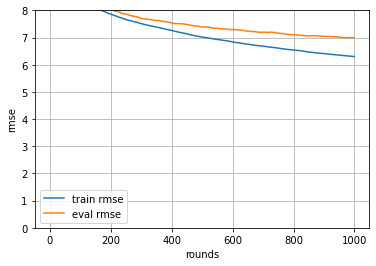

In [28]:
plt.plot(train_metric, label='train rmse')
plt.plot(eval_metric, label='eval rmse')
plt.grid()
plt.legend()
plt.ylim(0, 8)

plt.xlabel('rounds')
plt.ylabel('rmse')
plt.grid(True)
plt.show()

In [29]:
#X_train['lasso'] = y_lasso_pred
#X_test['lasso'] = y_lasso_test_pred
## データセットの標準化
#scaler.fit(X_train)
#scaler.fit(X_test)
#X_train_scaler = scaler.transform(X_train)
#X_test_scaler  = scaler.transform(X_test)

In [30]:
# SVM

params_grid = [
    {'C': [1, 10], 'kernel':['linear']},
    {'C': [1, 10], 'gamma': [0.01, 0.001], 'kernel': ['rbf']}
]
# パラメータチューニング
clf = GridSearchCV(
    estimator = SVC(),
    param_grid = params_grid,
    cv = 5,
    scoring='r2',
    n_jobs = -1
    )
#clf = RandomForestClassifier(max_depth=10, random_state=0)

# フィッテイング
clf.fit(X_train_scaler, y_train) 

# チューニングしたモデル
best_param = clf.best_params_
svc_tuned = clf.best_estimator_

# 予測値を反映
y_svc_pred = svc_tuned.predict(X_train_scaler) # Trainデータに対して予測
y_svc_test_pred = svc_tuned.predict(X_test_scaler) # Testデータに対して予測

#print("α = {}".format(clf.alpha_))
#print("ω = {}".format(clf.coef_))
#print("b = {}".format(clf.intercept_))

print(best_param)
print("Score = {}".format(clf.score(X_train_scaler, y_train)))
print("MAE = {}".format(mean_absolute_error(y_train, y_svc_pred)))
#print(cross_val_score(clf, X_train, y_train, cv=5))

C:\anaconda\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Score = 0.7963997552009829
MAE = 4.990480723465017


In [31]:
params_grid = {
    'alpha': 10 ** np.arange(-6, 1, 0.1)
}
# パラメータチューニング
clf = GridSearchCV(
    estimator = Ridge(),
    param_grid = params_grid,
    cv = 5,
    scoring='r2',
    n_jobs = -1
    )
# 線形モデルの重みを学習
clf.fit(X_train_scaler, y_train) 

# チューニングしたモデル
best_param = clf.best_params_
ridge_tuned = clf.best_estimator_

# 予測値を反映
y_ridge_pred = ridge_tuned.predict(X_train_scaler) # Trainデータに対して予測
y_ridge_test_pred = ridge_tuned.predict(X_test_scaler) # Testデータに対して予測

#print("α = {}".format(clf.alpha_))
#print("ω = {}".format(clf.coef_))
#print("b = {}".format(clf.intercept_))
print(best_param)
print("R^2 = {}".format(clf.score(X_train_scaler, y_train)))
print("MAE = {}".format(mean_absolute_error(y_train, y_ridge_pred)))

{'alpha': 7.943282347242366}
R^2 = 0.7394874387114629
MAE = 6.866621979918095


In [32]:
y_total_pred = y_lasso_pred*0.0 + y_ridge_pred*0.0 + y_svc_pred*1.0

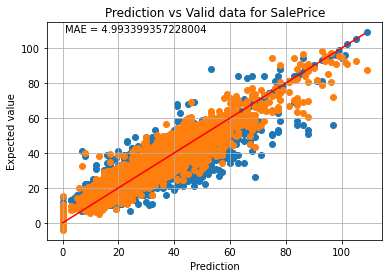

In [34]:
#plt.scatter(y_train, y_lasso_pred)
#plt.scatter(y_train, y_ridge_pred)
plt.scatter(y_train, y_svc_pred)
plt.scatter(y_train, y_lgb_oof_train)
#plt.scatter(y_train, y_total_pred)



plt.title("Prediction vs Valid data for SalePrice")
plt.xlabel("Prediction")
plt.ylabel("Expected value")
# Fitting line
x = np.arange(0, max(y_train))
y = x
plt.plot(x,y,color='red')

# MAE
#result_mae = mean_absolute_error(y_train, y_total_pred)
result_mae = mean_absolute_error(y_train, y_lgb_oof_train)
#result_rmsle = rmsle(y_train.values, y_lgb_oof_train)

plt.text(1, max(y_train), 'MAE = {}'.format(result_mae))

# Grid on
plt.grid(True)

In [35]:
# Average of Prediction data 
y_lgb_test_pred = sum(y_lgb_preds)/len(y_lgb_preds)

In [36]:
submit_sample[1] = y_lgb_test_pred
submit_sample.to_csv('submit.csv',index = False,  header=None)

In [37]:
submit_sample.head()

,0,1
0,2016-04-01,75.829186
1,2016-04-02,70.969179
2,2016-04-03,70.970468
3,2016-04-04,65.090738
4,2016-04-05,56.367153
